In [1]:
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 58.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 48.9 MB/s eta 0:00:00


# Lernprojekt
Dieses Projekt befasst sich mit Nationalratswahlergebnissen im Hinblick auf verschiedene Indikatoren. Die relevanten Datensätze können auf data.gv.at gefunden werden:
+ [Ergebnisse der Nationalratswahl 2017 (BMI)](https://www.data.gv.at/katalog/dataset/3179c5b2-9bb5-4a7f-a573-5491ccb0110b)
+ [Ergebnisse der Nationalratswahl 2019 (BMI)](https://www.data.gv.at/katalog/dataset/8becadda-124e-43f3-900e-f1ab685574e5)
+ [Gemeindeergebnisse der Abgestimmten Erwerbsstatistik und Arbeitsstättenzählung ab 2011 (Gebietsstand jeweils zum Stichtag 31.10.)](https://www.data.gv.at/katalog/dataset/80598a3d-4bc1-3fe0-b2c3-0febf834327d)

# Variablen Definition
Folgende Dataframes werden geladen und stehen nach der Datenaufarbeitung zur Verfügung:
+ ```indicators```: Der gesamte Datensatz zu Indikatoren.
+ ```indicators_2017```: Indikatoren für das Jahr 2017.
+ ```indicators_2019```: Indikatoren für das Jahr 2019.
+ ```election_2017```: Wahlergebnisse für das Jahr 2017.
+ ```election_2019```: Wahlergebnisse für das Jahr 2019.
+ ```election_indicators_2017```: Wahlergebnisse und Indikatoren für das Jahr 2017.
+ ```election_indicators_2019```: Wahlergebnisse und Indikatoren für das Jahr 2019.
+ ```election_indicators_2017_extended```: election_indicators_2017 mit additionalen columns fürs Jahr 2017.
+ ```election_indicators_2019_extended```: election_indicators_2019 mit additionalen columns fürs Jahr 2017.
+ ```y_pred_17```: Prognose des neuronalen Netzes, (trainiert an den Indikatoren von 2017) für die Wahlergebnisse anhand der Indikatoren von 2017
+ ```y_pred_19```: Prognose des neuronalen Netzes (trainiert an den Indikatoren von 2019) für die Wahlergebnisse 2019 anhand der Indikatoren von 2019
+ ```y_pred_17_19```: Prognose des neuronalen Netzes (trainiert an den Indikatoren von 2017) für die Wahlergebnisse 2019 anhand der Indikatoren von 2019

# Libraries
Libraries die später benötigt werden, werden an dieser Stelle importiert.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch

# disable warnings for clean outputs
import warnings
warnings.filterwarnings("ignore")

# Datenimportierung
Zuerst müssen Daten aus den verschiedenen Datensätzen importiert werden. Dazu wurden die CSV-Files in einen dedizierten Google Drive Ordner hochgeladen und zur öffentlichen Betrachtung freigegeben. Mit dem File-Link können diese nun aus dem Colab-File heraus abgerufen und ausgelesen werden.

In [3]:
election_2017_url='https://drive.google.com/file/d/1HY8kzuuJ8C2Xn3mpv0A6l2msdowVanBY/view?usp=share_link'
election_2017_url='https://drive.google.com/uc?id=' + election_2017_url.split('/')[-2]

election_2019_url='https://drive.google.com/file/d/11Oolf38RxNP7AGPrl_4mc-uVcWU4_Ya6/view?usp=share_link'
election_2019_url='https://drive.google.com/uc?id=' + election_2019_url.split('/')[-2]

indicators_url='https://drive.google.com/file/d/14M4CiQA5ITqsMzvvR8WzQtuyRfpZQK_f/view?usp=share_link'
indicators_url='https://drive.google.com/uc?id=' + indicators_url.split('/')[-2]

election_2017 = pd.read_csv(election_2017_url, sep=";", index_col=0, encoding="unicode_escape")
election_2019 = pd.read_csv(election_2019_url, sep=";", index_col=0, encoding="unicode_escape")
indicators = pd.read_csv(indicators_url, sep=";", decimal=",")

In [4]:
election_2017.head(3)

Gebietsname  Wahlberechtigte  Abgegebene  Ungültige  \
G00000               Österreich          6400993     5120881      50952   
G10000               Burgenland           232740      196577       1947   
G10099  Wahlkarten - Burgenland                0          17         17   

        Gültige      SPÖ      ÖVP      FPÖ   GRÜNE    NEOS  ...   FLÖ    KPÖ  \
G00000  5069929  1361746  1595526  1316442  192638  268518  ...  8889  39689   
G10000   194630    64070    63858    49127    3932    5603  ...   273    722   
G10099        0        0        0        0       0       0  ...     0      0   

        WEIßE    SLP  EUAUS      M    CPÖ     NBZ    ODP  Unnamed: 22  
G00000   9167  713.0  693.0  221.0  425.0  2724.0  761.0          NaN  
G10000    221    NaN    NaN    NaN    NaN     NaN    NaN          NaN  
G10099      0    NaN    NaN    NaN    NaN     NaN    NaN          NaN  

[3 rows x 22 columns]

In [5]:
election_2019.head(3)

Gebietsname  Wahlberechtigte  Abgegebene  Ungültige  \
G00000               Österreich          6396812     4835469      58223   
G10000               Burgenland           233182      189911       2850   
G10099  Wahlkarten - Burgenland                0           1          1   

        Gültige      ÖVP      SPÖ     FPÖ    NEOS  JETZT   GRÜNE    KPÖ  \
G00000  4777246  1789417  1011868  772666  387124  89169  664055  32736   
G10000   187061    71566    54965   32448    9130   2351   15113    739   
G10099        0        0        0       0       0      0       0      0   

        WANDL    BZÖ    BIER    CPÖ    GILT    SLP  Unnamed: 19  
G00000  22168  760.0  4946.0  260.0  1767.0  310.0          NaN  
G10000    489    NaN     NaN  260.0     NaN    NaN          NaN  
G10099      0    NaN     NaN    0.0     NaN    NaN          NaN

In [6]:
indicators.head(3)

JAHR    GCD                        GEM_NAME  BEV_ABSOLUT  BEV_UNTER15  \
0  2011  10101                      Eisenstadt        13101         13.8   
1  2011  10201                            Rust         1896         13.8   
2  2011  10301  Breitenbrunn am Neusiedler See         1902         12.1   

   BEV_UEBER65 AUSL_STAATSB  EWTQ_15BIS64  ALQ_15PLUS  EDU_15_SEK  EDU_15_TER  \
0         18.2          9,4          70.9         4.3        59.5        18.7   
1         22.2          4,7          74.9         3.2        61.4         7.6   
2         22.4          5,6          71.2         3.7        62.4        10.7   

   AUSPENDLER   PHH  HH_SIZE  FAMILIEN   UNT   AST  BESCH_AST  
0        43.6  5950     2.15      3597  1394  1768      16060  
1        62.4   798     2.33       549   191   216        865  
2        78.6   866     2.18       571   157   173        573

Die regionalen Kennzahlen (im Indikatoren-Datensatz "GCD" genannt) sind in den Wahlergebnissen eine überschriftslose Indexspalte. Um einfacher damit arbeiten zu können, geben wir dem Index einen Name und wandeln ihn zu einer normalen Spalte um.

In [7]:
# rename and reset index so it's easier to work with
election_2017.index.name = "GCD"
election_2017.reset_index(inplace=True)

# rename and reset index so it's easier to work with
election_2019.index.name = "GCD"
election_2019.reset_index(inplace=True)

Einige der Spalten sind für unsere Analyse irrelevant, da wir uns auf die 4 größten Parteien (ÖVP, SPÖ, FPÖ, GRÜNE) konzentrieren; die Anzahl der Wahlberechtigten, und die Anzahl abgegebener und ungültiger Stimmen sind ebenfalls nicht von Bedeutung, da nur die Zahl gültiger Stimmen zur anteilhaften Errechnung von Wahlergebnissen verwendet wird.

Weiters sind einige Indikatoren nicht relevant (absolute Anzahl der Privathaushalte, Familien, Unternehmen, Arbeitsstätten, und Beschäftigten in den Arbeitsstätten).

In [8]:
# keep relevant columns
election_columns = ["GCD",
                    "Gebietsname",
                    "Gültige",
                    "SPÖ",
                    "ÖVP",
                    "FPÖ",
                    "GRÜNE"]

election_2017 = election_2017[election_columns]
election_2019 = election_2019[election_columns]

# keep relevant columns
indicator_columns = ["JAHR",
                     "GCD",
                     "GEM_NAME",
                     "BEV_ABSOLUT",
                     "BEV_UNTER15",
                     "BEV_UEBER65",
                     "AUSL_STAATSB",
                     "EWTQ_15BIS64",
                     "ALQ_15PLUS",
                     "EDU_15_SEK",
                     "EDU_15_TER",
                     "AUSPENDLER",
                     "HH_SIZE",
                     "UNT"]

indicators = indicators[indicator_columns]

Zuletzt benennen wir die Spalten des Indikatoren-Datensatzes zu sprechenden Namen um. Die Spalten der Wahlergebnis-Datensätze haben bereits sprechende Namen.

In [9]:
# rename indicator columns
indicators = indicators.rename(columns=
                               {"JAHR": "Jahr",
                                "GEM_NAME": "Gemeindename",
                                "BEV_ABSOLUT": "Bevölkerung (Abs.)",
                                "BEV_UNTER15": "Bevölkerung < 15 (%)",
                                "BEV_UEBER65": "Bevölkerung > 65 (%)",
                                "AUSL_STAATSB": "Ausländische Staatsbürger (%)",
                                "EWTQ_15BIS64": "Erwerbstätige (%)",
                                "ALQ_15PLUS": "Arbeitslose (%)",
                                "EDU_15_SEK": "Sekundarabschluss (%)",
                                "EDU_15_TER": "Tertiärabschluss (%)",
                                "AUSPENDLER": "Auspendler (%)",
                                "HH_SIZE": "Haushaltsgröße (Abs.)",
                                "UNT": "Unternehmen (Abs.)"})

# Datenaufbereitung
Vor der weiteren Verwendung müssen die Daten aufbereitet werden.

## Datentypen, Format
Zunächst werden die Datentypen der Serien analystiert.

In [10]:
election_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2451 entries, 0 to 2450
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   GCD          2451 non-null   object
 1   Gebietsname  2451 non-null   object
 2   Gültige      2451 non-null   int64 
 3   SPÖ          2451 non-null   int64 
 4   ÖVP          2451 non-null   int64 
 5   FPÖ          2451 non-null   int64 
 6   GRÜNE        2451 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 134.2+ KB


In [11]:
election_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   GCD          2447 non-null   object
 1   Gebietsname  2447 non-null   object
 2   Gültige      2447 non-null   int64 
 3   SPÖ          2447 non-null   int64 
 4   ÖVP          2447 non-null   int64 
 5   FPÖ          2447 non-null   int64 
 6   GRÜNE        2447 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 133.9+ KB


In [12]:
indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22231 entries, 0 to 22230
Data columns (total 14 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Jahr                           22231 non-null  int64  
 1   GCD                            22231 non-null  int64  
 2   Gemeindename                   22231 non-null  object 
 3   Bevölkerung (Abs.)             22231 non-null  int64  
 4   Bevölkerung < 15 (%)           22231 non-null  float64
 5   Bevölkerung > 65 (%)           22231 non-null  float64
 6   Ausländische Staatsbürger (%)  22231 non-null  object 
 7   Erwerbstätige (%)              22231 non-null  float64
 8   Arbeitslose (%)                22231 non-null  float64
 9   Sekundarabschluss (%)          22231 non-null  float64
 10  Tertiärabschluss (%)           22231 non-null  float64
 11  Auspendler (%)                 22231 non-null  float64
 12  Haushaltsgröße (Abs.)          22231 non-null 

### Regionale Kennzahlen
In den Indikatoren ist ```GCD``` ein ```int64```, während er in den Wahlergebnissen ein ```object``` ist.

In [13]:
election_2017["GCD"].head()

0    G00000
1    G10000
2    G10099
3    G1A000
4    G1A099
Name: GCD, dtype: object

In [14]:
indicators["GCD"].head()

0    10101
1    10201
2    10301
3    10302
4    10303
Name: GCD, dtype: int64

Da die regionalen Kennziffern (```GCD```) in den Datensätzen unterschiedliche Formate haben (```int64``` in den Indikatoren, ```string``` mit Präfix in den Wahlergebnissen), müssen diese auf ein gemeinsames Format umgewandelt werden. Dazu wird den regionalen Kennziffern ein Präfix hinzugefügt.

In [15]:
# transform GCD into prefixed string
indicators["GCD"] = "G" + indicators["GCD"].astype("str")

### Indikatoren
Der Indikator ```Ausländische Staatsbürger (%)``` ist als ```string``` formatiert und muss umgewandelt werden. Zuerst wird erhoben, warum diese Serie nicht bereits mit numerischem Datentyp ausgelesen wurde.

In [16]:
indicators[pd.to_numeric(indicators["Ausländische Staatsbürger (%)"].str.replace(",", "."), errors="coerce").isna()]["Ausländische Staatsbürger (%)"]

6681    -
Name: Ausländische Staatsbürger (%), dtype: object

Der Datensatz an Index ```6681``` weist einen wert von ```"-"``` auf, weswegen die Serie nicht mit numerischem Datentyp ausgelesen worden ist. Für den Zweck dieses Projekts genügt es die restlichen Datensätze korrekt zu konvertieren und diesen abzuwerfen.

In [17]:
indicators["Ausländische Staatsbürger (%)"] = pd.to_numeric(indicators["Ausländische Staatsbürger (%)"].str.replace(",", "."), errors="coerce")
indicators = indicators.dropna(axis="index")

Die Statistik ```Ausländische Staatsbürger (%)``` weist in den übrigen Jahren (2011, 2012, 2014) einen Wert von 0 auf, weswegen die Vermutung nahe liegt, dass der fehlerhafte Wert (```"-"```) versehentlich statt 0 eingegeben wurde. Da wir von dieser Gemeinde auch in weiterer Folge keine weitere Regressionsanalyse benötigen, ist die Entscheidung gefallen, dass wir die gesamte Zeile zur Gemeinde verwerfen.

## Fehlende Werte
Da später mit Machine Learning gearbeitet wird, müssen fehlende Werte entweder aufgefüllt oder abgeworfen werden.

In [18]:
election_2017.isna().sum()

GCD            0
Gebietsname    0
Gültige        0
SPÖ            0
ÖVP            0
FPÖ            0
GRÜNE          0
dtype: int64

In [19]:
election_2019.isna().sum()

GCD            0
Gebietsname    0
Gültige        0
SPÖ            0
ÖVP            0
FPÖ            0
GRÜNE          0
dtype: int64

In [20]:
indicators.isna().sum()

Jahr                             0
GCD                              0
Gemeindename                     0
Bevölkerung (Abs.)               0
Bevölkerung < 15 (%)             0
Bevölkerung > 65 (%)             0
Ausländische Staatsbürger (%)    0
Erwerbstätige (%)                0
Arbeitslose (%)                  0
Sekundarabschluss (%)            0
Tertiärabschluss (%)             0
Auspendler (%)                   0
Haushaltsgröße (Abs.)            0
Unternehmen (Abs.)               0
dtype: int64

Es fehlen keine Werte.

## Fehlerhafte Werte
Fehlerhafte Werte müssen korrigiert oder abgeworfen werden. Dazu werden zusammenfassende Tabellen mit Statistiken über Durchschnittswerte, Minimal- und Maximalwerte, sowie Quartile an.

Auffällige Werte wären hier zum Beispiel negative Werte, da der Datensatz nur positive enthalten darf, oder auch Maximalwerte über ```100%``` bei anteilhaften Eigenschaften.

In [21]:
indicators.describe()

Jahr  Bevölkerung (Abs.)  Bevölkerung < 15 (%)  \
count  22230.000000        22230.000000          22230.000000   
mean    2015.360054         3906.877823             14.618866   
std        2.884650        13071.020327              2.162596   
min     2011.000000           41.000000              3.900000   
25%     2013.000000         1055.000000             13.225000   
50%     2015.000000         1718.000000             14.700000   
75%     2018.000000         3006.000000             16.000000   
max     2020.000000       290910.000000             25.400000   

       Bevölkerung > 65 (%)  Ausländische Staatsbürger (%)  Erwerbstätige (%)  \
count          22230.000000                   22230.000000       22230.000000   
mean              19.003234                       7.261678          74.316955   
std                3.608074                       5.675758           4.644044   
min                9.200000                       0.000000          36.600000   
25%               16.400000                       3.300000          71.600000   
50%               18.600000                       5.800000          74.800000   
75%               21.100000                       9.700000          77.600000   
max               44.300000                      67.300000          89.700000   

       Arbeitslose (%)  Sekundarabschluss (%)  Tertiärabschluss (%)  \
count     22230.000000           22230.000000          22230.000000   
mean          4.779258              64.238228              8.722848   
std           2.873879               4.354204              4.467444   
min           0.000000              39.400000              0.000000   
25%           2.900000              61.800000              5.900000   
50%           4.200000              64.700000              7.800000   
75%           5.800000              67.200000             10.300000   
max          33.600000              78.500000             45.700000   

       Auspendler (%)  Haushaltsgröße (Abs.)  Unternehmen (Abs.)  
count    22230.000000           22230.000000        22230.000000  
mean        71.781907               2.485551          291.616869  
std         12.756507               0.259809          899.634177  
min          8.800000               1.750000            1.000000  
25%         66.800000               2.310000           83.000000  
50%         74.800000               2.470000          134.000000  
75%         80.300000               2.640000          232.000000  
max         96.200000               4.080000        21870.000000

Eine oberflächliche Analyse der Indikatoren ergibt keine auffäligen Werte.

In [22]:
election_2017.describe()

Gültige           SPÖ           ÖVP           FPÖ          GRÜNE
count  2.451000e+03  2.451000e+03  2.451000e+03  2.451000e+03    2451.000000
mean   1.032743e+04  2.773925e+03  3.251008e+03  2.683143e+03     391.687067
std    1.112730e+05  3.003191e+04  3.503547e+04  2.890922e+04    4263.374995
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00       0.000000
25%    6.920000e+02  1.290000e+02  2.670000e+02  1.860000e+02      11.000000
50%    1.167000e+03  2.610000e+02  4.300000e+02  3.370000e+02      24.000000
75%    2.338000e+03  5.915000e+02  8.105000e+02  6.505000e+02      68.000000
max    5.069929e+06  1.361746e+06  1.595526e+06  1.316442e+06  192638.000000

In [23]:
election_2019.describe()

Gültige           SPÖ           ÖVP            FPÖ          GRÜNE
count  2.447000e+03  2.447000e+03  2.447000e+03    2447.000000    2447.000000
mean   9.748050e+03  2.065477e+03  3.652898e+03    1577.380875    1353.158970
std    1.049481e+05  2.235594e+04  3.933726e+04   17001.770177   14726.766696
min    0.000000e+00  0.000000e+00  0.000000e+00       0.000000       0.000000
25%    6.320000e+02  9.000000e+01  2.975000e+02     104.500000      42.000000
50%    1.068000e+03  1.960000e+02  4.780000e+02     201.000000      90.000000
75%    2.141000e+03  4.415000e+02  9.200000e+02     390.500000     233.500000
max    4.777246e+06  1.011868e+06  1.789417e+06  772666.000000  664055.000000

Eine oberflächliche Analyse der Wahlergebnisse ergibt keine auffäligen Werte.

Es wurde bereits ein fehlerhafter Wert (```"-"``` im Indikator ```Ausländische Staatsbürger (%)```) bei der Überprüfung der Datentypen nach dem Einlesen der Datensätze entdeckt und berichtet. Weitere fehlerhafte Werte wurden nicht entdeckt.

# Datentransformation
Daten die in anderer Form benötigt sind, werden hier transformiert.

## Anteilhafte Wahlergebnisse
Da die Wahlergebnisse nur in absoluten Zahlen verfügbar sind, werden die anteilhaften Ergebnisse ermittelt und den Datensätzen hinzugefügt.

In [24]:
parties = ['SPÖ', 'ÖVP', 'FPÖ', 'GRÜNE']

# add columns for party %
for party in parties:
  election_2017[party + ' (%)'] = election_2017[party] / election_2017['Gültige']
  election_2019[party + ' (%)'] = election_2019[party] / election_2019['Gültige']

## Anteilhafte Unternehmen
Ähnlich wird eine Unternehmensquote errechnet, die Anzahl der Unternehmen pro Einwohneranzahl widerspiegelt.

In [25]:
indicators["Unternehmen (pro Kopf)"] = indicators["Unternehmen (Abs.)"] / indicators["Bevölkerung (Abs.)"]

# Datenzusammenführung
Die verschiedenen Datensätze müssen zur weiteren Benutzung über Joins zusammengeführt werden.

In [26]:
# get indicators for 2017
indicators_2017 = indicators[indicators["Jahr"] == 2017]
indicators_2017 = indicators_2017.drop(columns="Jahr")

# get indicators for 2019
indicators_2019 = indicators[indicators["Jahr"] == 2019]
indicators_2019 = indicators_2019.drop(columns="Jahr")

In [27]:
# join 2017
election_indicators_2017 = election_2017.merge(indicators_2017,
                                               on="GCD",
                                               how="inner")

# join 2019
election_indicators_2019 = election_2019.merge(indicators_2019,
                                               on="GCD",
                                               how="inner")

# drop duplicate columns
election_indicators_2017 = election_indicators_2017.drop(columns="Gebietsname")
election_indicators_2019 = election_indicators_2019.drop(columns="Gebietsname")

##Wahlbeteiligung

Für die Wahlergebnisse kann die Whlbeteiligung ausschlaggebend sein

In [28]:
election_indicators_2017['Wahlbeteiligung'] = election_indicators_2017['Gültige'] / election_indicators_2017['Bevölkerung (Abs.)']
election_indicators_2019['Wahlbeteiligung'] = election_indicators_2019['Gültige'] / election_indicators_2019['Bevölkerung (Abs.)']

# Explorative Datenanalyse

##Verteilung der Indikatoren, Parteien und Bundesland

###Analyse der DataFrames

Zunächst analysieren wir die beiden DataFrame, mit denen wir arbeiten werden, nämlich election_indicators_2019 und election_indicators_2017. Das sind die DataFrames die in den vorherigen Schritten erhalten worden sind.

DataFrame.columns zeigt uns alle Kolumnen(Header) an.

DataFrame.info() zeigt uns alle Datentypen (Dtype) die in den Rows der Kolumnen(Header) enthalten sind.

In [29]:
display(election_indicators_2017.columns)

Index(['GCD', 'Gültige', 'SPÖ', 'ÖVP', 'FPÖ', 'GRÜNE', 'SPÖ (%)', 'ÖVP (%)',
       'FPÖ (%)', 'GRÜNE (%)', 'Gemeindename', 'Bevölkerung (Abs.)',
       'Bevölkerung < 15 (%)', 'Bevölkerung > 65 (%)',
       'Ausländische Staatsbürger (%)', 'Erwerbstätige (%)', 'Arbeitslose (%)',
       'Sekundarabschluss (%)', 'Tertiärabschluss (%)', 'Auspendler (%)',
       'Haushaltsgröße (Abs.)', 'Unternehmen (Abs.)', 'Unternehmen (pro Kopf)',
       'Wahlbeteiligung'],
      dtype='object')

In [30]:
display(election_indicators_2019.columns)

Index(['GCD', 'Gültige', 'SPÖ', 'ÖVP', 'FPÖ', 'GRÜNE', 'SPÖ (%)', 'ÖVP (%)',
       'FPÖ (%)', 'GRÜNE (%)', 'Gemeindename', 'Bevölkerung (Abs.)',
       'Bevölkerung < 15 (%)', 'Bevölkerung > 65 (%)',
       'Ausländische Staatsbürger (%)', 'Erwerbstätige (%)', 'Arbeitslose (%)',
       'Sekundarabschluss (%)', 'Tertiärabschluss (%)', 'Auspendler (%)',
       'Haushaltsgröße (Abs.)', 'Unternehmen (Abs.)', 'Unternehmen (pro Kopf)',
       'Wahlbeteiligung'],
      dtype='object')

In [31]:
display(election_indicators_2017.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2122 entries, 0 to 2121
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   GCD                            2122 non-null   object 
 1   Gültige                        2122 non-null   int64  
 2   SPÖ                            2122 non-null   int64  
 3   ÖVP                            2122 non-null   int64  
 4   FPÖ                            2122 non-null   int64  
 5   GRÜNE                          2122 non-null   int64  
 6   SPÖ (%)                        2122 non-null   float64
 7   ÖVP (%)                        2122 non-null   float64
 8   FPÖ (%)                        2122 non-null   float64
 9   GRÜNE (%)                      2122 non-null   float64
 10  Gemeindename                   2122 non-null   object 
 11  Bevölkerung (Abs.)             2122 non-null   int64  
 12  Bevölkerung < 15 (%)           2122 non-null   f

None

In [32]:
display(election_indicators_2017.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2122 entries, 0 to 2121
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   GCD                            2122 non-null   object 
 1   Gültige                        2122 non-null   int64  
 2   SPÖ                            2122 non-null   int64  
 3   ÖVP                            2122 non-null   int64  
 4   FPÖ                            2122 non-null   int64  
 5   GRÜNE                          2122 non-null   int64  
 6   SPÖ (%)                        2122 non-null   float64
 7   ÖVP (%)                        2122 non-null   float64
 8   FPÖ (%)                        2122 non-null   float64
 9   GRÜNE (%)                      2122 non-null   float64
 10  Gemeindename                   2122 non-null   object 
 11  Bevölkerung (Abs.)             2122 non-null   int64  
 12  Bevölkerung < 15 (%)           2122 non-null   f

None

In [33]:
display(election_indicators_2019.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2118 entries, 0 to 2117
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   GCD                            2118 non-null   object 
 1   Gültige                        2118 non-null   int64  
 2   SPÖ                            2118 non-null   int64  
 3   ÖVP                            2118 non-null   int64  
 4   FPÖ                            2118 non-null   int64  
 5   GRÜNE                          2118 non-null   int64  
 6   SPÖ (%)                        2118 non-null   float64
 7   ÖVP (%)                        2118 non-null   float64
 8   FPÖ (%)                        2118 non-null   float64
 9   GRÜNE (%)                      2118 non-null   float64
 10  Gemeindename                   2118 non-null   object 
 11  Bevölkerung (Abs.)             2118 non-null   int64  
 12  Bevölkerung < 15 (%)           2118 non-null   f

None

Wir können aus der Ausgabe sehen, dass die Mehrheit der Dtypen Float64 und Int64 sind. Gemeindename und GCD sind beide Strings.

In [34]:
# Set the maximum number of columns to be displayed in pandas DataFrames to unlimited
pd.set_option('display.max_columns', None)
display(election_indicators_2017.describe())

Gültige           SPÖ           ÖVP           FPÖ        GRÜNE  \
count    2122.000000   2122.000000   2122.000000   2122.000000  2122.000000   
mean     2016.646089    539.398680    632.397267    551.574929    66.903393   
std      5462.115054   1795.285695   1290.941249   1384.147511   279.625761   
min        24.000000      0.000000      5.000000      3.000000     0.000000   
25%       651.000000    118.000000    252.250000    175.250000    10.000000   
50%      1046.000000    229.000000    389.000000    307.500000    20.000000   
75%      1767.000000    421.000000    647.750000    509.750000    43.000000   
max    119671.000000  33017.000000  31647.000000  25260.000000  6932.000000   

           SPÖ (%)      ÖVP (%)      FPÖ (%)    GRÜNE (%)  Bevölkerung (Abs.)  \
count  2122.000000  2122.000000  2122.000000  2122.000000         2122.000000   
mean      0.223538     0.381869     0.283612     0.023396         4152.583412   
std       0.087072     0.101310     0.062189     0.015476        13704.758001   
min       0.000000     0.102740     0.072464     0.000000           48.000000   
25%       0.160385     0.310994     0.243557     0.013209         1132.500000   
50%       0.215699     0.378346     0.281618     0.019675         1830.500000   
75%       0.279178     0.447011     0.323535     0.029669         3200.500000   
max       0.675676     0.833333     0.537718     0.131004       285430.000000   

       Bevölkerung < 15 (%)  Bevölkerung > 65 (%)  \
count           2122.000000           2122.000000   
mean              14.667342             19.340104   
std                2.151712              3.579461   
min                6.800000             10.100000   
25%               13.300000             16.800000   
50%               14.700000             18.900000   
75%               16.000000             21.500000   
max               25.400000             43.600000   

       Ausländische Staatsbürger (%)  Erwerbstätige (%)  Arbeitslose (%)  \
count                    2122.000000        2122.000000      2122.000000   
mean                        8.125730          75.294722         4.741942   
std                         5.933243           4.558428         2.872778   
min                         0.200000          53.700000         0.000000   
25%                         3.900000          72.700000         2.900000   
50%                         6.600000          75.950000         4.100000   
75%                        10.700000          78.500000         5.800000   
max                        63.500000          85.500000        28.400000   

       Sekundarabschluss (%)  Tertiärabschluss (%)  Auspendler (%)  \
count            2122.000000           2122.000000     2122.000000   
mean               64.863902              9.260933       71.513525   
std                 4.233876              4.492923       12.864290   
min                44.400000              0.000000        9.500000   
25%                62.600000              6.500000       66.700000   
50%                65.300000              8.200000       74.600000   
75%                67.700000             10.800000       80.100000   
max                77.700000             42.700000       94.100000   

       Haushaltsgröße (Abs.)  Unternehmen (Abs.)  Unternehmen (pro Kopf)  \
count            2122.000000         2122.000000             2122.000000   
mean                2.454029          313.594251                0.082330   
std                 0.236061          937.155133                0.028408   
min                 1.780000            2.000000                0.023041   
25%                 2.290000           89.000000                0.066023   
50%                 2.435000          145.500000                0.079388   
75%                 2.600000          256.750000                0.092631   
max                 3.790000        20312.000000                0.621948   

       Wahlbeteiligung  
count      2122.000000  
mean          0.557880  
std           0.0

1. Es gibt 2122 Datensätze im DataFrame.
2. Die durchschnittliche Anzahl an gültigen Stimmen liegt bei etwa 2017, während die durchschnittliche Anzahl an Stimmen für jede politische Partei (SPÖ, ÖVP, FPÖ und GRÜNE) zwischen 67 und 633 variiert.
3. Die politischen Parteien SPÖ, ÖVP und FPÖ haben jeweils etwa 22-38% der gültigen Stimmen erhalten, während die GRÜNEN etwa 0-2% erhalten haben.
4. Der durchschnittliche Prozentsatz der Bevölkerung unter 15 Jahren liegt bei rund 14,7%, während der durchschnittliche Prozentsatz der Bevölkerung über 65 Jahren bei rund 19,3% liegt.
5. Im Durchschnitt sind rund 8,1% der Bevölkerung ausländische Staatsbürger, während rund 75,3% erwerbstätig sind.
6. Der durchschnittliche Prozentsatz der Bevölkerung mit einem Sekundarschulabschluss liegt bei etwa 65%, während der durchschnittliche Prozentsatz mit einem Tertiärschulabschluss bei etwa 9,3% liegt.
7. Die durchschnittliche Haushaltsgröße beträgt rund 2,5 Personen.
8. Die durchschnittliche Anzahl von Unternehmen pro Kopf beträgt rund 0,08.
9. Die durchschnittliche Wahlbeteiligung beträgt rund 0,56.

In [35]:
display(election_indicators_2019.describe())
# reset the maximum columns to their default value (usually 20)
pd.reset_option('display.max_columns')

Gültige           SPÖ           ÖVP           FPÖ         GRÜNE  \
count    2118.000000   2118.000000   2118.000000   2118.000000   2118.000000   
mean     1806.689802    389.224268    692.962229    311.742682    223.216242   
std      4763.571685   1257.260368   1332.224595    746.655469    927.524592   
min        24.000000      0.000000     10.000000      0.000000      0.000000   
25%       605.000000     82.000000    282.250000     99.250000     38.000000   
50%       949.500000    167.000000    431.000000    178.000000     75.000000   
75%      1620.250000    316.000000    719.750000    296.000000    153.750000   
max    108646.000000  21794.000000  31322.000000  14151.000000  27372.000000   

           SPÖ (%)      ÖVP (%)      FPÖ (%)    GRÜNE (%)  Bevölkerung (Abs.)  \
count  2118.000000  2118.000000  2118.000000  2118.000000         2118.000000   
mean      0.182080     0.464411     0.180285     0.088010         4199.423985   
std       0.089676     0.110695     0.050787     0.042686        13950.671603   
min       0.000000     0.173071     0.000000     0.000000           42.000000   
25%       0.117145     0.382433     0.147562     0.057906         1147.000000   
50%       0.167542     0.460387     0.175945     0.080960         1837.500000   
75%       0.238617     0.538637     0.211348     0.110477         3240.000000   
max       0.567568     0.958333     0.488889     0.363879       290540.000000   

       Bevölkerung < 15 (%)  Bevölkerung > 65 (%)  \
count           2118.000000           2118.000000   
mean              14.624221             19.877904   
std                2.177153              3.654088   
min                5.700000             10.300000   
25%               13.200000             17.300000   
50%               14.700000             19.400000   
75%               16.000000             22.100000   
max               22.800000             40.200000   

       Ausländische Staatsbürger (%)  Erwerbstätige (%)  Arbeitslose (%)  \
count                    2118.000000        2118.000000      2118.000000   
mean                        8.498017          76.482389         4.196978   
std                         6.285673           4.380746         2.652568   
min                         0.100000          52.700000         0.000000   
25%                         4.000000          74.200000         2.425000   
50%                         6.900000          77.100000         3.600000   
75%                        11.200000          79.575000         5.200000   
max                        67.300000          88.400000        29.900000   

       Sekundarabschluss (%)  Tertiärabschluss (%)  Auspendler (%)  \
count            2118.000000           2118.000000     2118.000000   
mean               65.267894              9.996034       71.880500   
std                 4.365183              4.740810       12.836308   
min                42.800000              0.000000        9.400000   
25%                63.000000              7.000000       66.900000   
50%                65.700000              8.950000       75.100000   
75%                68.100000             11.675000       80.300000   
max                77.200000             44.900000       96.200000   

       Haushaltsgröße (Abs.)  Unternehmen (Abs.)  Unternehmen (pro Kopf)  \
count            2118.000000         2118.000000             2118.000000   
mean                2.423178          328.059018                0.084808   
std                 0.226597          987.339967                0.030376   
min                 1.750000            1.000000                0.015873   
25%                 2.270000           92.000000                0.067372   
50%                 2.410000          150.000000                0.081291   
75%                 2.570000          264.750000                0.095227   
max                 3.500000        21271.000000                0.668204   

       Wahlbeteiligung  
count      2118.000000  
mean          0.506494  
std     

1. Es gibt 2118 Datensätze im DataFrame.
2. Die durchschnittliche Anzahl an gültigen Stimmen liegt bei etwa 1807, während die durchschnittliche Anzahl an Stimmen für jede politische Partei (SPÖ, ÖVP, FPÖ und GRÜNE) zwischen 223 und 693 variiert.
3. Die politischen Parteien SPÖ, ÖVP und FPÖ haben jeweils etwa 18-46% der gültigen Stimmen erhalten, während die GRÜNEN etwa 0-9% erhalten haben.
4. Der durchschnittliche Prozentsatz der Bevölkerung unter 15 Jahren liegt bei rund 14,6%, während der durchschnittliche Prozentsatz der Bevölkerung über 65 Jahren bei rund 19,9% liegt.
5. Im Durchschnitt sind rund 8,5% der Bevölkerung ausländische Staatsbürger, während rund 76,5% erwerbstätig sind.
6. Der durchschnittliche Prozentsatz der Bevölkerung mit einem Sekundarschulabschluss liegt bei etwa 65%, während der durchschnittliche Prozentsatz mit einem Tertiärschulabschluss bei etwa 10% liegt.
7. Die durchschnittliche Haushaltsgröße beträgt rund 2,4 Personen.
8. Die durchschnittliche Anzahl von Unternehmen pro Kopf beträgt rund 0,08.
9. Die durchschnittliche Wahlbeteiligung beträgt rund 0,51.

###Parteien und Wahlstimmen

Wir erstellen in diesem Abschnitt gestapelte Balkendiagramme für die beiden DataFrames election_indicators_2017 und election_indicators_2017 die jeweils die österreichischen Nationalratswahlen 2017 und 2019 darstellen. Die Gesamtstimmenzahl für jede politische Partei und ihr prozentualer Anteil an den Gesamtstimmen wird angezeigt.

Die Funktion create_stacked_bar_chart nimmt einen DataFrame als Eingabe und verwendet ihn zur Erstellung des Balkendiagramms. Der Code definiert auch Farben für jede politische Partei und setzt die Titel- und Achsenbeschriftungen des Diagramms.

In [36]:
# names of each political party
political_parties = ["SPÖ", "ÖVP", "FPÖ", "GRÜNE", "Andere Parteien"]

# define the colors for each political party
political_colors = {'SPÖ': '#e3000f', 'ÖVP': '#000000', 'FPÖ': '#1c388c', 'GRÜNE': '#46962b', "Andere Parteien": "#D3D3D3"}
political_colors_lighter = {'SPÖ': '#ff7f88', 'ÖVP': '#5f5f5f', 'FPÖ': '#5c80b5', 'GRÜNE': '#8fd789', "Andere Parteien": "#dcdcdc"}

In [37]:
def create_stacked_bar_chart(df, year_str, ax, font_size, label_padding):
  """Creates a stacked bar chart displaying the percentage of votes for each political party in a given year.

  Parameters:
  df (pandas.DataFrame): A pandas DataFrame containing the election results for a given year.
  year_str (str): A string representing the year of the election.
  ax (matplotlib.axes.Axes): A matplotlib Axes object to plot the chart on.
  font_size (int): The font size for the chart title.
  label_padding (int): The padding between the x- and y-axis labels and their corresponding axes.

  Returns:
  None
  """

  # calculate the sum of votes for each party and the sum of valid votes
  sum_spoe = df["SPÖ"].sum()
  sum_oevp = df["ÖVP"].sum()
  sum_fpoe = df["FPÖ"].sum()
  sum_gruene = df["GRÜNE"].sum()
  sum_valid_votes = df["Gültige"].sum()
  sum_others = sum_valid_votes - (sum_spoe + sum_oevp + sum_fpoe + sum_gruene)

  # calculate the percentage of votes for each party
  percent_spoe = sum_spoe / sum_valid_votes
  percent_oevp = sum_oevp / sum_valid_votes
  percent_fpoe = sum_fpoe / sum_valid_votes
  percent_gruene = sum_gruene / sum_valid_votes
  percent_others = sum_others / sum_valid_votes

  # create a DataFrame with the total votes and percentage for each party
  df = pd.DataFrame({'Political Parties': political_parties,
                    'Total Votes': [sum_spoe, sum_oevp, sum_fpoe, sum_gruene, sum_others],
                    'Percentage': [percent_spoe, percent_oevp, percent_fpoe, 
                                    percent_gruene, percent_others]})
  
  # calculate the remainder percentage (i.e., the percentage that is not accounted for by the top 4 parties)
  df["Remainder Percentage"] = 1 - df["Percentage"]

  # create a bar chart with the total votes and percentage for each party
  sns.barplot(x='Political Parties', y='Percentage', data=df, palette=political_colors.values(), ax=ax, zorder=10)

  # stack the remainder percentage bar on top of the existing bars
  for i, party in enumerate(political_parties):
      ax.bar(i, df['Remainder Percentage'][i], bottom=df['Percentage'][i], color=political_colors_lighter[party], alpha=0.5)

  # set the x and y labels and title
  ax.set_title(f'Gesamtstimmen für Top 4 & andere Parteien {year_str}', fontsize=font_size, pad=label_padding)
  ax.set_xlabel('')
  ax.set_ylabel('')

  # add percentage labels to the bars
  for i, container in enumerate(ax.containers):
      for j, bar in enumerate(container):
          if bar.get_height() == df['Percentage'].iloc[j]:
              ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), '{:.1%}'.format(bar.get_height()), ha='center', va='bottom')

In [38]:
def plot_political_party_votes_horizontal(fontsize_title, label_padding, figure_size):
  """Plots a horizontal bar chart displaying the percentage of votes for each political party in the 2017 and 2019 federal elections in Germany.

  Parameters:
  fontsize_title (int): The font size for the x- and y-axis labels.
  label_padding (int): The padding between the x- and y-axis labels and their corresponding axes.

  Returns:
  None
  """

  # create a figure
  fig = plt.figure(figsize=figure_size)
  # create one main plot: ax and two subplots: ax1 and ax2
  ax = fig.add_subplot(111) 
  ax1 = fig.add_subplot(121)
  ax2 = fig.add_subplot(122, sharey=ax1)

  # remove spines and ticks from main plot
  ax.spines['top'].set_color('none')
  ax.spines['bottom'].set_color('none')
  ax.spines['left'].set_color('none')
  ax.spines['right'].set_color('none')
  ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

  # set y-axis tick labels to display percentages
  ax1.set_yticks(np.arange(0, 1.1, 0.1))
  ax1.set_yticklabels(['{:,.0%}'.format(x) for x in ax1.get_yticks()])
  ax2.set_yticks(np.arange(0, 1.1, 0.1))

  # set x-axis and y-axis labels for main plot
  ax.set_xlabel('Politische Partei', fontsize=fontsize_title, labelpad=label_padding)
  ax.set_ylabel('Prozentsatz der Gesamtstimmen', fontsize=fontsize_title, labelpad=label_padding)

  # turn off grid lines for main plot and turn on for subplots
  # set zorder lower than the zorder for barplot, this way, grids appear behind
  ax.grid(False)
  ax1.grid(True, zorder=-1)
  ax2.grid(True, zorder=-1)

  # create stacked bar chart for 2017 election and add to ax1 subplot
  create_stacked_bar_chart(election_indicators_2017, "2017", ax1, fontsize_title, label_padding)
  # create stacked bar chart for 2019 election and add to ax2 subplot
  create_stacked_bar_chart(election_indicators_2019, "2019", ax2, fontsize_title, label_padding)

  plt.show()

In [39]:
def plot_political_party_votes_vertical(fontsize_title, label_padding, figure_size):
  """Plots a vertical bar chart displaying the percentage of votes for each political party in the 2017 and 2019 federal elections in Germany.

  Parameters:
  fontsize_title (int): The font size for the x- and y-axis labels.
  label_padding (int): The padding between the x- and y-axis labels and their corresponding axes.

  Returns:
  None
  """

  fig = plt.figure(figsize=figure_size)

  # 111: only one subplot in the grid (1), and it spans the entire figure (11)
  # 211: there are two rows of subplots (2), one column (1), and this is the first subplot (1) (i.e., the top one)
  # 212: there are two rows of subplots (2), one column (1), and this is the second subplot (2) (i.e., the bottom one)
  ax = fig.add_subplot(111)
  ax1 = fig.add_subplot(211)
  ax2 = fig.add_subplot(212, sharex=ax1)

  ax.spines['top'].set_color('none')
  ax.spines['bottom'].set_color('none')
  ax.spines['left'].set_color('none')
  ax.spines['right'].set_color('none')
  ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

  ax1.set_yticks(np.arange(0, 1.1, 0.1))
  ax1.set_yticklabels(['{:,.0%}'.format(x) for x in ax1.get_yticks()])

  ax2.set_yticks(np.arange(0, 1.1, 0.1))
  ax2.set_yticklabels(['{:,.0%}'.format(x) for x in ax2.get_yticks()])

  fig.subplots_adjust(bottom=-0.8)

  ax.set_xlabel('Politische Partei', fontsize=fontsize_title, labelpad=label_padding)
  ax.set_ylabel('Prozentsatz der Gesamtstimmen', fontsize=fontsize_title, labelpad=label_padding)

  ax.grid(False)
  ax1.grid(True, zorder=-1)
  ax2.grid(True, zorder=-1)

  create_stacked_bar_chart(election_indicators_2017, "2017", ax1, fontsize_title, label_padding)
  create_stacked_bar_chart(election_indicators_2019, "2019", ax2, fontsize_title, label_padding)

  plt.show()

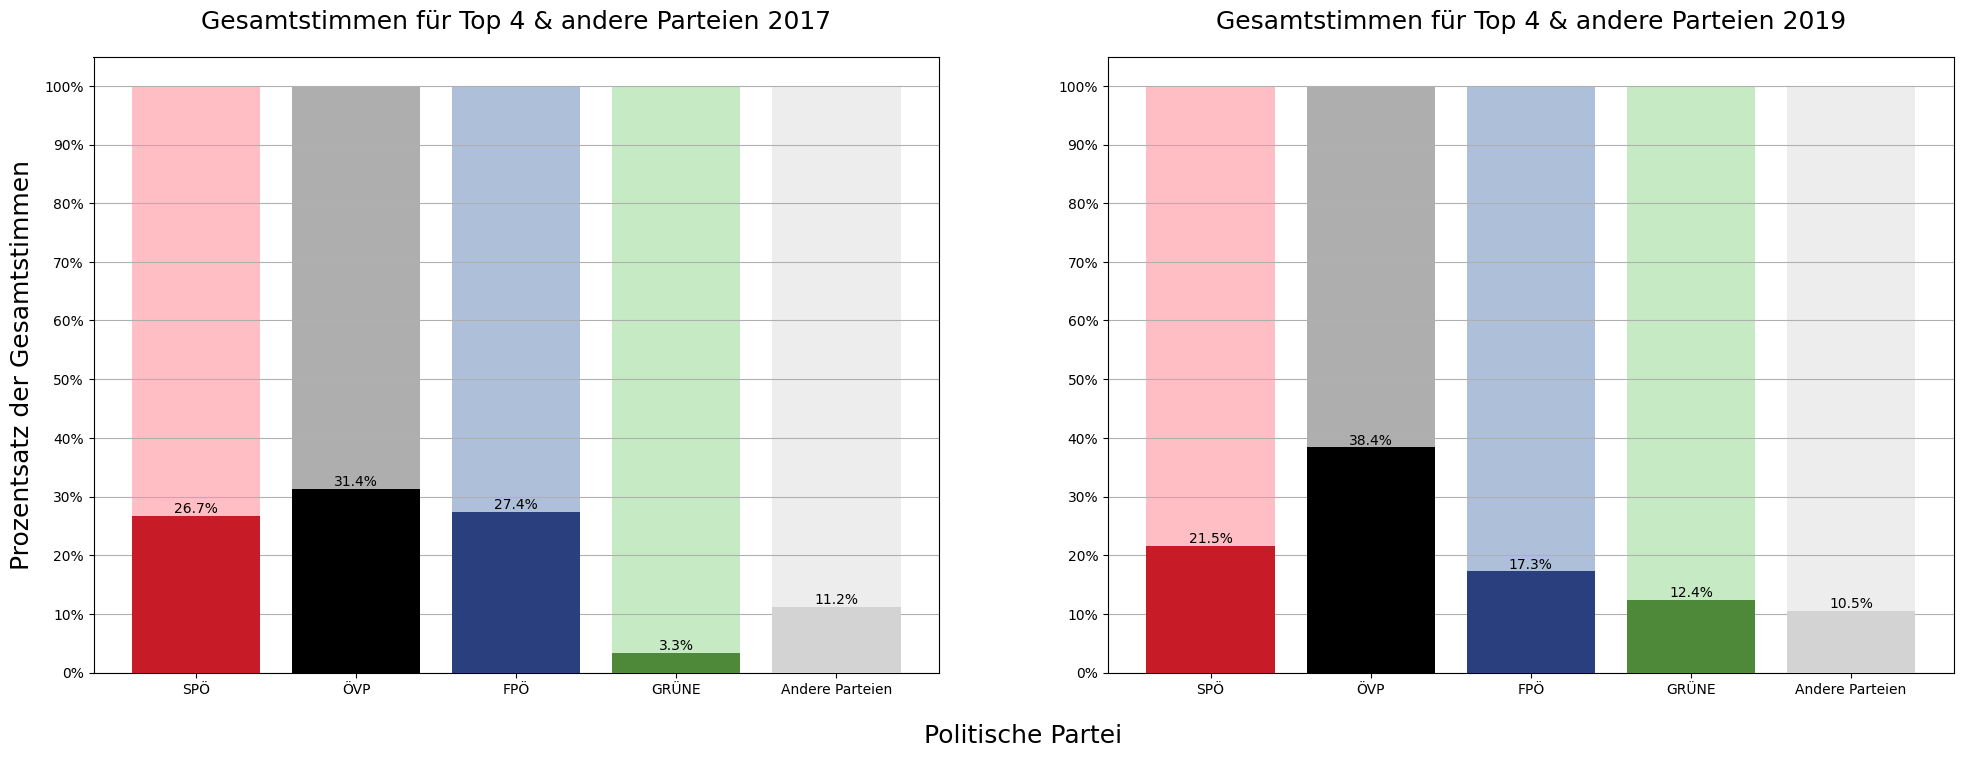

In [40]:
# common values
fontsize_title = 18
label_padding = 20
figure_width = 8
figure_height = 6

figure_size_horizontal = (figure_width*3, figure_height*(4/3))
figure_size_vertical = (figure_width, figure_height)

# choose one comment the other out.
#plot_political_party_votes_vertical(fontsize_title, label_padding, figure_size_vertical)
plot_political_party_votes_horizontal(fontsize_title, label_padding, figure_size_horizontal)

Wir sehen das die klare Rangordnung der Parteien in den Jahren 2017 und 2019 wie folgt ist:

Jahr 2017:

1. ÖVP
2. FPÖ
3. SPÖ
4. Alle Anderen Parteien zusammen
5. GRÜNE


Jahr 2019:

1. ÖVP
2. SPÖ
3. FPÖ
4. GRÜNE
5. Alle Anderen Parteien zusammen

###Verteilung der Parteien per Bundesland

####Datenaufbereitung für die Visualisierung der Parteiverteilung per Bundesland

Dieser Code-Abschnitt fügt eine neue Spalte "Bundesland" hinzu, indem die GCD-Werte durch die entsprechenden österreichischen Bundesländer ersetzt werden. Die DataFrames "election_indicators_2017" und "election_indicators_2019" werden durch die Funktion "replace_gcd_with_bundesland" bearbeitet.

Anschließend werden die Gesamtstimmenzahlen und der prozentuale Anteil jeder politischen Partei nach Bundesländern für die beiden Nationalratswahlen 2017 und 2019 gruppiert und aggregiert. Die neuen Spalten "Andere Parteien" und "Andere Parteien (%)" werden hinzugefügt und die Ergebnisse werden mit "display" ausgegeben. Zum Schluss wird die Option für die maximale Anzahl von Spalten zurückgesetzt, um alle Spalten im DataFrame anzuzeigen.

In [41]:
#This dictionary maps the GCD (Gemeindekennzahl) prefix string to the corresponding federal state in Austria.
gcd_to_bundeslaender = {"G1":"Burgenland", "G2": "Kärnten", "G3": "Niederösterreich", "G4": "Oberösterreich", "G5": "Salzburg", "G6": "Steiermark", "G7":"Tirol", "G8":"Vorarlberg", "G9": "Wien"}

In [42]:
# create copies of the original dataframe
# extended denotes additional columns, such as "Bundesland".
election_indicators_2017_extended = election_indicators_2017.copy()
election_indicators_2019_extended = election_indicators_2019.copy()

In [43]:
def replace_gcd_with_bundesland(df):
  """
  This function replaces GCD values with their corresponding Bundesland names in the given DataFrame.
  
  Args:
      df (pandas.DataFrame): The DataFrame to modify.
  
  Returns:
      None
  """
  if "Bundesland" not in df.columns:
      df["Bundesland"] = ""
  else:
    print("The column 'Bundesland' already exists.")
  for i, row in df.iterrows():
    gcd_value = row["GCD"]
    gcd_prefix = gcd_value[:2]
    if gcd_prefix in gcd_to_bundeslaender:
        df.at[i, "Bundesland"] = gcd_to_bundeslaender[gcd_prefix]
    else:
        df.at[i, "Bundesland"] = gcd_value

In [44]:
replace_gcd_with_bundesland(election_indicators_2017_extended)
replace_gcd_with_bundesland(election_indicators_2019_extended)

In [45]:
pd.set_option('display.max_columns', None) # Set max columns to None to display all columns
relevant_columns = ["GCD", "Gemeindename", "Bundesland"]
display(election_indicators_2017_extended[relevant_columns].head(3))
display(election_indicators_2017_extended[relevant_columns].tail(3))

GCD                    Gemeindename  Bundesland
0  G10101                      Eisenstadt  Burgenland
1  G10201                            Rust  Burgenland
2  G10301  Breitenbrunn am Neusiedler See  Burgenland

GCD      Gemeindename Bundesland
2119  G92101  Wien-Floridsdorf       Wien
2120  G92201   Wien-Donaustadt       Wien
2121  G92301      Wien-Liesing       Wien

In [46]:
display(election_indicators_2019_extended[relevant_columns].head(3))
display(election_indicators_2019_extended[relevant_columns].tail(3))

GCD                    Gemeindename  Bundesland
0  G10101                      Eisenstadt  Burgenland
1  G10201                            Rust  Burgenland
2  G10301  Breitenbrunn am Neusiedler See  Burgenland

GCD      Gemeindename Bundesland
2115  G92101  Wien-Floridsdorf       Wien
2116  G92201   Wien-Donaustadt       Wien
2117  G92301      Wien-Liesing       Wien

In [47]:
# create new columns showing other parties count in votes and percentage
election_indicators_2017_extended["Andere Parteien"] = election_indicators_2017_extended["Gültige"] - (election_indicators_2017_extended["SPÖ"] + election_indicators_2017_extended["ÖVP"] + election_indicators_2017_extended["FPÖ"] + election_indicators_2017_extended["GRÜNE"])
election_indicators_2017_extended["Andere Parteien (%)"] = election_indicators_2017_extended["Andere Parteien"]/election_indicators_2017_extended["Gültige"]
election_indicators_2019_extended["Andere Parteien"] = election_indicators_2019_extended["Gültige"] - (election_indicators_2019_extended["SPÖ"] + election_indicators_2019_extended["ÖVP"] + election_indicators_2019_extended["FPÖ"] + election_indicators_2019_extended["GRÜNE"])
election_indicators_2019_extended["Andere Parteien (%)"] = election_indicators_2019_extended["Andere Parteien"]/election_indicators_2019_extended["Gültige"]

In [48]:
display(election_indicators_2017_extended["Andere Parteien"].head(3))
display(election_indicators_2017_extended["Andere Parteien (%)"].head(3))

0    779
1     74
2    128
Name: Andere Parteien, dtype: int64

0    0.104117
1    0.066847
2    0.108108
Name: Andere Parteien (%), dtype: float64

In [49]:
display(election_indicators_2019_extended["Andere Parteien"].head(3))
display(election_indicators_2019_extended["Andere Parteien (%)"].head(3))

0    731
1     76
2    122
Name: Andere Parteien, dtype: int64

0    0.102755
1    0.073288
2    0.109910
Name: Andere Parteien (%), dtype: float64

Wir können jetzt klar und deutlich sehen welche Partei in welchem Bundesland, wie viele Stimmen und welchen Anteil an Stimmen bekommen habe.

####Visualisierung der Parteiverteilung per Bundesland

In diesem Code-Abschnitt werden gestapelte Balkendiagramme für die Verteilung der Stimmen für jede politische Partei pro Bundesland für die Nationalratswahlen 2017 und 2019 erstellt. Zunächst werden die Mittelwerte der prozentualen Anteile jeder Partei für jedes Bundesland berechnet und in DataFrames df2017 und df2019 gespeichert. Dann wird die Funktion plot_bar definiert, die ein gestapeltes Balkendiagramm mit Seaborn erstellt. Die Balken für jede Partei werden übereinander gestapelt, und die y-Achsen-Ticks werden als Prozente formatiert. Am Ende wird die Funktion plot_bar auf die beiden DataFrames angewendet, um die Balkendiagramme für die Nationalratswahlen 2017 und 2019 zu erstellen.

In [50]:
election_results_2017_by_bundesland = election_indicators_2017_extended.groupby("Bundesland")[["SPÖ (%)", "ÖVP (%)", "FPÖ (%)", "GRÜNE (%)", "Andere Parteien (%)"]].mean()
election_results_2019_by_bundesland = election_indicators_2019_extended.groupby("Bundesland")[["SPÖ (%)", "ÖVP (%)", "FPÖ (%)", "GRÜNE (%)", "Andere Parteien (%)"]].mean()

In [51]:
def plot_bar(df, title, fontsize_title, ax):
  """
  Creates a stacked bar chart using Seaborn.

  Args:
      df (pandas.DataFrame): The DataFrame containing the data to plot.
      title (str): The title of the plot.
      fontsize_title (int): The fontsize of the plot title.
      ax (matplotlib.axes.Axes): The Axes object to plot the chart onto.

  Returns:
      None
  """
  sns.set_style("whitegrid")
  alpha = 0.6

  sns.barplot(data=df, x=df.index, y='SPÖ (%)', color=political_colors["SPÖ"], label="SPÖ", alpha=alpha, ax=ax)
  sns.barplot(data=df, x=df.index, y='ÖVP (%)', color=political_colors["ÖVP"], label="ÖVP", bottom=df['SPÖ (%)'], alpha=alpha, ax=ax)
  sns.barplot(data=df, x=df.index, y='FPÖ (%)', color=political_colors["FPÖ"], label="FPÖ", bottom=df['SPÖ (%)'] + df['ÖVP (%)'], alpha=alpha, ax=ax)
  sns.barplot(data=df, x=df.index, y='GRÜNE (%)', color=political_colors["GRÜNE"], label="GRÜNE", bottom=df['SPÖ (%)'] + df['ÖVP (%)'] + df['FPÖ (%)'], alpha=alpha, ax=ax)
  sns.barplot(data=df, x=df.index, y='Andere Parteien (%)', color=political_colors["Andere Parteien"], label="Andere Parteien", bottom=df['SPÖ (%)'] + df['ÖVP (%)'] + df['FPÖ (%)'] + df['GRÜNE (%)'], alpha=alpha, ax=ax)
  
  # Apply a lambda function to format the y-axis ticks as percentages
  ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.0%}'.format(x)))

  # Add the bar labels
  for container in ax.containers:
      for i, bar in enumerate(container):
          x = bar.get_x() + bar.get_width() / 2
          y = bar.get_y() + bar.get_height() / 2
          label = '{:.0f}%'.format(bar.get_height() * 100)
          ax.text(x, y, label, ha='center', va='center', fontsize=10, color='white')
          # Move the x-axis labels slightly to the left

  # Set the position of the x-tick labels
  ax.set_xticklabels(df.index, rotation=45, ha="right")

  ax.set_title(title, fontsize=fontsize_title)

In [52]:
fontsize_title = 16

def plot_party_distribution_to_federal_state_vertical():
  """
  Plots the distribution of votes for each political party by federal state vertically using stacked bar charts.

  Args:
      None

  Returns:
      None
  """
  # Create a figure with two subplots
  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 12))
  
  # Plot the stacked bar charts for each year using the plot_bar function
  plot_bar(election_results_2017_by_bundesland, "Parteiverteilung per Bundesland 2017", fontsize_title, axes[0])
  plot_bar(election_results_2019_by_bundesland, "Parteiverteilung per Bundesland 2019", fontsize_title, axes[1])

  # Add y-axis labels to the subplots
  axes[0].set_ylabel("Wahlstimmen (Prozent)", fontsize=fontsize_title)
  axes[1].set_ylabel("Wahlstimmen (Prozent)", fontsize=fontsize_title)
  
  # Remove the x-axis label for the top subplot
  axes[0].set_xlabel("")
  
  # Add an x-axis label for the bottom subplot
  axes[1].set_xlabel("Bundesland", fontsize=fontsize_title)
  
  # Create a list of legend handles with the desired colors
  legend_handles = [Patch(facecolor=color, edgecolor="k", label=label) for label, color in political_colors.items()]

  # Add the legend with the custom handles and labels
  plt.legend(handles=legend_handles, bbox_to_anchor=(0.5, -0.4), loc='upper center', borderaxespad=0)
  
  # Adjust the layout and display the plot
  plt.tight_layout()
  plt.show()

In [53]:
fontsize_title = 16
def plot_party_distribution_to_federal_state_horizontal():
  """
  Plots the distribution of votes for each political party by federal state horizontally using stacked bar charts in a horizontal layout.

  Args:
      None

  Returns:
      None
  """
  # Create a figure with two subplots
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)
  
  # Plot the stacked bar charts for each year using the plot_bar function
  plot_bar(election_results_2017_by_bundesland, "Parteiverteilung per Bundesland 2017", fontsize_title, axes[0])
  plot_bar(election_results_2019_by_bundesland, "Parteiverteilung per Bundesland 2019", fontsize_title, axes[1])

  # Add x-axis labels to the subplots
  axes[0].set_xlabel("Bundesland", fontsize=fontsize_title)
  axes[1].set_xlabel("Bundesland", fontsize=fontsize_title)
  
  # Add y-axis labels to the subplots
  axes[0].set_ylabel("Wahlstimmen (Prozent)", fontsize=fontsize_title)
  axes[1].set_ylabel("")
  
  # Create a list of legend handles with the desired colors
  legend_handles = [Patch(facecolor=color, edgecolor="k", label=label) for label, color in political_colors.items()]

  # Add the legend with the custom handles and labels
  plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
  
  # Adjust the layout and display the plot
  plt.tight_layout()
  plt.show()

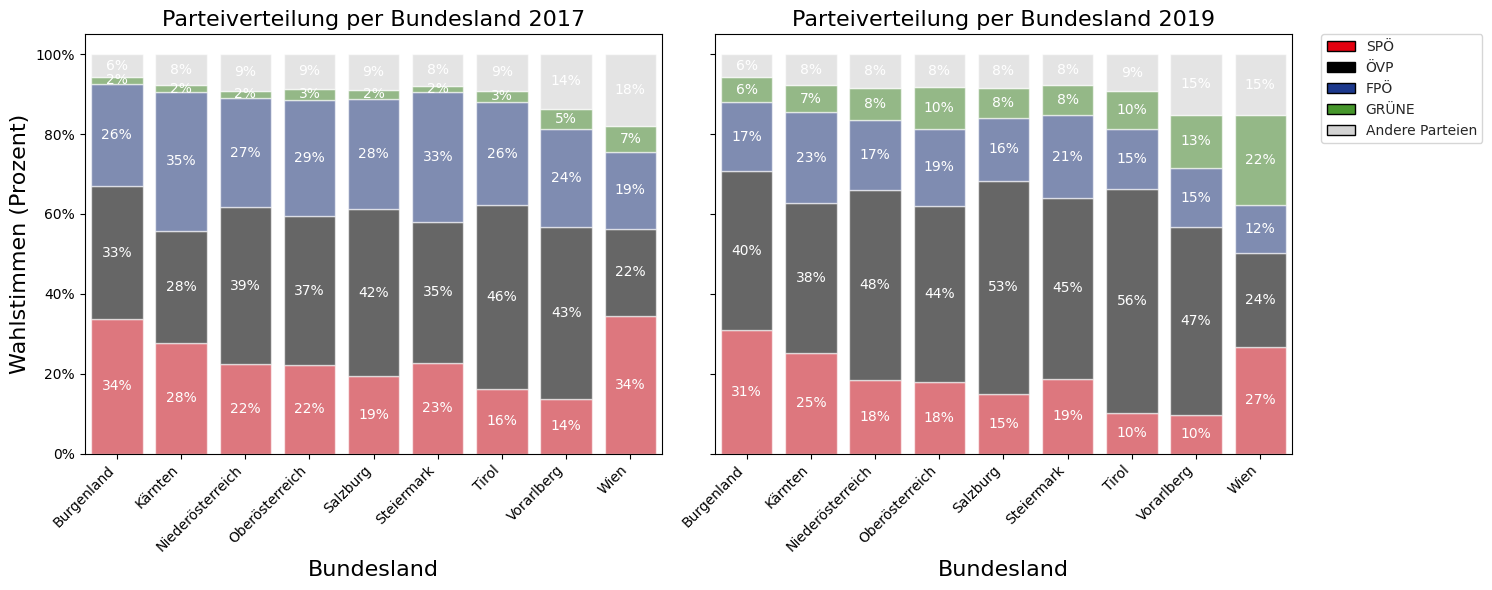

In [54]:
# choose one comment the other out
plot_party_distribution_to_federal_state_horizontal()
#plot_party_distribution_to_federal_state_vertical()

Wir können die Parteiverteilung per Bundesland klar und mit adequatem detail erkennen.

Im Jahre 2017:
1. Burgenland und Wien haben die höchsten prozentualen Werte für die SPÖ.
2. Tirol, Voralberg und Salzburg haben die höchsten Werte für die ÖVP.
3. Kárnten und Steiermark haben die höchsten Werte für die FPÖ.
4. Die Grünen und Andere Parteien haben die höchsten Anteile in Wien und Voralberg bekommen.

Im Jahre 2019:
1. Burgenland hat den höchsten prozentualen Wert für die SPÖ.
2. Wien hat den höchsten prozentualen Wert für die Grünen.
3. Tirol, Voralberg und Salzburg haben die höchsten Werte für die ÖVP.
4. Die FPÖ hat den höchsten Anteil in Kärnten und Steiermark bekommen.

###Visualisierung der Gemeindeanzahl per Bundesland

In diesem Code-Abschnitt wird ein Dictionary bundesland_colors erstellt, das Farbcodes für jedes Bundesland in Österreich enthält.

Dann werden zwei DataFrames df2017_gemeindename und df2019_gemeindename erstellt, die die Anzahl der Gemeinden pro Bundesland für die Nationalratswahlen 2017 bzw. 2019 enthalten.

Die Funktion plot_gemeinden_per_bundesland(df) wird definiert, um ein verteiltes Histogramm der Anzahl der Gemeinden pro Bundesland mit Seaborn zu plotten.

Die Funktion verwendet das bundesland_colors-Dictionary, um jedem Bundesland eine Farbe zuzuweisen.

Es wird eine Schleife durchgeführt, um die Höhe jeder Balkenpatch zu beschriften.

Schließlich werden die plot_gemeinden_per_bundesland-Funktion auf die DataFrames election_indicators_2017 und election_indicators_2019 angewendet, um ein verteiltes Histogramm für jede Wahl zu erstellen.

In [55]:
# Create a dictionary with the abbreviations of the Bundesländer in Austria
bundesland_abbrev = {
    "Burgenland": "B",
    "Kärnten": "K",
    "Niederösterreich": "NÖ",
    "Oberösterreich": "OÖ",
    "Salzburg": "S",
    "Steiermark": "ST",
    "Tirol": "T",
    "Vorarlberg": "V",
    "Wien": "W"
}

# Create a dictionary with the colors of the Bundesländer in Austria
bundesland_colors = {
    "Burgenland": "#8B0000",     # Red
    "Kärnten": "#FFA500",        # Orange
    "Niederösterreich": "#00008B", # Dark blue
    "Oberösterreich": "#ADD8E6", # Light blue
    "Salzburg": "#800080",       # Purple
    "Steiermark": "#008000",     # Green
    "Tirol": "#A52A2A",          # Brown
    "Vorarlberg": "#FFFF00",     # Yellow
    "Wien": "#FF0000"            # Red
}

In [56]:
count_communities_by_bundesland_2017 = election_indicators_2017_extended.groupby("Bundesland")[["Gemeindename"]].count()
count_communities_by_bundesland_2019 = election_indicators_2019_extended.groupby("Bundesland")[["Gemeindename"]].count()

In [57]:
def plot_gemeinden_per_bundesland_subplot(df, year, ax, show_legend):
  """
  Create a barplot of the number of municipalities in each Austrian state for a given year.

  Args:
  - df: pandas DataFrame with columns "Bundesland" and "Gemeindename"
  - year: str, year for the DataFrame
  - ax: matplotlib Axes object, the subplot to plot on
  - show_legend: bool, whether or not to show the legend

  Returns:
  None
  """
  alpha = 0.5
  # Create the barplot
  sns.barplot(data=df, x=df.index, y="Gemeindename", palette=bundesland_colors.values(), alpha=alpha, ax=ax)

  # Set x- and y-axis labels and title
  ax.set_ylabel("Anzahl Gemeinden", fontweight='bold')
  ax.set_xlabel("Bundesland", fontweight='bold')
  ax.set_title("Anzahl der Gemeinden per Bundesland " + year, fontweight='bold', pad=12)

  # convert full names to abbreviations for x-axis tick labels
  tick_labels = [bundesland_abbrev[name] for name in df.index.unique()]
  ax.set_xticklabels(labels=tick_labels, rotation=0, ha="center", va="center")

  # add value labels to each bar
  for patch in ax.patches:
      if patch.get_height() != 0:
          xytext = (0, 5)
          ax.annotate(format(patch.get_height(), '.0f'), (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                        ha='center', va='center', xytext=xytext, textcoords='offset points')
  
  # Add legend if show_legend is True
  if show_legend:
    # Create a list of legend handles with the desired colors
    legend_handles = [Patch(facecolor=color, linewidth=0, alpha=alpha, label=bundesland_abbrev[bundesland] + ": " + bundesland) for bundesland, color in bundesland_colors.items()]
    # Add the legend with the custom handles and labels
    ax.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title="Bundesländer")

In [58]:
def plot_gemeinden_per_bundesland(df1, df2, year1, year2, orientation="horizontal"):
  """
  Plot the number of municipalities per state for two different years.

  Parameters:
  df1 (pandas.DataFrame): DataFrame containing the data for the first year
  df2 (pandas.DataFrame): DataFrame containing the data for the second year
  year1 (str): Year for the first data set
  year2 (str): Year for the second data set
  orientation (str): Orientation of the subplots. Can be 'horizontal' or 'vertical'. Default is 'horizontal'.

  Returns:
  None
  """
  # Create a figure with two subplots according to "orientation"
  if orientation == "horizontal":
    fig, axs = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
  elif orientation == "vertical":
    fig, axs = plt.subplots(nrows=2, figsize=(8, 12))
  else:
    return
  # Plot the data for each year
  plot_gemeinden_per_bundesland_subplot(df1, year1, axs[0], (orientation == "vertical"))
  plot_gemeinden_per_bundesland_subplot(df2, year2, axs[1], True)

  plt.show()


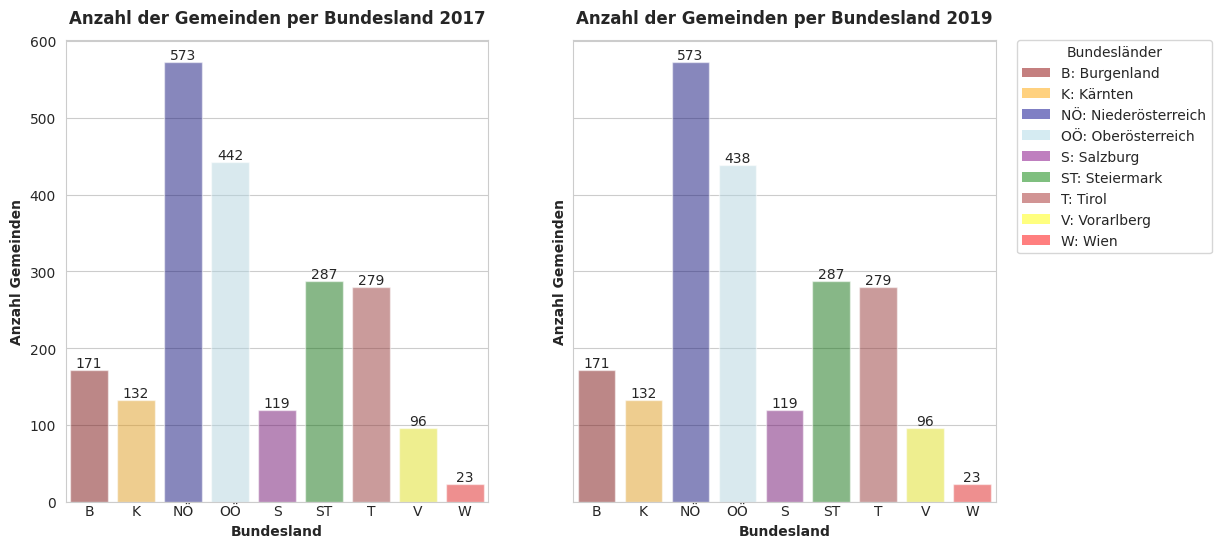

In [59]:
orientations = ["horizontal", "vertical"]
# choose an orientation from above list by indexing.
plot_gemeinden_per_bundesland(count_communities_by_bundesland_2017, count_communities_by_bundesland_2019, "2017", "2019", orientation=orientations[0])

Niederösterreich und Oberöstereich haben die höchste Anzahl an Gemeinden, wobei wir bei Oberösterreich eine reduktion an 4 Gemeinden feststellen können.

###Verteilung der Indikatoren per Bundesland

Die Diagramme zeigen die Durchschnittswerte verschiedener Indikatoren für jedes österreichische Bundesland im Jahr 2017 und 2019. Die Indikatoren sind Ausländische Staatsbürger, Bevölkerung > 65, Erwerbstätige, Arbeitslose, Sekundarabschluss und Tertiärabschluss.

Die Balken in den Diagrammen repräsentieren die Durchschnittswerte für jedes Bundesland. Die Balken sind farbcodiert, um jedes Bundesland zu repräsentieren, und sie sind beschriftet mit dem Namen des Bundeslandes oder der Abkürzung, wenn sie nicht auf der untersten Reihe dargestellt werden. An jeder Balkenspitze befindet sich ein numerischer Wert, der den Durchschnittswert des jeweiligen Indikators für das Bundesland darstellt.

In [60]:
# Define the list of population pharacteristics columns
population_characteristics = ["Ausländische Staatsbürger (%)", "Bevölkerung > 65 (%)", "Erwerbstätige (%)", "Arbeitslose (%)", "Sekundarabschluss (%)", "Tertiärabschluss (%)"]

In [61]:
population_chars_by_bundesland_2017 = election_indicators_2017_extended.groupby("Bundesland")[population_characteristics].mean()
population_chars_by_bundesland_2019 = election_indicators_2019_extended.groupby("Bundesland")[population_characteristics].mean()

In [62]:
# Define the order of the hue variable (Bundesland)
hue_order = gcd_to_bundeslaender.values()

In [63]:
def plot_singlge_population_characteristic_by_bundesland(df, df_column, year, ax, fig_col, fig_row):
  """
  Plot the barplot for a given population_characteristic for a given year and Bundesland

  Args:
  - df: the dataframe of volkmerkmale for a given year and Bundesland
  - df_column: the name of the column to plot
  - year: the year of the plot
  - ax: the axes object to plot on
  - fig_col: the column index of the plot in the figure
  - fig_row: the row index of the plot in the figure
  """
  sns.set_style("darkgrid")
  alpha = 0.6
  plot = sns.barplot(data=df, x=df.index, y=df_column, hue_order=hue_order, palette=bundesland_colors, alpha=alpha, ax=ax[fig_row, fig_col])
  
  #set the y-axis limit to 100
  plot.set(ylim=(0, 100))

  # set the title and y-axis label
  plot.set_title(df_column.replace(" (%)", "") + " " + "(" + year +")", fontsize=12, fontweight="bold")

  # Abbreviate the Bundesland names
  plot.set_xticklabels([bundesland_abbrev[b] for b in df.index], rotation=0)

  plot.set_xlabel('')  # Remove x-axis label

  if fig_col == 0:
    plot.set_ylabel(df_column, fontweight="bold")
  else:
    plot.set_ylabel('')  # Remove y-axis label

  # add value labels to each bar
  for patch in plot.patches:
      if patch.get_height() != 0:
          xytext = (0, 5)
          ax[fig_row][fig_col].annotate(format(patch.get_height(), '.1f') + '%', (patch.get_x() + patch.get_width() / 2, patch.get_height()),
                        ha='center', va='center', xytext=xytext, textcoords='offset points', fontsize=8)
  
  # Create a legend with the custom handles and labels for the Bundesland colors
  handles = [Patch(facecolor=color, alpha=alpha, label=bundesland_abbrev[bundesland]+ ": " + bundesland) for bundesland, color in bundesland_colors.items()]
  
  # Add the legend to the top and bottom of the figure
  fig.legend(handles=handles, bbox_to_anchor=(0.5, 1.02), loc='upper center', ncol=len(bundesland_colors), title="Bundesländer")
  fig.legend(handles=handles, bbox_to_anchor=(0.5, 0.02), loc='lower center', ncol=len(bundesland_colors), title="Bundesländer")

In [64]:
def plot_population_characteristics_by_state(df, population_characteristics, year, ax, fig_col):
  """
  Plot the specified volkmerkmale for each Bundesland in the given DataFrame.

  Parameters:
  df (pandas.DataFrame): DataFrame containing the data to plot
  volkmerkmale (list): List of strings containing the names of the volkmerkmale to plot
  year (str): String representing the year of the data to plot
  ax (matplotlib.axes.Axes): Axes object to plot the data on
  fig_col (int): Index of the column of the figure in which to plot the data

  Returns:
  None
  """
  for i, merkmal in enumerate(population_characteristics):
    # Call plot_volkmerkmal_bundesland() to plot the data for each volkmerkmal
    plot_singlge_population_characteristic_by_bundesland(df, merkmal, year, ax, fig_col, i)

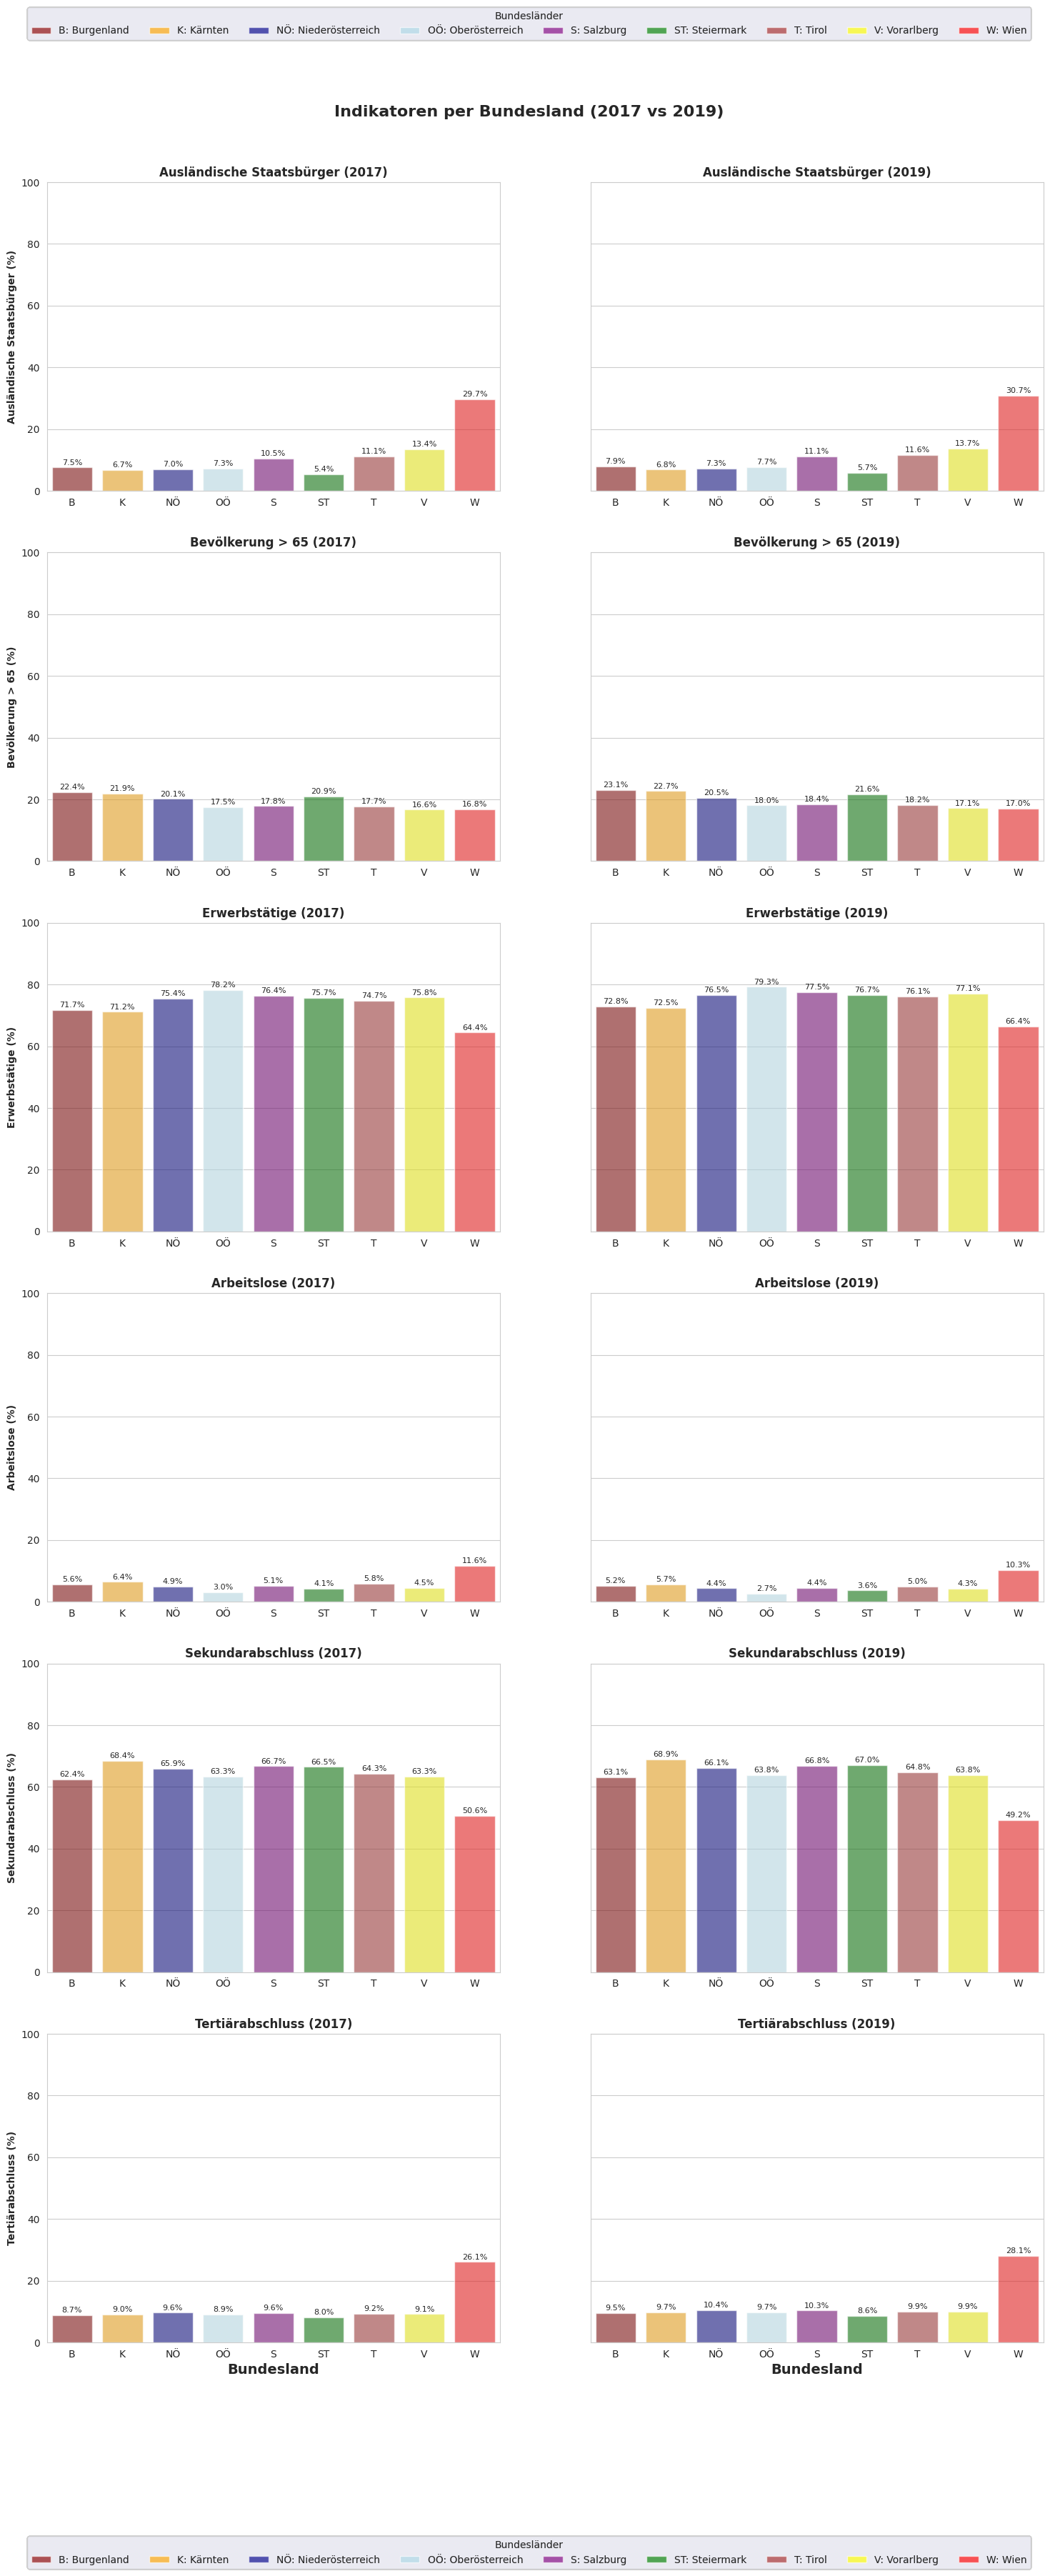

In [65]:
# Create a figure with subplots for each volkmerkmal and year
nrows = len(population_characteristics)
fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize=(18, 36), sharex=False, sharey="row", gridspec_kw={"top": 0.95})

# Set the figure title
fig.suptitle("Indikatoren per Bundesland (2017 vs 2019)", fontsize=16, fontweight="bold")

# Plot the volkmerkmale for 2017 and 2019 on separate columns
plot_population_characteristics_by_state(population_chars_by_bundesland_2017, population_characteristics, "2017", ax, 0)
plot_population_characteristics_by_state(population_chars_by_bundesland_2019, population_characteristics, "2019", ax, 1)

# Set the x-axis label for the last row of subplots
ax[-1, 0].set_xlabel("Bundesland", fontsize=14, fontweight="bold")
ax[-1, 1].set_xlabel("Bundesland", fontsize=14, fontweight="bold")

plt.show()

Die Anzahl der Ausländer ist ungefähr doppelt bis viermal so groß in Wien im Vergleich zu den anderen Bundesländern.

Der Unterschied von Bevölkerungsalter über 65 von Bundesland zu Bundesland ist maximal 6-7%. Wir können jedoch eine ältere Population feststellen, von 2017 zu 2019.

Der prozentuale Anteil an Erwerbstätigen ist in Wien am niedrigsten mit 66.4%.

Der prozentuale Anteil von Arbeitslosen ist in Wien am höchsten mit einem Unterschied von einem Faktor von 5 im Vergleich zu OÖ.

Der Sekundarabschluss ist am niedrigsten in Wien mit ungefähr 50 %.

Der Tertiärabschluss ist am höchsten in Wien. Der Unterschied beträgt ungefähr einen Faktor von 3 zu den anderen Bundesländern.

##Verlauf der einzelnen Indikatoren

In [66]:
display(indicators)

Jahr     GCD                    Gemeindename  Bevölkerung (Abs.)  \
0      2011  G10101                      Eisenstadt               13101   
1      2011  G10201                            Rust                1896   
2      2011  G10301  Breitenbrunn am Neusiedler See                1902   
3      2011  G10302                  Donnerskirchen                1742   
4      2011  G10303                     Großhöflein                1929   
...     ...     ...                             ...                 ...   
22226  2020  G91901                    Wien-Döbling               73719   
22227  2020  G92001                Wien-Brigittenau               85184   
22228  2020  G92101                Wien-Floridsdorf              172756   
22229  2020  G92201                 Wien-Donaustadt              197869   
22230  2020  G92301                    Wien-Liesing              111301   

       Bevölkerung < 15 (%)  Bevölkerung > 65 (%)  \
0                      13.8                  18.2   
1                      13.8                  22.2   
2                      12.1                  22.4   
3                      12.3                  20.2   
4                      12.9                  17.0   
...                     ...                   ...   
22226                  13.8                  22.0   
22227                  14.3                  15.5   
22228                  16.5                  16.6   
22229                  16.7                  15.3   
22230                  16.1                  19.6   

       Ausländische Staatsbürger (%)  Erwerbstätige (%)  Arbeitslose (%)  \
0                                9.4               70.9              4.3   
1                                4.7               74.9              3.2   
2                                5.6               71.2              3.7   
3                                3.8               71.5              4.3   
4                                3.4               72.9              3.8   
...                              ...                ...              ...   
22226                           26.0               64.4             10.7   
22227                           39.0               60.3             17.9   
22228                           26.3               64.6             15.3   
22229                           22.5               67.6             11.7   
22230                           21.6               68.7             11.4   

       Sekundarabschluss (%)  Tertiärabschluss (%)  Auspendler (%)  \
0                       59.5                  18.7            43.6   
1                       61.4                   7.6            62.4   
2                       62.4                  10.7            78.6   
3                       66.1                   7.1            76.4   
4                       61.9                  10.3            85.7   
...                      ...                   ...             ...   
22226                   48.3                  33.7            10.4   
22227                   48.5                  18.4            12.0   
22228                   57.0                  14.5            12.2   
22229                   58.6                  18.0            10.6   
22230                   56.8                  20.1            16.1   

       Haushaltsgröße (Abs.)  Unternehmen (Abs.)  Unternehmen (pro Kopf)  
0                       2.15                1394                0.106404  
1                       2.33                 191                0.100738  
2                       2.18                 157                0.082545  
3                       2.37                 149                0.085534  
4                       2.42                 122                0.063245  
...                      ...                 ...                     ...  
22226                   1.98                7066                0.095850  
22227                   2.02                3864                0.045361  
22228                   2.12            

###Medianwerte




In [67]:
indic_g_n_jahr=indicators.drop('Gemeindename',axis=1).groupby('Jahr').median()
display(indic_g_n_jahr)

Bevölkerung (Abs.)  Bevölkerung < 15 (%)  Bevölkerung > 65 (%)  \
Jahr                                                                   
2011              1589.0                  14.8                  17.4   
2012              1591.0                  14.7                  17.8   
2013              1585.0                  14.6                  18.1   
2014              1588.0                  14.5                  18.4   
2015              1811.5                  14.6                  18.5   
2016              1828.0                  14.7                  18.7   
2017              1830.5                  14.7                  18.9   
2018              1833.0                  14.7                  19.2   
2019              1837.5                  14.7                  19.4   
2020              1841.0                  14.7                  19.8   

      Ausländische Staatsbürger (%)  Erwerbstätige (%)  Arbeitslose (%)  \
Jahr                                                                      
2011                            4.3              73.00              3.9   
2012                            4.5              73.20              4.1   
2013                            4.7              74.10              4.3   
2014                            5.0              74.40              4.5   
2015                            6.1              74.50              4.6   
2016                            6.5              74.90              4.5   
2017                            6.6              75.95              4.1   
2018                            6.7              76.70              3.7   
2019                            6.9              77.10              3.6   
2020                            7.0              75.70              4.3   

      Sekundarabschluss (%)  Tertiärabschluss (%)  Auspendler (%)  \
Jahr                                                                
2011                   63.2                  6.50            74.9   
2012                   63.6                  6.70            75.3   
2013                   63.8                  7.10            73.9   
2014                   64.1                  7.30            74.2   
2015                   64.7                  7.70            73.8   
2016                   64.9                  8.00            74.3   
2017                   65.3                  8.20            74.6   
2018                   65.5                  8.60            74.9   
2019                   65.7                  8.95            75.1   
2020                   65.9                  9.30            76.5   

      Haushaltsgröße (Abs.)  Unternehmen (Abs.)  Unternehmen (pro Kopf)  
Jahr                                                                     
2011                  2.550               122.0                0.077582  
2012                  2.530               122.0                0.076773  
2013                  2.510               121.0                0.076628  
2014                  2.500               124.0                0.077132  
2015                  2.470               138.0                0.074977  
2016                  2.460               137.0                0.075056  
2017                  2.435               145.5                0.079388  
2018                  2.430               148.0                0.080578  
2019                  2.410               150.0                0.081291  
2020                  2.400               149.0                0.081437

Die Bevölkerung ist die einzige Variable, die sich im Tausenderbereich bewegt, deswegen ist ein eigenes Diagram nötig.

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

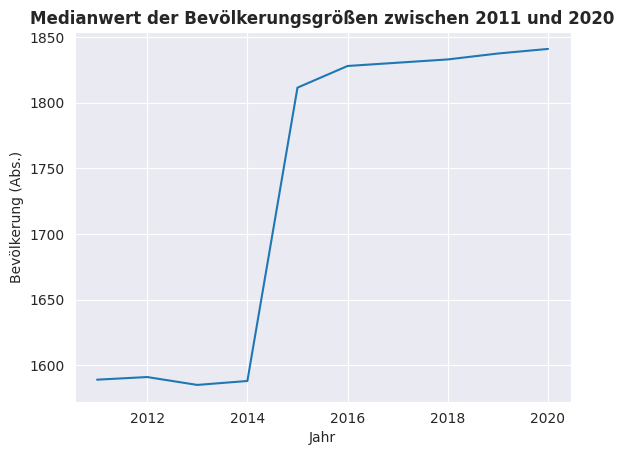

In [69]:
sns.lineplot(data=indic_g_n_jahr['Bevölkerung (Abs.)'])
plt.title('Medianwert der Bevölkerungsgrößen zwischen 2011 und 2020', fontweight = 'bold')
plt.show()

Der Sprung zwischen 2014 und 2015 kommt von Zusammenlegungen vieler Gemeinden, ersichtlich von der Anzahl der Gemeinden und dass manche Gemeindenamen nach 2015 nicht mehr aufgelistet sind.

Haushaltsgrößen bewegen sich im Bereich 2-3:

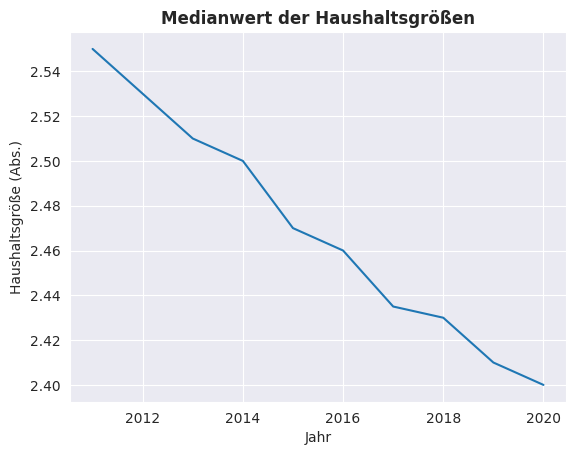

In [70]:
sns.lineplot(data=indic_g_n_jahr['Haushaltsgröße (Abs.)'])
plt.title('Medianwert der Haushaltsgrößen', fontweight = 'bold')
plt.show()

Die Entwicklung der Werte der restlichen (prozentualen) Variablen:

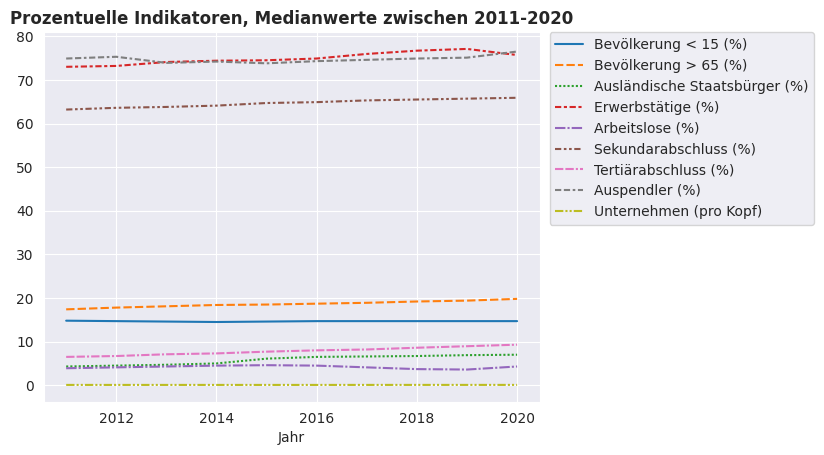

In [71]:
indic_g_n_jahr_pct=indic_g_n_jahr.drop(['Bevölkerung (Abs.)','Haushaltsgröße (Abs.)','Unternehmen (Abs.)'], axis=1)

pct=sns.lineplot(data=indic_g_n_jahr_pct)
plt.title('Prozentuelle Indikatoren, Medianwerte zwischen 2011-2020', fontweight = 'bold')
pct.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

###Alle Werte

####Bevölkerung

Histogram der Bevölkerungsgrößen 2020

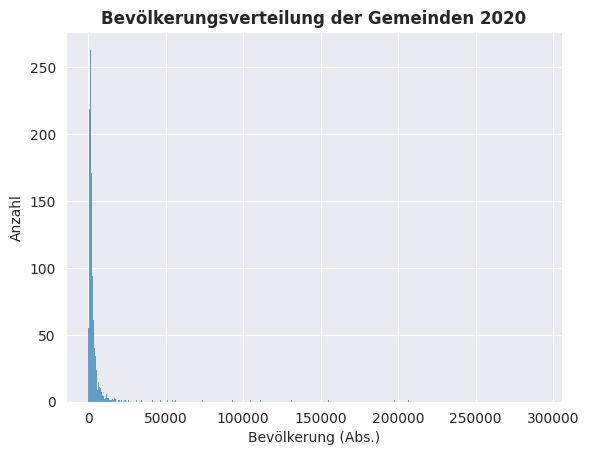

In [72]:
pop_2020 = sns.histplot(data=indicators.loc[indicators["Jahr"] == 2020]['Bevölkerung (Abs.)'])
pop_2020.set_title('Bevölkerungsverteilung der Gemeinden 2020', fontweight = 'bold')
pop_2020.set(ylabel='Anzahl')
plt.show()

Die Bevölkerungsgößen haben eine extrem assymetrische Verteilung, deswegen ist eine logarithmische X-Achse nötig.

Vergleich Boxplot und Histogram:

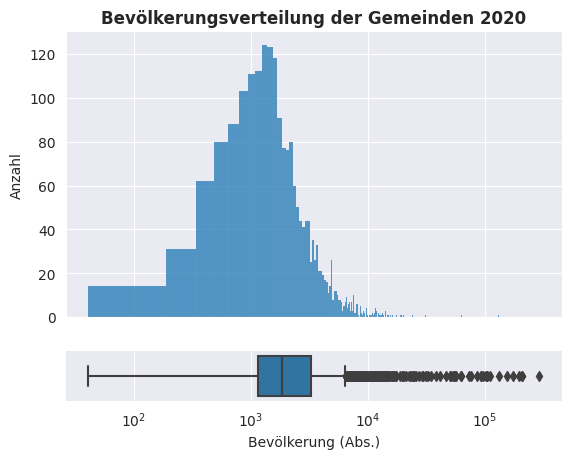

In [73]:
f, (ax_hist, ax_box) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.85, .15)})
x=indicators.loc[indicators["Jahr"] == 2020]['Bevölkerung (Abs.)']
sns.histplot(x=x, binwidth=150, ax=ax_hist)
sns.boxplot(x=x, ax=ax_box)
plt.xscale('log')
ax_hist.set_xlabel('')
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)
ax_hist.set_title('Bevölkerungsverteilung der Gemeinden 2020', fontweight = 'bold')
ax_hist.set(ylabel='Anzahl')
plt.show()

Entwicklung der Bevölkerungsgrößen im Verlauf der Jahre

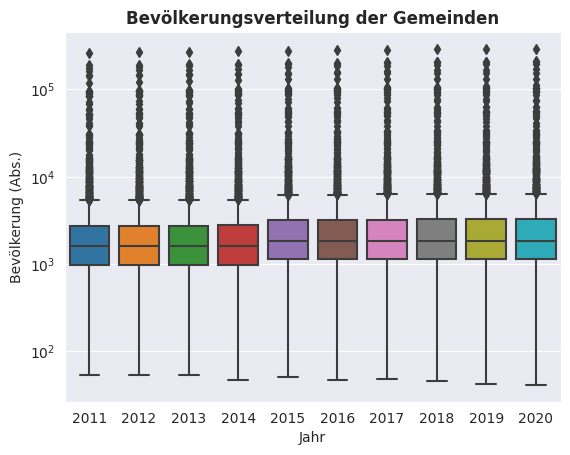

In [74]:
sns.boxplot(data=indicators, x='Jahr', y='Bevölkerung (Abs.)')
plt.yscale('log')
plt.title('Bevölkerungsverteilung der Gemeinden', fontweight = 'bold')
plt.show()

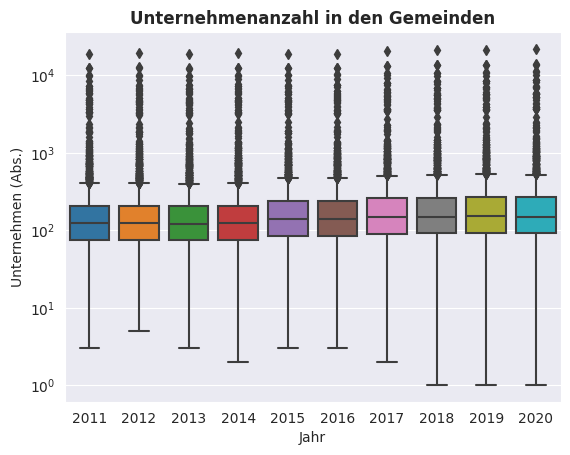

In [75]:
sns.boxplot(data=indicators, x='Jahr', y='Unternehmen (Abs.)')
plt.yscale('log')
plt.title('Unternehmenanzahl in den Gemeinden', fontweight = 'bold')
plt.show()

####Restliche Indikatoren

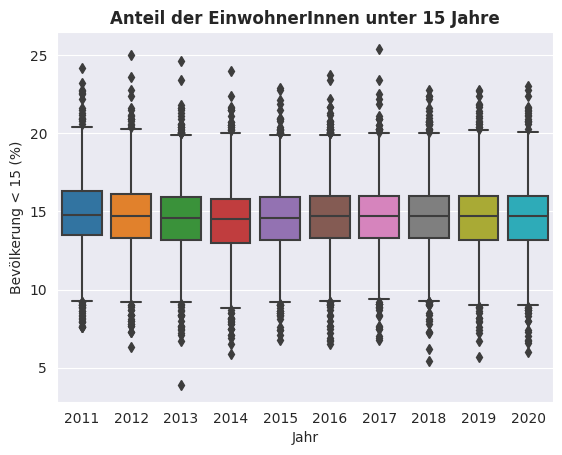

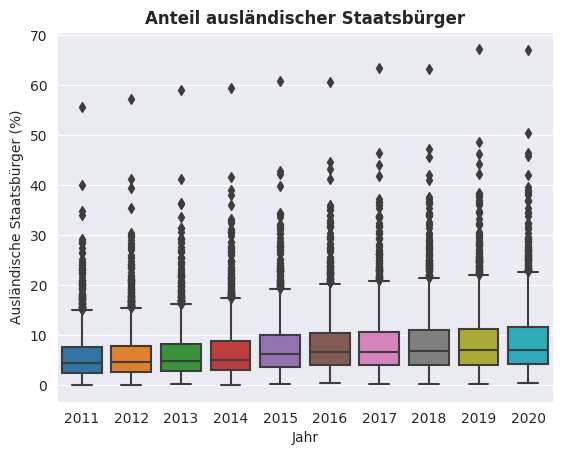

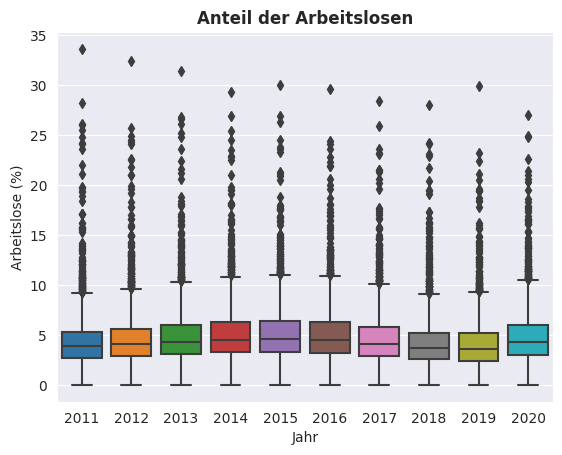

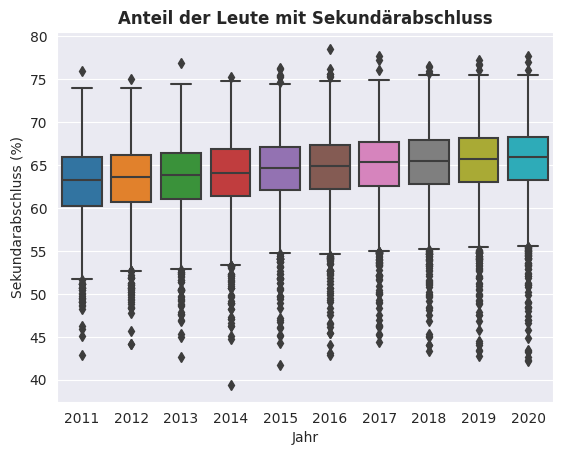

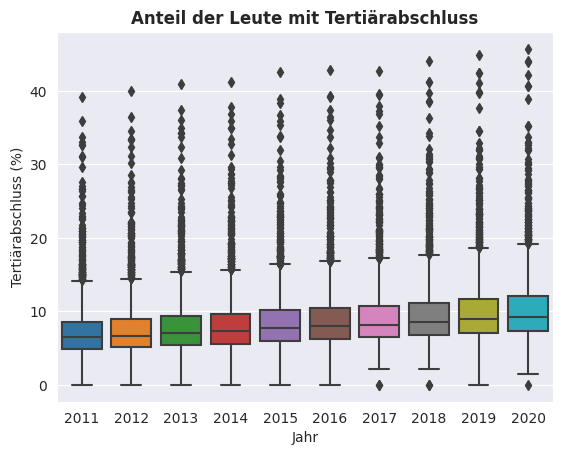

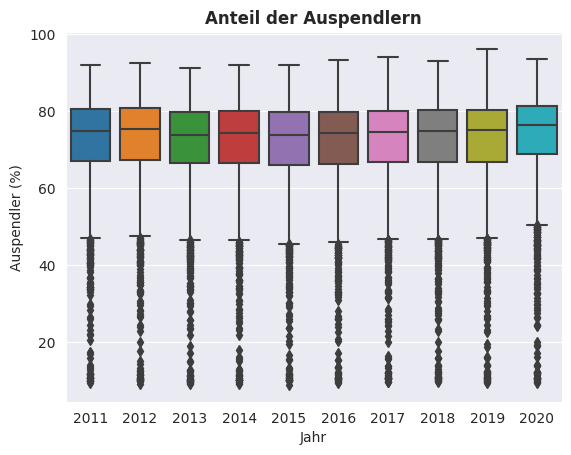

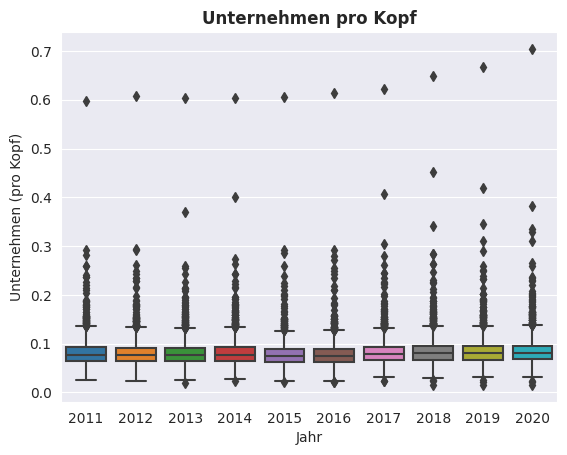

In [76]:
titles=['Anteil der EinwohnerInnen unter 15 Jahre',
        'Anteil der EinwohnerInnen über 65 Jahre',
        'Anteil ausländischer Staatsbürger',
        'Anteil der Erwerbstätige',
        'Anteil der Arbeitslosen',
        'Anteil der Leute mit Sekundärabschluss',
        'Anteil der Leute mit Tertiärabschluss',
        'Anteil der Auspendlern',
        'Unternehmen pro Kopf'
        ]
t=0
for column in indicators.drop(['Unternehmen (Abs.)','Haushaltsgröße (Abs.)'], axis=1).columns[4:]:
  ind = sns.boxplot(data=indicators, x='Jahr', y=column)
  ind.set_title(titles[t], fontweight = 'bold')
  t=t+1
  plt.show()

Bei diesen Indikatoren sind keine ruckartigen oder großen Schwankungen zu beobachten. Bei dem Großteil ist die Verteilung aber ziemlich breit.

# Korrelationen zwischen Indikatoren und Wahlergebnissen 2017

Um festzustellen welche Indikatoren starken Einfluß auf anderen Indikatoren oder Wahlergebnisse haben, werden mehrere Korrelationsmatrizen gebildet: Eine Korrelationsmatrix die Korrelationen zwischen Indikatoren abbildet, eine die Korrelationen zwischen Wahlergebnissen (Spalten) und Indikatoren (Zeilen) abbildet, und eine die Korrelationen zwischen Wahlergebnissen abbildet.

Die Werte der Korrelationsmatrix sind die Korrelationskoeffizienten. Sie nehmen Werte zwischen -1 und 1 an. Werte nahe - 1 bzw. 1 deuten auf eine starke lineare Korrelation hin (negativ bzw. positiv), Werte nahe 0 geben einen Hinweis darauf, dass kein linearer Zusammenhang besteht.

Es werden Korrelationsmatrizen für den Indikator-Datensatz, den Datensatz der Wahlergebnisse von 2017 und eine weitere Matrix, die den Zusammenhang zwischen den Wahlergebnissen und den Indikatoren zeigt, erstellt.

In [77]:
# correlation matrix for indicators
corr_indicators_2017 = indicators_2017.drop(columns=['GCD', 'Unternehmen (Abs.)']).set_index('Gemeindename').corr(method="pearson")
corr_indicators_2017.round(decimals=3)

Bevölkerung (Abs.)  Bevölkerung < 15 (%)  \
Bevölkerung (Abs.)                          1.000                -0.030   
Bevölkerung < 15 (%)                       -0.030                 1.000   
Bevölkerung > 65 (%)                       -0.057                -0.727   
Ausländische Staatsbürger (%)               0.384                -0.007   
Erwerbstätige (%)                          -0.249                 0.411   
Arbeitslose (%)                             0.251                -0.229   
Sekundarabschluss (%)                      -0.332                 0.082   
Tertiärabschluss (%)                        0.320                 0.031   
Auspendler (%)                             -0.464                 0.147   
Haushaltsgröße (Abs.)                      -0.255                 0.546   
Unternehmen (pro Kopf)                     -0.073                -0.069   

                               Bevölkerung > 65 (%)  \
Bevölkerung (Abs.)                           -0.057   
Bevölkerung < 15 (%)                         -0.727   
Bevölkerung > 65 (%)                          1.000   
Ausländische Staatsbürger (%)                -0.094   
Erwerbstätige (%)                            -0.389   
Arbeitslose (%)                               0.158   
Sekundarabschluss (%)                        -0.018   
Tertiärabschluss (%)                         -0.059   
Auspendler (%)                               -0.134   
Haushaltsgröße (Abs.)                        -0.468   
Unternehmen (pro Kopf)                        0.071   

                               Ausländische Staatsbürger (%)  \
Bevölkerung (Abs.)                                     0.384   
Bevölkerung < 15 (%)                                  -0.007   
Bevölkerung > 65 (%)                                  -0.094   
Ausländische Staatsbürger (%)                          1.000   
Erwerbstätige (%)                                     -0.484   
Arbeitslose (%)                                        0.382   
Sekundarabschluss (%)                                 -0.415   
Tertiärabschluss (%)                                   0.332   
Auspendler (%)                                        -0.399   
Haushaltsgröße (Abs.)                                 -0.435   
Unternehmen (pro Kopf)                                -0.019   

                               Erwerbstätige (%)  Arbeitslose (%)  \
Bevölkerung (Abs.)                        -0.249            0.251   
Bevölkerung < 15 (%)                       0.411           -0.229   
Bevölkerung > 65 (%)                      -0.389            0.158   
Ausländische Staatsbürger (%)             -0.484            0.382   
Erwerbstätige (%)                          1.000           -0.768   
Arbeitslose (%)                           -0.768            1.000   
Sekundarabschluss (%)                      0.238           -0.115   
Tertiärabschluss (%)                      -0.091            0.004   
Auspendler (%)                             0.316           -0.379   
Haushaltsgröße (Abs.)                      0.509           -0.357   
Unternehmen (pro Kopf)                     0.051            0.057   

                               Sekundarabschluss (%)  Tertiärabschluss (%)  \
Bevölkerung (Abs.)                            -0.332                 0.320   
Bevölkerung < 15 (%)                           0.082                 0.031   
Bevölkerung > 65 (%)                          -0.018                -0.059   
Ausländische Staatsbürger (%)                 -0.415                 0.332   
Erwerbstätige (%)                              0.238                -0.091   
Arbeitslose (%)                               -0.115                 0.004   
Sekundarabschluss (%)                          1.000                -0.401   
Tertiärabschluss (%)                          -0.401                 1.000   
Auspendler (%)                                 0.198                -0.111   
Haushaltsgröße (Abs.)                          0.209                -0.344   
Unternehmen (

In [78]:
# correlation matrix for election
corr_election_2017 = election_2017.drop(columns=['GCD', 'Gültige', 'SPÖ', 'ÖVP', 'FPÖ', 'GRÜNE']).set_index('Gebietsname').corr(method="pearson")
corr_election_2017.round(decimals=3)

SPÖ (%)  ÖVP (%)  FPÖ (%)  GRÜNE (%)
SPÖ (%)      1.000   -0.809   -0.122      0.049
ÖVP (%)     -0.809    1.000   -0.234     -0.203
FPÖ (%)     -0.122   -0.234    1.000     -0.545
GRÜNE (%)    0.049   -0.203   -0.545      1.000

In [79]:
# mixed correlation matrix
corr_election_indicators_2017 = election_indicators_2017.drop(columns=['GCD', 'Gültige', 'SPÖ', 'ÖVP', 'FPÖ', 'GRÜNE']).set_index('Gemeindename').corr(method="pearson").iloc[4:, :4]
corr_election_indicators_2017.round(decimals=3)

SPÖ (%)  ÖVP (%)  FPÖ (%)  GRÜNE (%)
Bevölkerung (Abs.)               0.179   -0.239   -0.069      0.246
Bevölkerung < 15 (%)            -0.341    0.211   -0.013      0.200
Bevölkerung > 65 (%)             0.338   -0.144   -0.061     -0.235
Ausländische Staatsbürger (%)    0.142   -0.201   -0.164      0.400
Erwerbstätige (%)               -0.383    0.308    0.044      0.018
Arbeitslose (%)                  0.193   -0.161   -0.025     -0.058
Sekundarabschluss (%)           -0.114    0.111    0.213     -0.410
Tertiärabschluss (%)             0.145   -0.203   -0.393      0.592
Auspendler (%)                   0.075   -0.091    0.147     -0.110
Haushaltsgröße (Abs.)           -0.523    0.517    0.058     -0.145
Unternehmen (Abs.)               0.157   -0.214   -0.121      0.297
Unternehmen (pro Kopf)          -0.353    0.395   -0.177     -0.022
Wahlbeteiligung                  0.053    0.140    0.032     -0.459

Im Folgenden werden Heatmaps generiert, die Korrelationsmatrizen gut veranschaulichen. Die "heißen" Teile der Heatmap (orange) stellen positive Korrelationen dar, während die "kalten" Teile (blau) negative Korrelationen darstellen.

In [80]:
def correlogram(corr, title=None, threshold=None, ax=None):
  """Plots a correlogram for a given correlation matrix."""
  
  # replace values below threshold with zero
  if (threshold != None):
    corr = corr.where(corr.abs() >= threshold, 0)

  # style
  sns.set_theme(style="white")

  # custom diverging colormap
  cmap = sns.diverging_palette(230, 20, as_cmap=True)

  # heatmap with correct aspect ratio
  ax = sns.heatmap(corr,
                   ax=ax, 
                   cmap=cmap, 
                   vmin=-1, vmax=1, center=0, 
                   square=True, linewidths=0.5,
                   cbar_kws={"shrink": 0.5},
                   annot=True,
                   annot_kws={"size": "small"},
                   fmt="4.1f")
  
  ax.xaxis.tick_top()
  ax.yaxis.tick_left()
  ax.tick_params(length=0)

  ax.tick_params(axis="x", rotation=45)
  ax.tick_params(axis="y", rotation=0)

  ax.set_xticklabels(ax.get_xticklabels(), ha="left")

  if (title != None):
    ax.set_title(title, fontweight="bold")

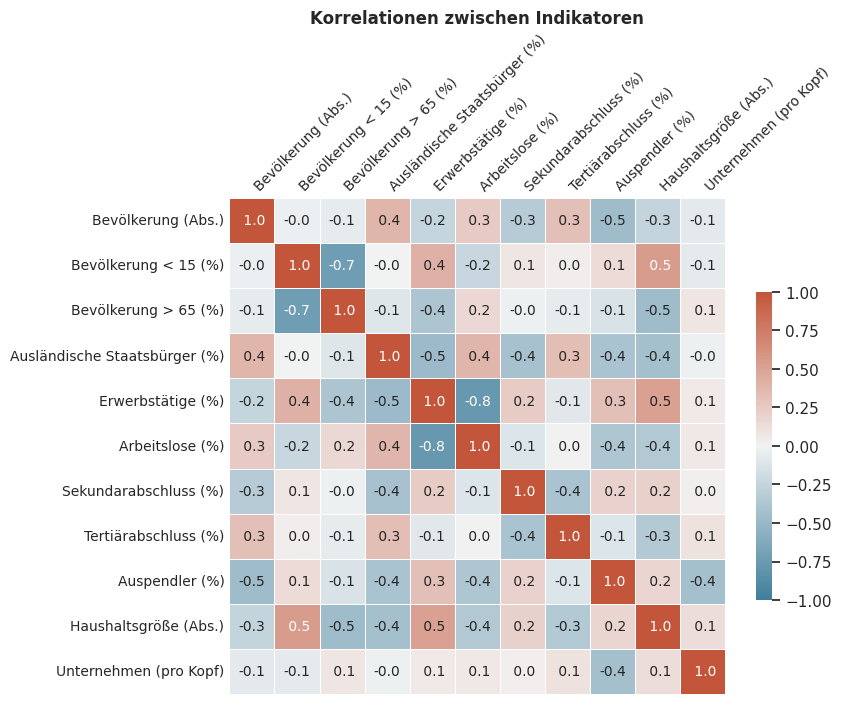

In [81]:
fig, ax = plt.subplots(figsize=(8,8))
correlogram(corr_indicators_2017, "Korrelationen zwischen Indikatoren", ax=ax)

Die erste offensichtliche Korrelationen besteht zwischen Bevölkerung unter 15 und Bevölkerung über 65: In Gemeinden mit vielen alten Leuten ist der Anteil junger Leute klein, und umgekehrt. Die zweite offensichtliche Korrelation ist intuitiv nachvollziehbar: Arbeitslosen- und Erwerbstätigenquote sind stark negativ korreliert.

Eine weitere Korrelation bezüglich des Alters: Gemeinden mit höheren durchschnittlichen Haushaltsgrößen weisen einen höheren Anteil an unter 15 Jährigen auf; eine mögliche Erklärung für diese Beobachtung ist, dass in diesen Gemeinden Familien viele Kinder haben.

Auf wirtschaftlicher Ebene: Der Auspendleranteil korreliert negativ mit der Anzahl an Unternehmen pro Kopf; hier wäre eine mögliche Erklärung, dass Gemeinden mit wenig lokalen Unternehmen Pendlerverhalten bedingen.

Der Zweck die Korrelationen zwischen Indikatoren zu analysieren, ist potentiell wenig aussagekräftige Indikatoren zu identifizieren, die für das Trainieren eines Machine Learning Modells irrelevant sind.

Ein Kandidat dafür könnte die Rate an Unternehmen pro Kopf sein, da sie nur eine stärkere Korrelation zum Auspendleranteil aufweisen. Ebenfalls interessant ist die Korrelation zwischen dem Anteil junger Personen und der Erwerbstätigenquote und der Haushaltsgröße.

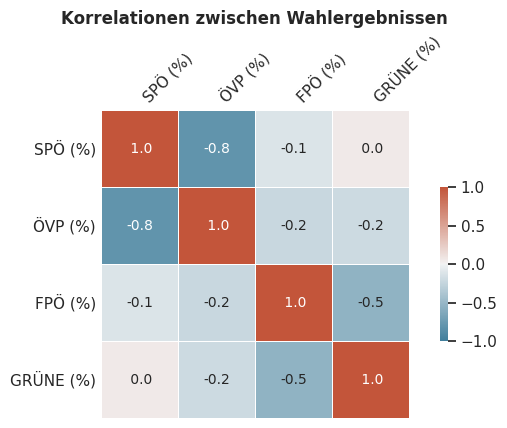

In [82]:
fig, ax = plt.subplots(figsize=(8,4))
correlogram(corr_election_2017, "Korrelationen zwischen Wahlergebnissen", ax=ax)

Obwohl es für unsere Analyse nicht direkte Relevanz hat, ist es dennoch für die spätere Beurteilung der Prognose-Ergebnisse interessant die Korrelationen zwischen den Wahlergebnissen zu untersuchen.

ÖVP und SPÖ weisen die stärkste negative Korrelation auf, was bedeutet, dass es unwahrscheinlich ist, Gemeinden zu finden in denen beide Parteien überdurchschnittlich stark vertreten sind. Ebenfalls negativ korrelieren FPÖ und Grüne, wenngleich nicht so stark.

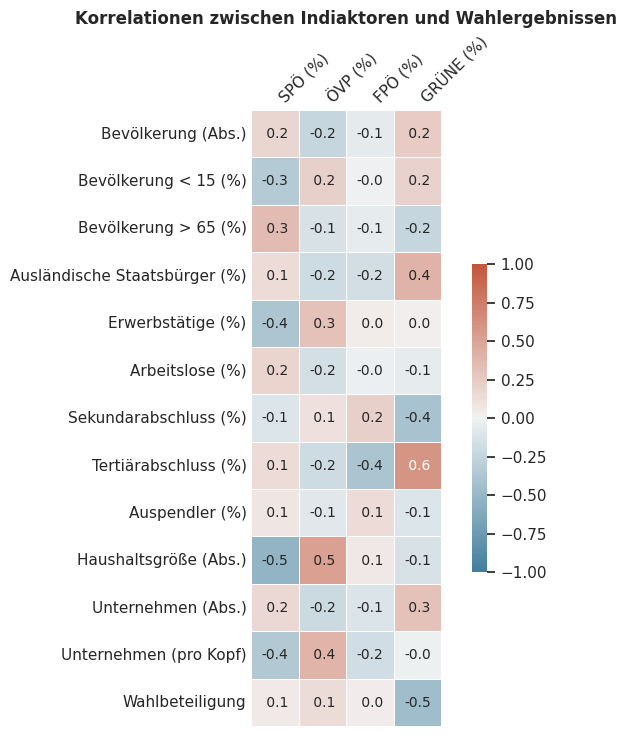

In [83]:
fig, ax = plt.subplots(figsize=(8,8))
correlogram(corr_election_indicators_2017, "Korrelationen zwischen Indiaktoren und Wahlergebnissen", ax=ax)

Die Korrelationen zwischen Indikatoren und Wahlergebnissen können darüber Auskunft geben, welche Indikatoren relevanter für den Ausgang der Wahlen sind als andere. Indikatoren, die mit keiner Partei korrelieren, können eventuell für das Trainieren des Machine Learning Modells ignoriert werden, während die mit stärkerer Korrelation unbedingt berücksichtigt werden müssen.

Der einzige Indikator, der mit keiner Partei stärker korreliert, ist der Auspendleranteil. Für die Prognose bedeutet das, dass dieser Indikator der erste ist, der bei etwaigen Kürzungen gestrichen werden kann.

Die starke negative Korrelation zwischen den unter 15 und über 65 Jährigen spiegelt sich auch in dieser Grafik wider: Die Korrelationskoeffizienten weisen ähnliche Absolutwerte auf, was bedeutet, dass eine der beiden Statistiken weggelassen werden kann. In diesem Fall wäre die Statistik der unter 15 Jährigen der bessere Kanditat, da über 65 Jährige wählen können und deswegen wahrscheinlich stärker, direkter die Wahlergebnisse bedingen.

# Visualisierungen mit Geopandas

In [84]:
import geopandas as gpd

Da die Einbindung der shapefiles nicht mit einem google drive shared link funktioniert, wird ein clone von einem git repository in die Laufzeit eingebunden.

In [85]:
!git clone https://github.com/aida04conny/lernprojekt3.git

Cloning into 'lernprojekt3'...
remote: Enumerating objects: 13, done.
remote: Total 13 (delta 0), reused 0 (delta 0), pack-reused 13
Unpacking objects: 100% (13/13), 50.64 MiB | 5.73 MiB/s, done.


In [86]:
shapes_2017 = gpd.read_file('/content/lernprojekt3/STATISTIK_AUSTRIA_GEM_20170101.shp')
shapes_2019 = gpd.read_file('/content/lernprojekt3/STATISTIK_AUSTRIA_GEM_20190101Polygon.shp')

In [87]:
# transform GCD into prefixed string
shapes_2017['ID'] = 'G' + shapes_2017['ID'].astype('string')
shapes_2019['id'] = 'G' + shapes_2019['id'].astype('string')

# keep relevant columns
shapes_2017 = shapes_2017[['ID', 'geometry']]
shapes_2019 = shapes_2019[['id', 'geometry']]

# rename id column for better usability
shapes_2019 = shapes_2019.rename(columns={'id':'ID'})

In [88]:
# merge shape file with election_indicators_2017 and remove duplicate columns
geodata_2017 = shapes_2017.merge(election_indicators_2017, left_on=['ID'], right_on=['GCD'])
geodata_2017 = geodata_2017.drop(columns='GCD')

geodata_2019 = shapes_2019.merge(election_indicators_2019, left_on=['ID'], right_on=['GCD'])
geodata_2019 = geodata_2019.drop(columns='GCD')

In [89]:
# geodata only for vienna
geodata_2017_vienna = geodata_2017[geodata_2017['ID'].str.contains('G9')]
geodata_2019_vienna = geodata_2019[geodata_2019['ID'].str.contains('G9')]

Die folgende Funktion erstellt Grafiken anhand von Geodaten der Gemeinden in Österreich und ausgewählten Indikatoren bzw. Wahlergebnissen. Damit kannn die Verteilung der Werte zwischen den Gemeinden sichtbar gemacht werden.

In [90]:
def geoplot(data, n_row, n_col, color, title='', v_min=None, v_max=None):
  """
  plots geomaps with geopandas

  data: pandas dataframe; first two columns must be ID and geometry from shapes file; other columns will be used as features
  n_row: number of rows in the figure
  n_col: number of columns in the figure
  color: list of colormaps (colormaps can be found here: https://matplotlib.org/stable/tutorials/colors/colormaps.html), length of list must be equal to number of features
  title: set figure title (default is '')
  v_min, v_max: Minimum and Maximum values used for the colormaps (default is None)
  """
  fig, axs = plt.subplots(nrows=n_row, ncols=n_col, figsize=(n_col*10,n_row*5), layout='constrained') 
  fig.suptitle(title, fontsize=16, fontweight="bold")

  i=0
  for ax in axs.flat:
    #print(data.columns[i+2], color[i])
    data.plot(column=data.columns[i+2], ax=ax, cmap=color[i], legend=True, legend_kwds={'shrink': 0.75}, vmin=v_min, vmax=v_max) 
    ax.set_title(data.columns[i+2])
    ax.axis('off')
    i+=1
        
  plt.show()

# Wahlprognose 2017: Supvervised Learning
Der erste Ansatz um Wahlergebnisse zu prognostizieren ist ein Supervised Learning Algorithmus aus der scikit-learn Library.

In [91]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

Zunächst werden einige Helferfunktionen definiert, die Machine Learning Modelle trainieren, Ergebnisse vorhersagen, und visuell aufbereiten können.

In [92]:
def make_reg(X, y):
  """Trains a regression model."""
  
  X_train, X_test, y_train, y_test = train_test_split(
      X, y, test_size=0.33, random_state=42)
  
  pipe = make_pipeline(StandardScaler(), Ridge())
  pipe.fit(X_train, y_train)

  score = pipe.score(X_test, y_test)
  display(score)

  return pipe

In [93]:
def predict_election_results(election_indicators, features, reg_sp, reg_vp, reg_fp, reg_gr):
  """Predicts election results given a DataFrame with election-specific results and indicators."""

  election_results = pd.DataFrame()

  election_indicators = election_indicators.reset_index()

  election_results["GCD"] = election_indicators["GCD"]

  election_results["SPÖ Ergb."] = election_indicators["SPÖ"]
  election_results["SPÖ Prog."] = reg_sp.predict(election_indicators[features])

  election_results["ÖVP Ergb."] = election_indicators["ÖVP"]
  election_results["ÖVP Prog."] = reg_vp.predict(election_indicators[features])

  election_results["FPÖ Ergb."] = election_indicators["FPÖ"]
  election_results["FPÖ Prog."] = reg_fp.predict(election_indicators[features])

  election_results["GRÜNE Ergb."] = election_indicators["GRÜNE"]
  election_results["GRÜNE Prog."] = reg_gr.predict(election_indicators[features])

  return election_results

In [94]:
def plot_election_results_pie(election_results, title_results, title_predictions):
  """Plots election results in two pie plot, comparing actual results and predictions."""

  # transform data frame
  data = pd.DataFrame()
  data["Partei"] = ["SPÖ", "ÖVP", "FPÖ", "GRÜNE"]
  data["Ergebnisse"] = election_results[["SPÖ Ergb.", "ÖVP Ergb.", "FPÖ Ergb.", "GRÜNE Ergb."]].sum().reset_index(drop=True)
  data["Prognose"] = election_results[["SPÖ Prog.", "ÖVP Prog.", "FPÖ Prog.", "GRÜNE Prog."]].sum().reset_index(drop=True)

  # comparative pie plots
  fig, (ax1, ax2) = plt.subplots(1, 2)

  fig.set_size_inches(14, 8)

  ax1.pie(data=data, x="Ergebnisse", colors=["red", "black", "blue", "green"])
  ax2.pie(data=data, x="Prognose", colors=["red", "black", "blue", "green"])

  ax1.set_title(title_results, fontsize=16, fontweight="bold")
  ax2.set_title(title_predictions, fontsize=16, fontweight="bold")

  ax1.legend(["SPÖ", "ÖVP", "FPÖ", "GRÜN"], loc="lower right")
  ax2.legend(["SPÖ", "ÖVP", "FPÖ", "GRÜN"], loc="lower right")

  plt.show()

In [95]:
def plot_election_results_stacked(election_results, title):
  """Plots election results in a 100-percent stacked bar plot, comparing actual results and predictions side-by-side."""

  # transform data frame
  data = pd.DataFrame()
  data["Partei"] = ["SPÖ", "ÖVP", "FPÖ", "GRÜNE"]
  data["Ergebnisse"] = election_results[["SPÖ Ergb.", "ÖVP Ergb.", "FPÖ Ergb.", "GRÜNE Ergb."]].sum().reset_index(drop=True)
  data["Prognose"] = election_results[["SPÖ Prog.", "ÖVP Prog.", "FPÖ Prog.", "GRÜNE Prog."]].sum().reset_index(drop=True)

  total_votes_actual = data["Ergebnisse"].sum()
  total_votes_prediction = data["Prognose"].sum()

  data["Ergebnisse"] = data["Ergebnisse"] / total_votes_actual
  data["Prognose"] = data["Prognose"] / total_votes_prediction

  data = pd.melt(data, id_vars=["Partei"], value_vars=["Ergebnisse", "Prognose"], var_name="Typ", value_name="Stimmen")

  ax = sns.histplot(data, x='Typ', hue='Partei', weights='Stimmen', multiple='stack', palette=["red", "black", "blue", "green"])
  ax.set_title(title, fontsize=16, fontweight="bold")
  ax.set_xlabel(None)
  ax.set_ylabel("Stimmen")

  yvals = ax.get_yticks()
  ax.set_yticklabels(["{:,.0%}".format(y) for y in yvals], fontsize=12)

  sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5))

  plt.show()

In [96]:
def plot_election_results_bar(election_results, title):
  """Plots election results in one bar plot, comparing actual results and predictions side-by-side."""

  # transform data frame
  data = pd.DataFrame()
  data["Partei"] = ["SPÖ", "ÖVP", "FPÖ", "GRÜNE"]
  data["Ergebnisse"] = election_results[["SPÖ Ergb.", "ÖVP Ergb.", "FPÖ Ergb.", "GRÜNE Ergb."]].sum().reset_index(drop=True)
  data["Prognose"] = election_results[["SPÖ Prog.", "ÖVP Prog.", "FPÖ Prog.", "GRÜNE Prog."]].sum().reset_index(drop=True)

  data = pd.melt(data, id_vars=["Partei"], value_vars=["Ergebnisse", "Prognose"], var_name="Typ", value_name="Stimmen")

  ax = sns.barplot(data=data, x="Partei", y="Stimmen", hue="Typ")
  ax.set_title(title, fontsize=16, fontweight="bold")

  sns.move_legend(ax, 'center left', bbox_to_anchor=(1, 0.5))

  plt.show()

Hier werden die verwendeten Indikatoren — die Features — für das Machine Learning Modell definiert.

In [97]:
# define features for machine learning
features = ["Bevölkerung (Abs.)",
            "Bevölkerung < 15 (%)",
            "Bevölkerung > 65 (%)",
            "Ausländische Staatsbürger (%)",
            "Erwerbstätige (%)",
            "Arbeitslose (%)",
            "Sekundarabschluss (%)",
            "Tertiärabschluss (%)",
            "Auspendler (%)",
            "Haushaltsgröße (Abs.)",
            "Unternehmen (Abs.)",
            "Unternehmen (pro Kopf)"]

Da die Supervised Learning Algorithmen Lineare Regressionen abbilden, haben sie als Ergebnis immer nur einen Wert, weswegen nun ein Regressionsmodell für jede Partei trainiert werden muss.

In [98]:
# train models for each party based on 2017 
reg_sp_2017 = make_reg(election_indicators_2017[features], election_indicators_2017["SPÖ"])
reg_vp_2017 = make_reg(election_indicators_2017[features], election_indicators_2017["ÖVP"])
reg_fp_2017 = make_reg(election_indicators_2017[features], election_indicators_2017["FPÖ"])
reg_gr_2017 = make_reg(election_indicators_2017[features], election_indicators_2017["GRÜNE"])

0.9827457266050772

0.8947078467027938

0.9295557714282789

0.8234026634987939

Die obigen Werte reflektieren die Genauigkeit der Regresionsmodelle, gemessen anhand eines Testdatensatzes aus 2017. Die hohen Werte bedeuten, dass die Regressionsmodelle zumindest für das Jahr 2017 — auf das sie ja trainiert wurden — mit hoher Genauigkeit Ergebnisse vorhersagen können.

In [99]:
# create vienna specific dataframes
election_indicators_2017_vienna = election_indicators_2017[election_indicators_2017["GCD"].str.startswith("G9")].reset_index()
election_indicators_2019_vienna = election_indicators_2019[election_indicators_2019["GCD"].str.startswith("G9")].reset_index()

In [100]:
# predict 2017 results
election_results_2017 = predict_election_results(election_indicators_2017_vienna, features, reg_sp_2017, reg_vp_2017, reg_fp_2017, reg_gr_2017)

Dies wird nun überprüft: Es werden für die Wiener Bezirke Prognosen getroffen und mit den tatsächlichen Ergebnissen verglichen.

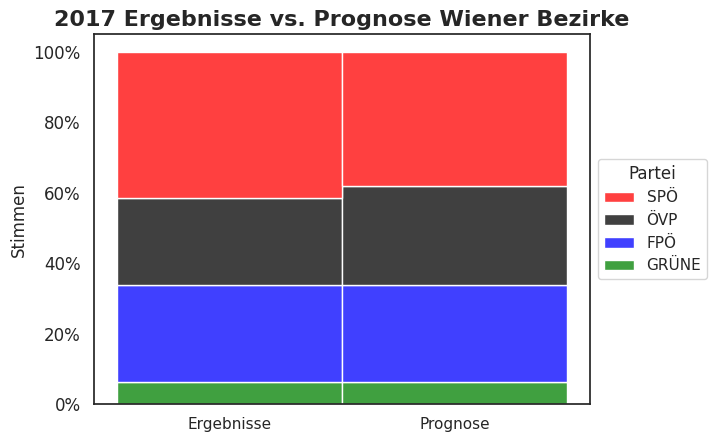

In [101]:
# plot 2017 results
plot_election_results_stacked(election_results_2017, "2017 Ergebnisse vs. Prognose Wiener Bezirke")

Bei der direkten Gegenüberstellung von Ergebnissen und Prognose treten keine nennenswerten Abweichungen auf.

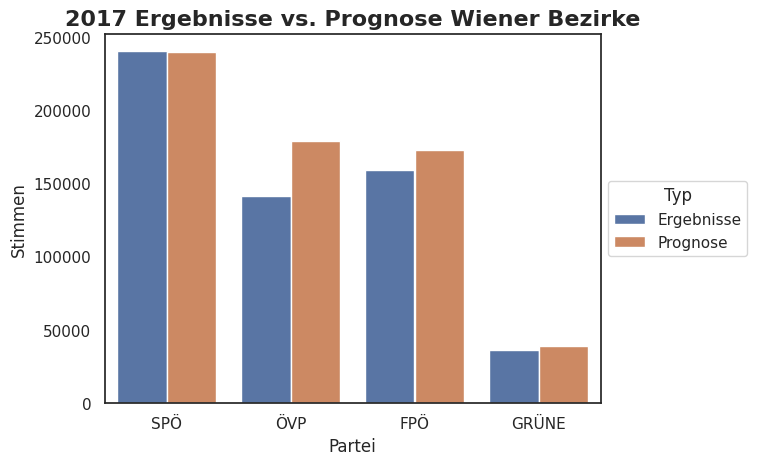

In [102]:
# plot 2017 results
plot_election_results_bar(election_results_2017, "2017 Ergebnisse vs. Prognose Wiener Bezirke")

Ein direkter Vergleich der Ergebnisse mit den Prognosen zeigt auf, dass besonders SPÖ und Grüne sehr genau vorhergesagt werden konnten. Die größte Diskrepanz scheint bei den Ergebnissen der ÖVP auf.

In den folgenden Diagrammen sind die Unterschiede zwischen Wahlergebnissen und Prognosen auf einer Wienkarte eingezeichnet. Je dunkler die Farbe desto mehr Stimmen hat die Partei in dem Bezirk erzielt.

In [103]:
election_results_2017_geodata = geodata_2017_vienna.merge(election_results_2017, how="inner", left_on="ID", right_on="GCD")[["ID", "geometry", "SPÖ Ergb.", "SPÖ Prog.", "ÖVP Ergb.", "ÖVP Prog.", "FPÖ Ergb.", "FPÖ Prog.", "GRÜNE Ergb.", "GRÜNE Prog."]]

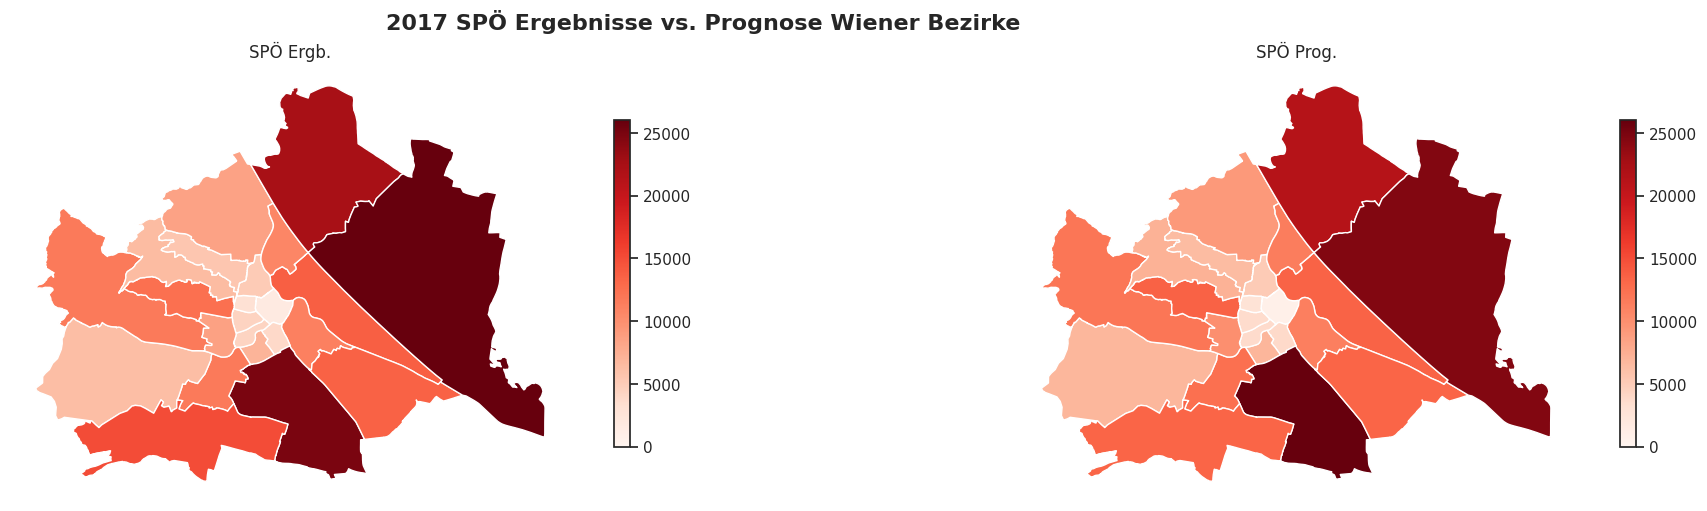

In [104]:
geoplot(election_results_2017_geodata[['ID', 'geometry', "SPÖ Ergb.", "SPÖ Prog."]], 1, 2, ['Reds', 'Reds'], '2017 SPÖ Ergebnisse vs. Prognose Wiener Bezirke', v_min=0, v_max=26000)

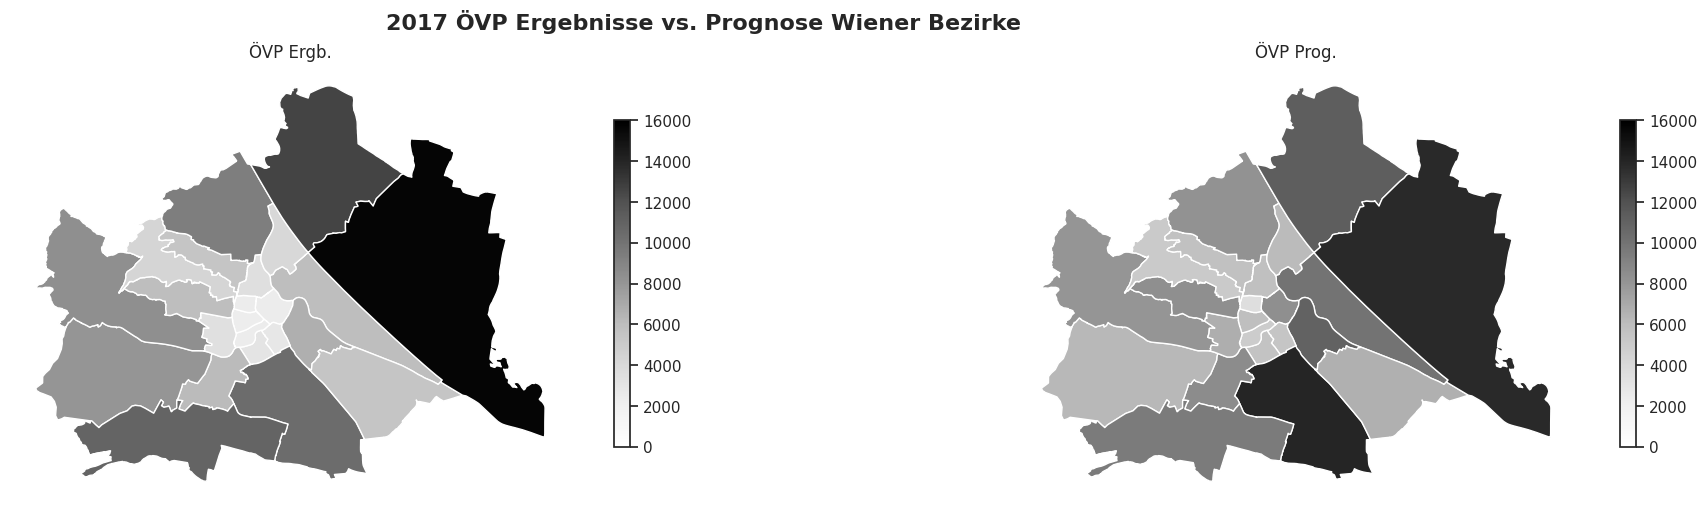

In [105]:
geoplot(election_results_2017_geodata[['ID', 'geometry', "ÖVP Ergb.", "ÖVP Prog."]], 1, 2, ['Greys', 'Greys'], '2017 ÖVP Ergebnisse vs. Prognose Wiener Bezirke', v_min=0, v_max=16000)

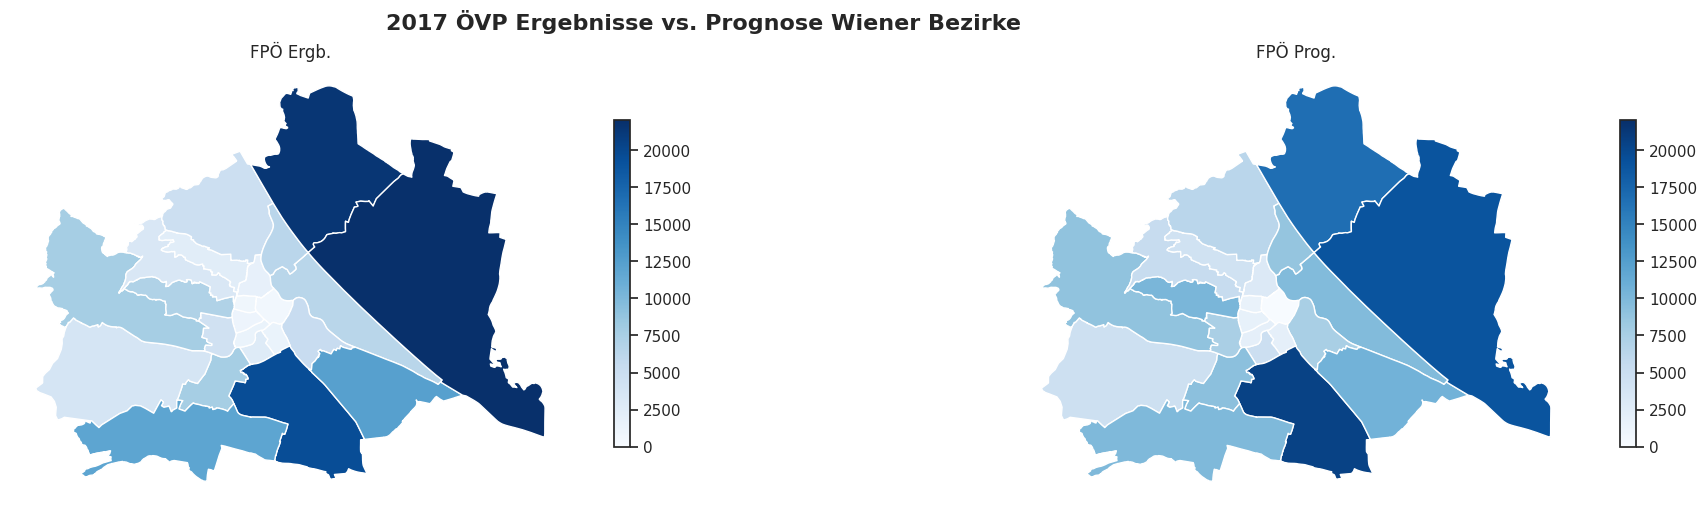

In [106]:
geoplot(election_results_2017_geodata[['ID', 'geometry', "FPÖ Ergb.", "FPÖ Prog."]], 1, 2, ['Blues', 'Blues'], '2017 ÖVP Ergebnisse vs. Prognose Wiener Bezirke', v_min=0, v_max=22000)

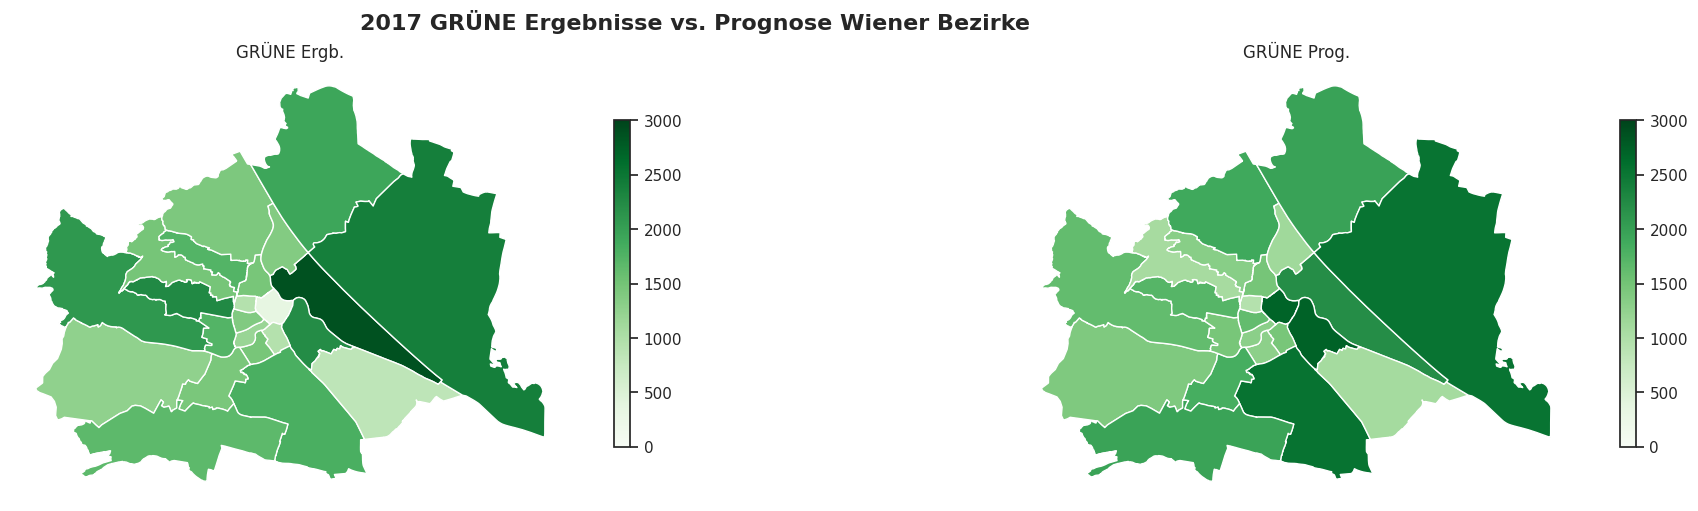

In [107]:
geoplot(election_results_2017_geodata[['ID', 'geometry', "GRÜNE Ergb.", "GRÜNE Prog."]], 1, 2, ['Greens', 'Greens'], '2017 GRÜNE Ergebnisse vs. Prognose Wiener Bezirke', v_min=0, v_max=3000)

# Wahlprognose 2019: Supervised Learning
Um die Regressionsmodelle in anderem Kontext zu testen, werden die Wahlergebnisse von 2019 herangezogen.

In [108]:
# predict 2019 results with models trained on 2017 results
election_results_2019_from_2017 = predict_election_results(election_indicators_2019_vienna, features, reg_sp_2017, reg_vp_2017, reg_fp_2017, reg_gr_2017)

Die Regressionsmodelle, welche mit den Ergebnissen von 2017 trainiert wurden, werden nun dazu verwendet die Wahlergebnisse der Nationalratswahlen 2019 vorherzusagen. Es werden wieder spezifisch die Wiener Bezirke untersucht, da zwischen 2017 und 2019 viele Gemeinden zusammengelegt wurden, weswegen ein Österreich weiter Vergleich wesentlich komplexer wäre.

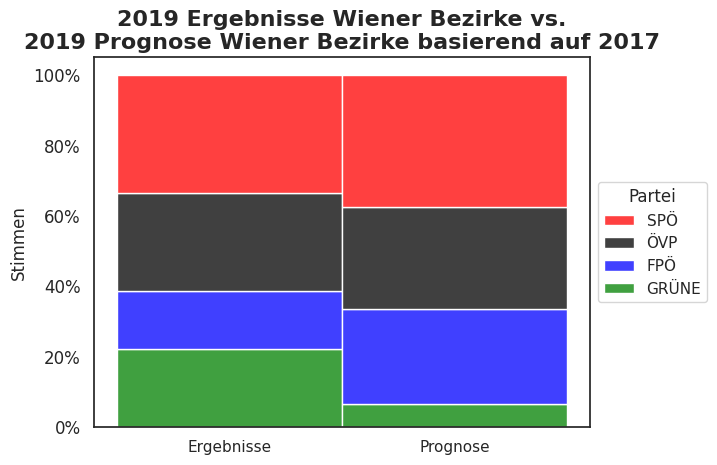

In [109]:
# plot 2019 results
plot_election_results_stacked(election_results_2019_from_2017, "2019 Ergebnisse Wiener Bezirke vs.\n2019 Prognose Wiener Bezirke basierend auf 2017")

In einer direkten Gegenüberstellung ist zu erkennen, wie stark die Prognose vom tatsächlichen Ergebnis abweicht: Die Regressionsmodelle unterschätzen die Ergebnisse der Grünen zugunsten der FPÖ.

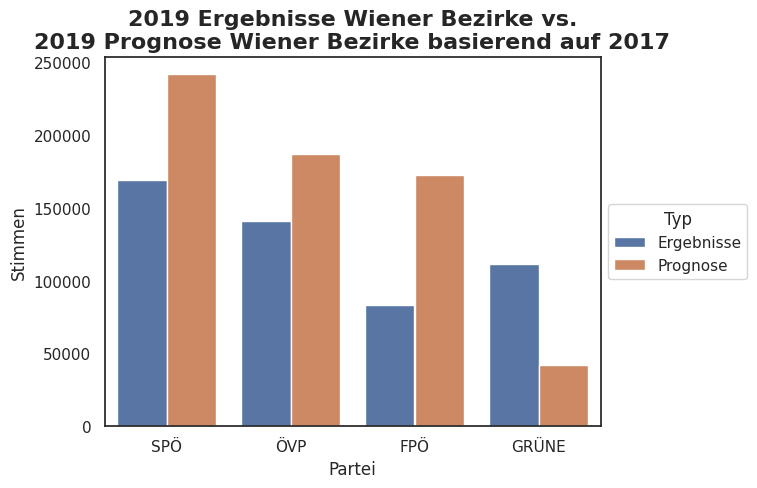

In [110]:
# plot 2019 results
plot_election_results_bar(election_results_2019_from_2017, "2019 Ergebnisse Wiener Bezirke vs.\n2019 Prognose Wiener Bezirke basierend auf 2017")

Ein direkter Vergleich zwischen den prognostizierten und tatsächlichen Stimmen zeigt, dass nicht nur das anteilhafte Verhältnis zwischen den Parteien falsch ist, sondern auch die genaue Vorhersage der absoluten Stimmen: Während die Modelle überschätzen SPÖ Ergebnisse um ca. 80.000, ÖVP um ca. 40.000, und FPÖ um ca. 90.000 Stimmen, während die Grüne um ca. 70.000 Stimmen unterschätzt wird.

In den folgenden Kartendiagrammen werden die Abweichungen auch auf einer geographischen Ebene klar.

In [111]:
election_results_2019_geodata = geodata_2019_vienna.merge(election_results_2019_from_2017, how="inner", left_on="ID", right_on="GCD")[["ID", "geometry", "SPÖ Ergb.", "SPÖ Prog.", "ÖVP Ergb.", "ÖVP Prog.", "FPÖ Ergb.", "FPÖ Prog.", "GRÜNE Ergb.", "GRÜNE Prog."]]

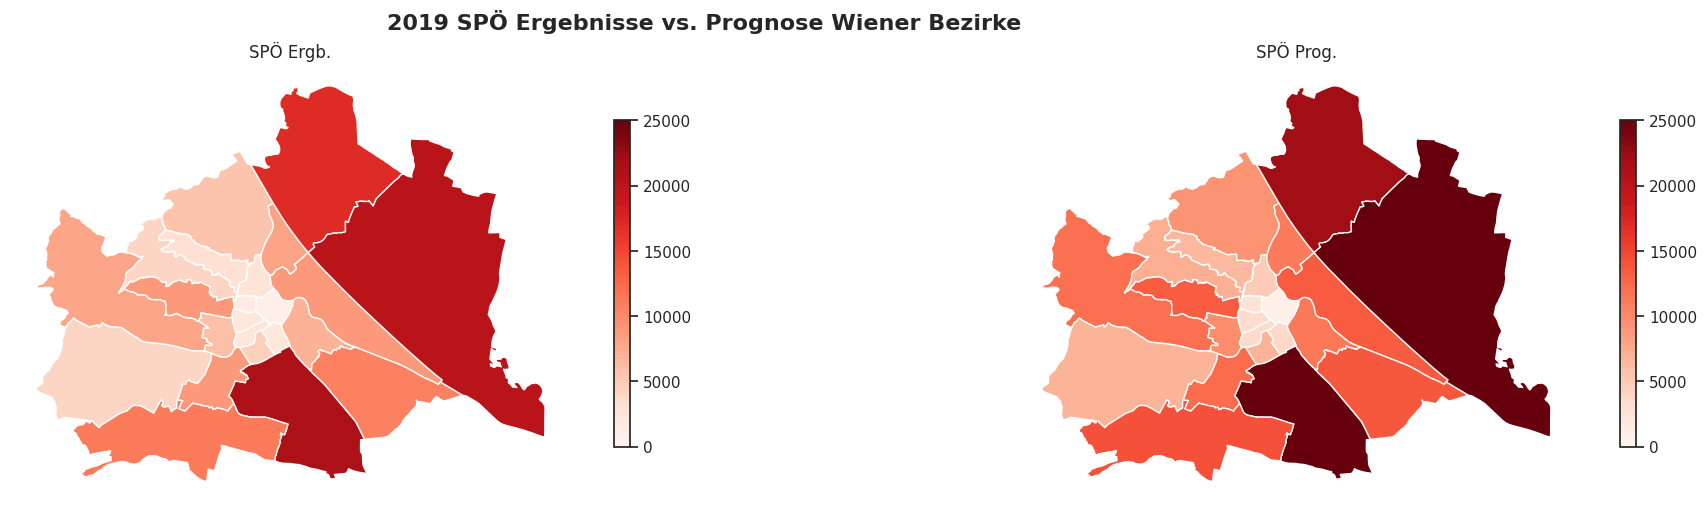

In [112]:
geoplot(election_results_2019_geodata[['ID', 'geometry', "SPÖ Ergb.", "SPÖ Prog."]], 1, 2, ['Reds', 'Reds'], '2019 SPÖ Ergebnisse vs. Prognose Wiener Bezirke', v_min=0, v_max=25000)

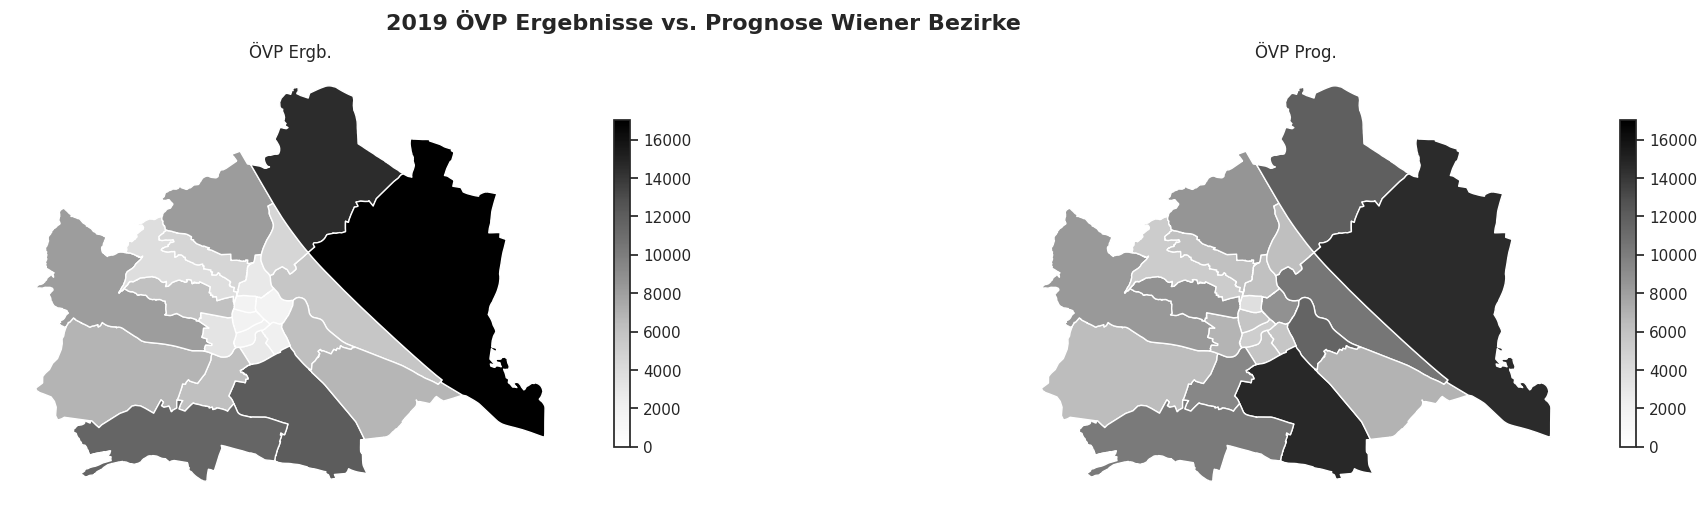

In [113]:
geoplot(election_results_2019_geodata[['ID', 'geometry', "ÖVP Ergb.", "ÖVP Prog."]], 1, 2, ['Greys', 'Greys'], '2019 ÖVP Ergebnisse vs. Prognose Wiener Bezirke', v_min=0, v_max=17000)

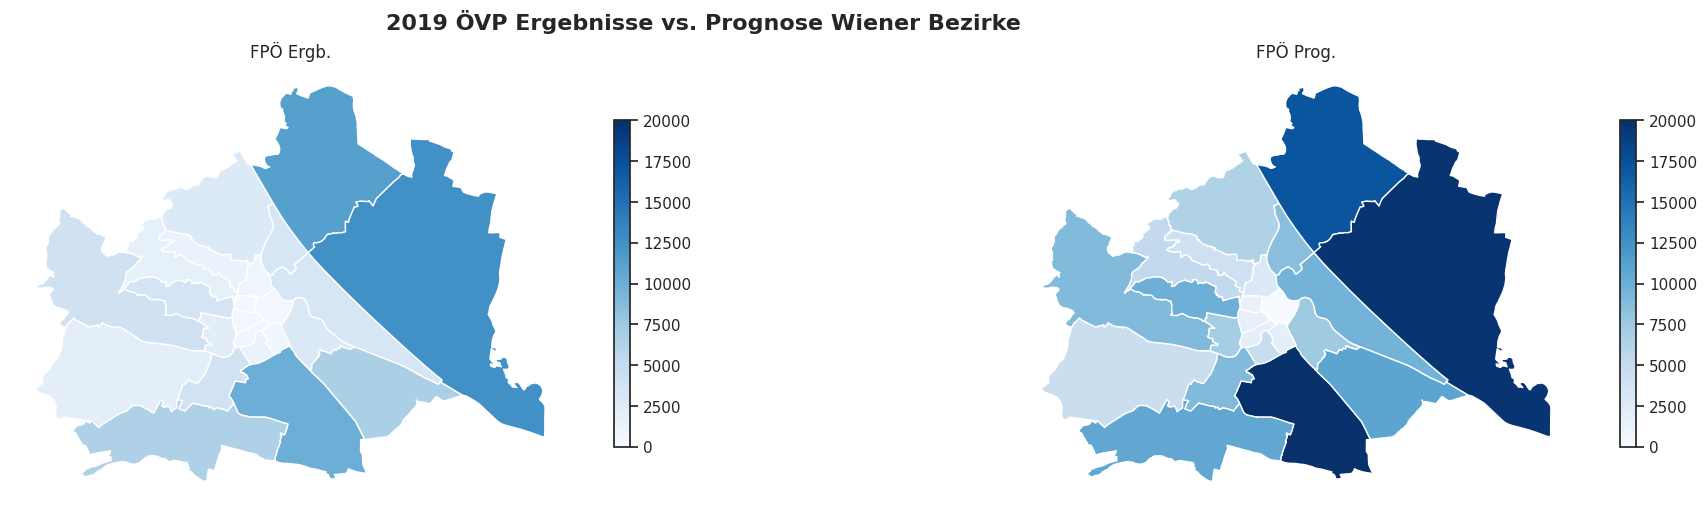

In [114]:
geoplot(election_results_2019_geodata[['ID', 'geometry', "FPÖ Ergb.", "FPÖ Prog."]], 1, 2, ['Blues', 'Blues'], '2019 ÖVP Ergebnisse vs. Prognose Wiener Bezirke', v_min=0, v_max=20000)

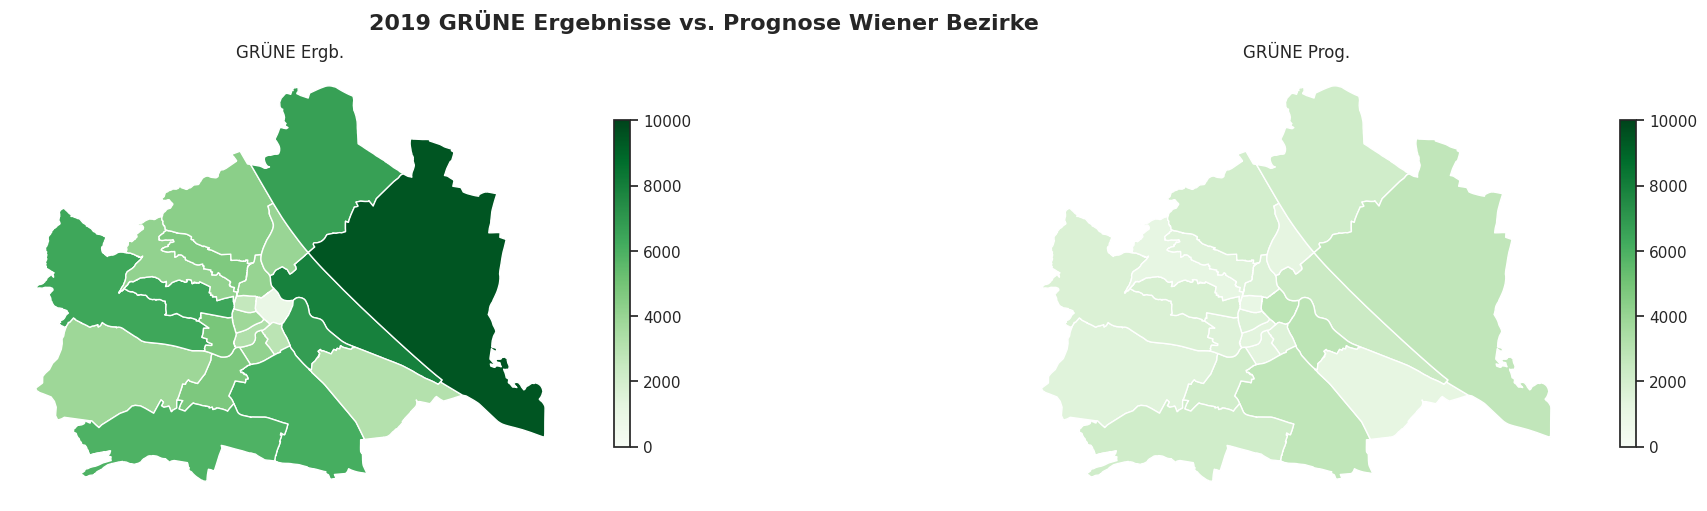

In [115]:
geoplot(election_results_2019_geodata[['ID', 'geometry', "GRÜNE Ergb.", "GRÜNE Prog."]], 1, 2, ['Greens', 'Greens'], '2019 GRÜNE Ergebnisse vs. Prognose Wiener Bezirke', v_min=0, v_max=10000)

In [116]:
# score 2017 models with 2019 election indicators
display(reg_sp_2017.score(election_indicators_2019[features], election_indicators_2019["SPÖ"]))
display(reg_vp_2017.score(election_indicators_2019[features], election_indicators_2019["ÖVP"]))
display(reg_fp_2017.score(election_indicators_2019[features], election_indicators_2019["FPÖ"]))
display(reg_gr_2017.score(election_indicators_2019[features], election_indicators_2019["GRÜNE"]))

0.7215096590523492

0.8993184323649652

0.21202072723147214

0.4820619018369232

Die Scores für die Regressionsmodelle anhand der Wahlergebnisse von 2019, reflektieren die bisherigen Erkenntnisse: Während Prognosen für SPÖ und ÖVP schlechter, aber dennoch einigermaßen akkurat sind, scheitern die Regressionsmodelle für FPÖ und Grüne.

Dies kann mehrere Gründe haben: Einerseits ist es möglich, dass die gewählten Indikatoren das Wahlverhalten nicht komplett einfangen können und deswegen eine große Diskrepanz zwischen dem Jahr, welches zum trainieren der Regressionsmodelle verwendet wurde, und anderen Jahren vorliegt.

Außerdem war 2017, das Jahr welches benutzt wird um die Regressionsmodelle zu trainieren, ein äußerst unrepräsentatives Wahlergebnis für die Grünen, deren Stimmen sich in dieser Wahl auf andere Parteien (z.B. Liste Pilz) aufgeteilt haben.

# Training eines Neuronalen Netzes für 2017

##Standardisierung, Skalierung

In [117]:
import numpy as np

In [118]:
display(indicators.var())

Jahr                             8.321208e+00
Bevölkerung (Abs.)               1.708516e+08
Bevölkerung < 15 (%)             4.676821e+00
Bevölkerung > 65 (%)             1.301820e+01
Ausländische Staatsbürger (%)    3.221423e+01
Erwerbstätige (%)                2.156715e+01
Arbeitslose (%)                  8.259178e+00
Sekundarabschluss (%)            1.895909e+01
Tertiärabschluss (%)             1.995805e+01
Auspendler (%)                   1.627285e+02
Haushaltsgröße (Abs.)            6.750056e-02
Unternehmen (Abs.)               8.093417e+05
Unternehmen (pro Kopf)           8.047074e-04
dtype: float64

Die Varianz der Bevölkerung und der Anzahl der Unternehmen ist viel zu groß, deswegen ist eine logarithmische Transformation nötig.

In [119]:
election_indicators_2017["Bevölkerung_log"] = np.log(election_indicators_2017["Bevölkerung (Abs.)"])
election_indicators_2019["Bevölkerung_log"] = np.log(election_indicators_2019["Bevölkerung (Abs.)"])
election_indicators_2017["Unternehmen_log"] = np.log(election_indicators_2017["Unternehmen (Abs.)"])
election_indicators_2019["Unternehmen_log"] = np.log(election_indicators_2019["Unternehmen (Abs.)"])



In [120]:
print (election_indicators_2017["Bevölkerung_log"].var())
print (election_indicators_2019["Bevölkerung_log"].var())
print (election_indicators_2017["Unternehmen_log"].var())
print (election_indicators_2019["Unternehmen_log"].var())

0.9343135283505634
0.9391639074694894
0.9062775712696801
0.9163164018350617


Die Indikatoren könnten in den einzelnen Bundesländern anders wirken, deswegen empfiehlt es sich, diese als Variablen auszuführen. Dafür müssen die Codes der Bundesländer vom GCD zurückferfolgt werden.

In [121]:
election_indicators_2017['Bsld'] = election_indicators_2017['GCD'].str[1:2]
election_indicators_2019['Bsld'] = election_indicators_2019['GCD'].str[1:2]
display(election_indicators_2017['Bsld'])

0       1
1       1
2       1
3       1
4       1
       ..
2117    9
2118    9
2119    9
2120    9
2121    9
Name: Bsld, Length: 2122, dtype: object

Statt Gemeindekennzahlen werden die Abkürzungen bevorzugt.

In [122]:
GKZ = {
    '1':'BL',
    '2':'KN',
    '3':'NÖ',
    '4':'OÖ',
    '5':'SB',
    '6':'ST',
    '7':'TL',
    '8':'VA',
    '9':'W'
        }

Bundesländer sind kategorische Daten, deswegen empfiehlt es sich, sie zu numerische, "dummy" Variablen zu transformieren.

In [123]:
dummies_17 = pd.get_dummies(election_indicators_2017['Bsld'])
dummies_19 = pd.get_dummies(election_indicators_2019['Bsld'])

In [124]:
joined_17 = election_indicators_2017.join(dummies_17)
joined_19 = election_indicators_2019.join(dummies_19)

In [125]:
joined_17_ren = joined_17.rename (columns = GKZ)
joined_19_ren = joined_19.rename (columns = GKZ)
display (joined_17_ren.columns)

Index(['GCD', 'Gültige', 'SPÖ', 'ÖVP', 'FPÖ', 'GRÜNE', 'SPÖ (%)', 'ÖVP (%)',
       'FPÖ (%)', 'GRÜNE (%)', 'Gemeindename', 'Bevölkerung (Abs.)',
       'Bevölkerung < 15 (%)', 'Bevölkerung > 65 (%)',
       'Ausländische Staatsbürger (%)', 'Erwerbstätige (%)', 'Arbeitslose (%)',
       'Sekundarabschluss (%)', 'Tertiärabschluss (%)', 'Auspendler (%)',
       'Haushaltsgröße (Abs.)', 'Unternehmen (Abs.)', 'Unternehmen (pro Kopf)',
       'Wahlbeteiligung', 'Bevölkerung_log', 'Unternehmen_log', 'Bsld', 'BL',
       'KN', 'NÖ', 'OÖ', 'SB', 'ST', 'TL', 'VA', 'W'],
      dtype='object')

Um mehr Einheit im Datensatz zu schaffen, werden die absoluten (Stimmen / Einwohner) Prozente verwendet.

In [126]:
joined_17_ren['SPÖ % ganz'] = joined_17_ren['SPÖ'] / joined_17_ren['Bevölkerung (Abs.)']
joined_17_ren['FPÖ % ganz'] = joined_17_ren['FPÖ'] / joined_17_ren['Bevölkerung (Abs.)']
joined_17_ren['ÖVP % ganz'] = joined_17_ren['ÖVP'] / joined_17_ren['Bevölkerung (Abs.)']
joined_17_ren['GRÜNE % ganz'] = joined_17_ren['GRÜNE'] / joined_17_ren['Bevölkerung (Abs.)']


In [127]:
input_columns = [
    'Bevölkerung_log',
    'Bevölkerung < 15 (%)',
    'Bevölkerung > 65 (%)',
    'Ausländische Staatsbürger (%)',
    'Erwerbstätige (%)',
    'Arbeitslose (%)',
    'Sekundarabschluss (%)',
    'Tertiärabschluss (%)',
    'Auspendler (%)',
    'Haushaltsgröße (Abs.)',
    'Unternehmen_log',
    'Wahlbeteiligung',
    'BL','KN','NÖ','OÖ','SB','ST','TL','VA','W'
]
output_columns = [
    'SPÖ % ganz',
    'ÖVP % ganz',
    'FPÖ % ganz',
    'GRÜNE % ganz'
    ]

In [128]:
data = joined_17_ren[input_columns + output_columns].astype(float)

In [129]:
data.columns

Index(['Bevölkerung_log', 'Bevölkerung < 15 (%)', 'Bevölkerung > 65 (%)',
       'Ausländische Staatsbürger (%)', 'Erwerbstätige (%)', 'Arbeitslose (%)',
       'Sekundarabschluss (%)', 'Tertiärabschluss (%)', 'Auspendler (%)',
       'Haushaltsgröße (Abs.)', 'Unternehmen_log', 'Wahlbeteiligung', 'BL',
       'KN', 'NÖ', 'OÖ', 'SB', 'ST', 'TL', 'VA', 'W', 'SPÖ % ganz',
       'ÖVP % ganz', 'FPÖ % ganz', 'GRÜNE % ganz'],
      dtype='object')

##Training und Test sets

In [130]:
from tensorflow.python.distribute.input_lib import values
from sklearn.model_selection import train_test_split

Input und Output Variablen werden bestimmt

In [131]:
y = data[output_columns].values
X = data[input_columns].values

Der Datensatz muss randomisiert auf Training und Test Teile aufgeteilt werden.

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

##Tuning

In [133]:
from tensorflow import keras
from tensorflow.keras import layers

Für die Optimierung der Architektur des neuronalen Netzes wird ein Tuner gebaut, der aus viellen Möglichkeiten die passendste Form aussucht. 

In [134]:
pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 9.4 MB/s eta 0:00:00


In [135]:
def build_model(hp):
    model = keras.Sequential()
    #model.add(layers.Flatten())
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(4, activation="softmax"))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [136]:
import keras_tuner

build_model(keras_tuner.HyperParameters())

Der Tuner bekommt Parameter, zwischen denen er sich bewegen darf. In jeder Runde wird die beste Architektur gespeichert.

In [137]:
tuner_17 = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=3,
    overwrite=True,
    directory="/content/models",
    project_name="Election_2017",
)

Der Tuner macht viele Versuche

In [138]:
tuner_17.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Trial 10 Complete [00h 00m 30s]
val_accuracy: 0.7129411697387695

Best val_accuracy So Far: 0.7129411697387695
Total elapsed time: 00h 03m 51s


Die beste Architektur wird bestimmt und (noch ohne Gewichtungen) gebaut.

In [139]:
models = tuner_17.get_best_models(num_models=2)
best_model_17 = models[0]
best_model_17.build(input_shape=(None, len(input_columns),))
best_model_17.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 96)                2112      
                                                                 
 dense_1 (Dense)             (None, 32)                3104      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 132       
                                                                 
Total params: 5,348
Trainable params: 5,348
Non-trainable params: 0
_________________________________________________________________


mit dem folgenden Code wurde die beste Architektur im Hauptordner gespeichert

In [140]:
best_model_17.save('/content/best_model_17.h5')

Ein Blick in den Aufbau des Modells

In [141]:
print(tuner_17.results_summary(1))

Results summary
Results in /content/models/Election_2017
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
num_layers: 2
units_0: 96
activation: tanh
dropout: True
lr: 0.003418872247779846
units_1: 32
Score: 0.7129411697387695
None


##Modell erstellen

Das beste Modell wird nun auf den Trainingsset angepasst und mit dem Testset evaluiert. Gegen Overfitting wurde ein "frühes Aufhören" eingebaut.

In [142]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=5)

best_model_17.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
best_model_17.fit(X_train, y_train, epochs=1000, batch_size=64, callbacks=[early_stop])
loss_17, accuracy_17 = best_model_17.evaluate(X_test, y_test)
print('Test accuracy:', accuracy_17)

Epoch 1/1000
27/27 [==============================] - 1s 3ms/step - loss: 0.9769 - accuracy: 0.3842
Epoch 2/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.4855 - accuracy: 0.5445
Epoch 3/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.3789 - accuracy: 0.5056
Epoch 4/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.3712 - accuracy: 0.4962
Epoch 5/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.3670 - accuracy: 0.5233
Epoch 6/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.3621 - accuracy: 0.5775
Epoch 7/1000
27/27 [==============================] - 0s 2ms/step - loss: 0.3599 - accuracy: 0.5857
Epoch 8/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.3580 - accuracy: 0.6046
Epoch 9/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.3571 - accuracy: 0.5969
Epoch 10/1000
27/27 [==============================] - 0s 3ms/step - loss: 0.3552 - accuracy: 0.6158

##Laden eines früher gespeicherten Modells

Damit das Suchen nicht jedes Mal aufgeführt werden muss, wurde von vielen Versuchen das allerbeste Modell auf Google Drive hochgeladen, dieses wird hier gebaut und angepasst

In [143]:
import requests
from tensorflow.keras.models import load_model
model_17_url='https://drive.google.com/uc?id=1oDNR1Lz5oLxD5hPehKCLuZeWfRxB5CiN'
response = requests.get(model_17_url)
open('model_17.h5', 'wb').write(response.content)
model_17 = load_model('model_17.h5')

In [144]:
model_17.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_17.fit(X_train, y_train, epochs=1000, batch_size=64, callbacks=[early_stop])
loss_17, accuracy_17 = model_17.evaluate(X_test, y_test)
print('Test accuracy:', accuracy_17)

Epoch 1/1000
27/27 [==============================] - 2s 5ms/step - loss: 0.3765 - accuracy: 0.4455
Epoch 2/1000
27/27 [==============================] - 0s 7ms/step - loss: 0.3628 - accuracy: 0.5085
Epoch 3/1000
27/27 [==============================] - 0s 5ms/step - loss: 0.3596 - accuracy: 0.5398
Epoch 4/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.3576 - accuracy: 0.5557
Epoch 5/1000
27/27 [==============================] - 0s 5ms/step - loss: 0.3555 - accuracy: 0.5981
Epoch 6/1000
27/27 [==============================] - 0s 7ms/step - loss: 0.3546 - accuracy: 0.6022
Epoch 7/1000
27/27 [==============================] - 0s 8ms/step - loss: 0.3533 - accuracy: 0.6305
Epoch 8/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.3524 - accuracy: 0.6529
Epoch 9/1000
27/27 [==============================] - 0s 5ms/step - loss: 0.3524 - accuracy: 0.6523
Epoch 10/1000
27/27 [==============================] - 0s 6ms/step - loss: 0.3519 - accuracy: 0.6671

##Prognose von 2017 auf 2017

Die konkreten, prognostizierten Werte nach dem Modell für jede Gemeinde:

In [145]:
y_pred_17 = model_17.predict(X)

67/67 [==============================] - 0s 3ms/step


diese Variable enthält nun den Prozentsatz der Stimmen auf die ganze Bevölkerung pro Gemeinde. Die Reihenfolge der Parteien und der Gemeinden sind identisch mit der in dem dataframe mit den Wahlergebnissen

###Visualisierung

In [146]:
parteien_pr = ['SPÖ_%_prg', 'ÖVP_%_prg', 'FPÖ_%_prg', 'GRÜNE_%_prg']
prognose_17 = pd.DataFrame(y_pred_17)
prognose_17.columns = parteien_pr
#display(prognose_19)

Verkopplung der Wahlergebnissen mit deren Prognose

In [147]:
nn_vergleich_17 = election_indicators_2017.join(prognose_17)
display(nn_vergleich_17)

GCD  Gültige    SPÖ    ÖVP    FPÖ  GRÜNE   SPÖ (%)   ÖVP (%)  \
0     G10101     7482   1862   3037   1521    283  0.248864  0.405908   
1     G10201     1107    369    330    309     25  0.333333  0.298103   
2     G10301     1184    408    356    264     28  0.344595  0.300676   
3     G10302     1145    312    427    310     24  0.272489  0.372926   
4     G10303     1279    371    484    306     26  0.290070  0.378421   
...      ...      ...    ...    ...    ...    ...       ...       ...   
2117  G91901    29545   8504   9370   4859   1418  0.287832  0.317143   
2118  G92001    26296  10751   4068   6327   1382  0.408845  0.154700   
2119  G92101    66386  22517  12578  21456   1925  0.339183  0.189468   
2120  G92201    80452  27600  15722  23837   2400  0.343062  0.195421   
2121  G92301    46502  15062  10912  11929   1672  0.323900  0.234657   

       FPÖ (%)  GRÜNE (%)                    Gemeindename  Bevölkerung (Abs.)  \
0     0.203288   0.037824                      Eisenstadt               14464   
1     0.279133   0.022584                            Rust                1913   
2     0.222973   0.023649  Breitenbrunn am Neusiedler See                1934   
3     0.270742   0.020961                  Donnerskirchen                1804   
4     0.239249   0.020328                     Großhöflein                2055   
...        ...        ...                             ...                 ...   
2117  0.164461   0.047995                    Wien-Döbling               72672   
2118  0.240607   0.052556                Wien-Brigittenau               87278   
2119  0.323201   0.028997                Wien-Floridsdorf              162237   
2120  0.296288   0.029831                 Wien-Donaustadt              186467   
2121  0.256527   0.035955                    Wien-Liesing              102838   

      Bevölkerung < 15 (%)  Bevölkerung > 65 (%)  \
0                     14.2                  18.5   
1                     12.8                  25.3   
2                     11.5                  26.3   
3                     11.5                  23.0   
4                     13.7                  18.2   
...                    ...                   ...   
2117                  13.9                  22.3   
2118                  14.8                  15.1   
2119                  15.9                  17.1   
2120                  16.6                  15.4   
2121                  15.5                  20.4   

      Ausländische Staatsbürger (%)  Erwerbstätige (%)  Arbeitslose (%)  \
0                              14.6               69.7              6.3   
1                               6.0               78.1              3.8   
2                               5.9               73.6              6.2   
3                               4.7               75.0              4.4   
4                               5.1               76.5              4.6   
...                             ...                ...              ...   
2117                           24.5               62.6             10.4   
2118                           37.2               59.6             17.0   
2119                           22.8               64.6             14.0   
2120                           19.4               67.5             10.4   
2121                           18.0               68.1             10.4   

      Sekundarabschluss (%)  Tertiärabschluss (%)  Auspendler (%)  \
0                      58.6                  21.0            44.9   
1                      62.7                   9.8            60.4   
2                      65.2                  12.4            78.3   
3                      67.6                  10.7            78.0   
4                      63.4                  13.3            84.6   
...                     ...                   ...             ...   
2117                   50.5                  31.0            10.3   
2118                   50.2                  16.0            12.2   
2119        

Berechnung der prognostizierten Stimmen

In [148]:
nn_vergleich_17['SPÖ Prog.'] = nn_vergleich_17['SPÖ_%_prg'] * nn_vergleich_17['Gültige']
nn_vergleich_17['ÖVP Prog.'] = nn_vergleich_17['ÖVP_%_prg'] * nn_vergleich_17['Gültige']
nn_vergleich_17['FPÖ Prog.'] = nn_vergleich_17['FPÖ_%_prg'] * nn_vergleich_17['Gültige']
nn_vergleich_17['GRÜNE Prog.'] = nn_vergleich_17['GRÜNE_%_prg'] * nn_vergleich_17['Gültige']
display(nn_vergleich_17)

GCD  Gültige    SPÖ    ÖVP    FPÖ  GRÜNE   SPÖ (%)   ÖVP (%)  \
0     G10101     7482   1862   3037   1521    283  0.248864  0.405908   
1     G10201     1107    369    330    309     25  0.333333  0.298103   
2     G10301     1184    408    356    264     28  0.344595  0.300676   
3     G10302     1145    312    427    310     24  0.272489  0.372926   
4     G10303     1279    371    484    306     26  0.290070  0.378421   
...      ...      ...    ...    ...    ...    ...       ...       ...   
2117  G91901    29545   8504   9370   4859   1418  0.287832  0.317143   
2118  G92001    26296  10751   4068   6327   1382  0.408845  0.154700   
2119  G92101    66386  22517  12578  21456   1925  0.339183  0.189468   
2120  G92201    80452  27600  15722  23837   2400  0.343062  0.195421   
2121  G92301    46502  15062  10912  11929   1672  0.323900  0.234657   

       FPÖ (%)  GRÜNE (%)                    Gemeindename  Bevölkerung (Abs.)  \
0     0.203288   0.037824                      Eisenstadt               14464   
1     0.279133   0.022584                            Rust                1913   
2     0.222973   0.023649  Breitenbrunn am Neusiedler See                1934   
3     0.270742   0.020961                  Donnerskirchen                1804   
4     0.239249   0.020328                     Großhöflein                2055   
...        ...        ...                             ...                 ...   
2117  0.164461   0.047995                    Wien-Döbling               72672   
2118  0.240607   0.052556                Wien-Brigittenau               87278   
2119  0.323201   0.028997                Wien-Floridsdorf              162237   
2120  0.296288   0.029831                 Wien-Donaustadt              186467   
2121  0.256527   0.035955                    Wien-Liesing              102838   

      Bevölkerung < 15 (%)  Bevölkerung > 65 (%)  \
0                     14.2                  18.5   
1                     12.8                  25.3   
2                     11.5                  26.3   
3                     11.5                  23.0   
4                     13.7                  18.2   
...                    ...                   ...   
2117                  13.9                  22.3   
2118                  14.8                  15.1   
2119                  15.9                  17.1   
2120                  16.6                  15.4   
2121                  15.5                  20.4   

      Ausländische Staatsbürger (%)  Erwerbstätige (%)  Arbeitslose (%)  \
0                              14.6               69.7              6.3   
1                               6.0               78.1              3.8   
2                               5.9               73.6              6.2   
3                               4.7               75.0              4.4   
4                               5.1               76.5              4.6   
...                             ...                ...              ...   
2117                           24.5               62.6             10.4   
2118                           37.2               59.6             17.0   
2119                           22.8               64.6             14.0   
2120                           19.4               67.5             10.4   
2121                           18.0               68.1             10.4   

      Sekundarabschluss (%)  Tertiärabschluss (%)  Auspendler (%)  \
0                      58.6                  21.0            44.9   
1                      62.7                   9.8            60.4   
2                      65.2                  12.4            78.3   
3                      67.6                  10.7            78.0   
4                      63.4                  13.3            84.6   
...                     ...                   ...             ...   
2117                   50.5                  31.0            10.3   
2118                   50.2                  16.0            12.2   
2119        

Die für die Visualisierung benötigten Spalten werden ausgesucht

In [149]:
visual_columns = [
    'GCD', 
    'SPÖ', 'ÖVP', 'FPÖ', 'GRÜNE',
    'SPÖ Prog.', 'ÖVP Prog.', 'FPÖ Prog.', 'GRÜNE Prog.',
    'SPÖ (%)', 'ÖVP (%)', 'FPÖ (%)', 'GRÜNE (%)',
    'SPÖ_%_prg', 'ÖVP_%_prg', 'FPÖ_%_prg', 'GRÜNE_%_prg'
]
visuals_17 = nn_vergleich_17[visual_columns]

In [150]:
nn_vergleich_17_ren = nn_vergleich_17.rename (columns = {
    'SPÖ':'SPÖ Ergb.',
    'ÖVP':'ÖVP Ergb.',
    'FPÖ':'FPÖ Ergb.',
    'GRÜNE':'GRÜNE Ergb.',
})
print(nn_vergleich_17_ren.columns)

Index(['GCD', 'Gültige', 'SPÖ Ergb.', 'ÖVP Ergb.', 'FPÖ Ergb.', 'GRÜNE Ergb.',
       'SPÖ (%)', 'ÖVP (%)', 'FPÖ (%)', 'GRÜNE (%)', 'Gemeindename',
       'Bevölkerung (Abs.)', 'Bevölkerung < 15 (%)', 'Bevölkerung > 65 (%)',
       'Ausländische Staatsbürger (%)', 'Erwerbstätige (%)', 'Arbeitslose (%)',
       'Sekundarabschluss (%)', 'Tertiärabschluss (%)', 'Auspendler (%)',
       'Haushaltsgröße (Abs.)', 'Unternehmen (Abs.)', 'Unternehmen (pro Kopf)',
       'Wahlbeteiligung', 'Bevölkerung_log', 'Unternehmen_log', 'Bsld',
       'SPÖ_%_prg', 'ÖVP_%_prg', 'FPÖ_%_prg', 'GRÜNE_%_prg', 'SPÖ Prog.',
       'ÖVP Prog.', 'FPÖ Prog.', 'GRÜNE Prog.'],
      dtype='object')


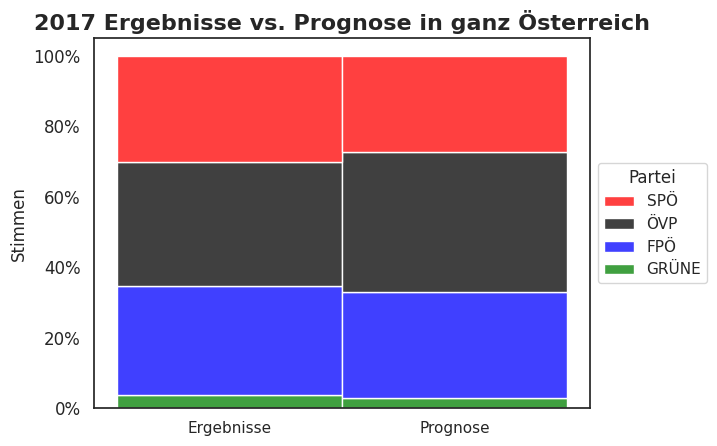

In [151]:
plot_election_results_stacked(nn_vergleich_17_ren, "2017 Ergebnisse vs. Prognose in ganz Österreich")

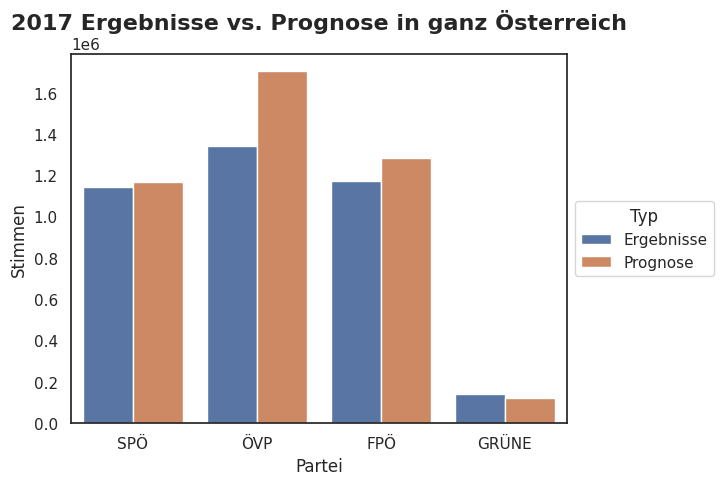

In [194]:
plot_election_results_bar(nn_vergleich_17_ren, "2017 Ergebnisse vs. Prognose in ganz Österreich")

Das Modell erkennt immerhin die gröberen Verhältnisse in Österreich.

## Prognose von Wahlergebnissen 2019

Mit dem Modell von 2017 wird versucht, die Ergebnisse von 2019 zu prognostizieren. Dafür muss der Datensatz von 2019 gleich, wie der von 2017 behandelt werden.

In [153]:
joined_19_ren['SPÖ % ganz'] = joined_19_ren['SPÖ'] / joined_19_ren['Bevölkerung (Abs.)']
joined_19_ren['FPÖ % ganz'] = joined_19_ren['FPÖ'] / joined_19_ren['Bevölkerung (Abs.)']
joined_19_ren['ÖVP % ganz'] = joined_19_ren['ÖVP'] / joined_19_ren['Bevölkerung (Abs.)']
joined_19_ren['GRÜNE % ganz'] = joined_19_ren['GRÜNE'] / joined_19_ren['Bevölkerung (Abs.)']


In [154]:
data_19 = joined_19_ren[input_columns + output_columns].astype(float)

...mit Ausnahme der Trainingssets und Testsets, denn der ganze Datensatz ist jetzt unser Testset.

In [155]:
y_19 = data_19[output_columns].values
X_19 = data_19[input_columns].values

Die Genauigkeit wird berechnet mit dem gespeicherten Modell:

In [156]:
loss, accuracy = model_17.evaluate(X_19, y_19)
print('Test accuracy:', accuracy)

67/67 [==============================] - 0s 5ms/step - loss: 0.3406 - accuracy: 0.8631
Test accuracy: 0.8630783557891846


Hier sind die prognostizierten Werte von 2019, anhand des Modells von 2017.

In [157]:
y_pred_17_19 = model_17.predict(X_19)

67/67 [==============================] - 0s 4ms/step


diese Variable enthält nun den Prozentsatz der Stimmen auf die ganze Bevölkerung pro Gemeinde. Die Reihenfolge der Parteien und der Gemeinden sind identisch mit der in dem dataframe mit den Wahlergebnissen

###Visualisierung

In [158]:
parteien_pr = ['SPÖ_%_prg', 'ÖVP_%_prg', 'FPÖ_%_prg', 'GRÜNE_%_prg']
prognose_17_19 = pd.DataFrame(y_pred_17)
prognose_17_19.columns = parteien_pr
#display(prognose_19)

Verkopplung der Wahlergebnissen mit deren Prognose

In [159]:
nn_vergleich_17_19 = election_indicators_2019.join(prognose_17_19)
display(nn_vergleich_17_19)

GCD  Gültige    SPÖ    ÖVP    FPÖ  GRÜNE   SPÖ (%)   ÖVP (%)  \
0     G10101     7114   1450   2966   1023    944  0.203823  0.416924   
1     G10201     1037    315    355    209     82  0.303761  0.342334   
2     G10301     1110    331    376    149    132  0.298198  0.338739   
3     G10302     1059    242    470    200     67  0.228517  0.443815   
4     G10303     1139    271    487    183    115  0.237928  0.427568   
...      ...      ...    ...    ...    ...    ...       ...       ...   
2113  G91901    25389   5493   8191   2758   4360  0.216354  0.322620   
2114  G92001    22332   8146   4482   3265   3982  0.364768  0.200699   
2115  G92101    55893  17044  14524  11254   6674  0.304940  0.259854   
2116  G92201    68571  20173  17712  12523   9455  0.294191  0.258302   
2117  G92301    40913  11189  11533   6516   5931  0.273483  0.281891   

       FPÖ (%)  GRÜNE (%)                    Gemeindename  Bevölkerung (Abs.)  \
0     0.143801   0.132696                      Eisenstadt               14800   
1     0.201543   0.079074                            Rust                1982   
2     0.134234   0.118919  Breitenbrunn am Neusiedler See                1884   
3     0.188857   0.063267                  Donnerskirchen                1838   
4     0.160667   0.100966                     Großhöflein                2106   
...        ...        ...                             ...                 ...   
2113  0.108630   0.171728                    Wien-Döbling               73860   
2114  0.146203   0.178309                Wien-Brigittenau               86417   
2115  0.201349   0.119407                Wien-Floridsdorf              167380   
2116  0.182628   0.137886                 Wien-Donaustadt              194368   
2117  0.159265   0.144966                    Wien-Liesing              109776   

      Bevölkerung < 15 (%)  Bevölkerung > 65 (%)  \
0                     13.9                  19.5   
1                     12.7                  25.9   
2                     11.8                  27.1   
3                     11.8                  23.9   
4                     14.1                  18.0   
...                    ...                   ...   
2113                  13.9                  21.9   
2114                  14.5                  15.3   
2115                  16.3                  16.9   
2116                  16.7                  15.3   
2117                  16.0                  19.7   

      Ausländische Staatsbürger (%)  Erwerbstätige (%)  Arbeitslose (%)  \
0                              15.5               71.5              5.6   
1                               7.2               77.5              4.2   
2                               5.9               73.2              5.0   
3                               6.7               75.3              3.8   
4                               5.9               79.3              2.5   
...                             ...                ...              ...   
2113                           25.6               65.1              9.2   
2114                           38.5               61.5             15.7   
2115                           24.9               66.2             12.5   
2116                           21.6               69.0              9.5   
2117                           20.8               70.0              9.7   

      Sekundarabschluss (%)  Tertiärabschluss (%)  Auspendler (%)  \
0                      58.5                  21.9            46.8   
1                      63.1                  10.6            63.1   
2                      65.9                  13.1            78.4   
3                      67.2                  11.5            77.9   
4                      63.3                  14.8            84.4   
...                     ...                   ...             ...   
2113                   48.9                  32.9            10.4   
2114                   49.3                  17.7            12.0   
2115        

Berechnung der prognostizierten Stimmen

In [160]:
nn_vergleich_17_19['SPÖ Prog.'] = nn_vergleich_17_19['SPÖ_%_prg'] * nn_vergleich_17_19['Gültige']
nn_vergleich_17_19['ÖVP Prog.'] = nn_vergleich_17_19['ÖVP_%_prg'] * nn_vergleich_17_19['Gültige']
nn_vergleich_17_19['FPÖ Prog.'] = nn_vergleich_17_19['FPÖ_%_prg'] * nn_vergleich_17_19['Gültige']
nn_vergleich_17_19['GRÜNE Prog.'] = nn_vergleich_17_19['GRÜNE_%_prg'] * nn_vergleich_17_19['Gültige']
display(nn_vergleich_17_19)

GCD  Gültige    SPÖ    ÖVP    FPÖ  GRÜNE   SPÖ (%)   ÖVP (%)  \
0     G10101     7114   1450   2966   1023    944  0.203823  0.416924   
1     G10201     1037    315    355    209     82  0.303761  0.342334   
2     G10301     1110    331    376    149    132  0.298198  0.338739   
3     G10302     1059    242    470    200     67  0.228517  0.443815   
4     G10303     1139    271    487    183    115  0.237928  0.427568   
...      ...      ...    ...    ...    ...    ...       ...       ...   
2113  G91901    25389   5493   8191   2758   4360  0.216354  0.322620   
2114  G92001    22332   8146   4482   3265   3982  0.364768  0.200699   
2115  G92101    55893  17044  14524  11254   6674  0.304940  0.259854   
2116  G92201    68571  20173  17712  12523   9455  0.294191  0.258302   
2117  G92301    40913  11189  11533   6516   5931  0.273483  0.281891   

       FPÖ (%)  GRÜNE (%)                    Gemeindename  Bevölkerung (Abs.)  \
0     0.143801   0.132696                      Eisenstadt               14800   
1     0.201543   0.079074                            Rust                1982   
2     0.134234   0.118919  Breitenbrunn am Neusiedler See                1884   
3     0.188857   0.063267                  Donnerskirchen                1838   
4     0.160667   0.100966                     Großhöflein                2106   
...        ...        ...                             ...                 ...   
2113  0.108630   0.171728                    Wien-Döbling               73860   
2114  0.146203   0.178309                Wien-Brigittenau               86417   
2115  0.201349   0.119407                Wien-Floridsdorf              167380   
2116  0.182628   0.137886                 Wien-Donaustadt              194368   
2117  0.159265   0.144966                    Wien-Liesing              109776   

      Bevölkerung < 15 (%)  Bevölkerung > 65 (%)  \
0                     13.9                  19.5   
1                     12.7                  25.9   
2                     11.8                  27.1   
3                     11.8                  23.9   
4                     14.1                  18.0   
...                    ...                   ...   
2113                  13.9                  21.9   
2114                  14.5                  15.3   
2115                  16.3                  16.9   
2116                  16.7                  15.3   
2117                  16.0                  19.7   

      Ausländische Staatsbürger (%)  Erwerbstätige (%)  Arbeitslose (%)  \
0                              15.5               71.5              5.6   
1                               7.2               77.5              4.2   
2                               5.9               73.2              5.0   
3                               6.7               75.3              3.8   
4                               5.9               79.3              2.5   
...                             ...                ...              ...   
2113                           25.6               65.1              9.2   
2114                           38.5               61.5             15.7   
2115                           24.9               66.2             12.5   
2116                           21.6               69.0              9.5   
2117                           20.8               70.0              9.7   

      Sekundarabschluss (%)  Tertiärabschluss (%)  Auspendler (%)  \
0                      58.5                  21.9            46.8   
1                      63.1                  10.6            63.1   
2                      65.9                  13.1            78.4   
3                      67.2                  11.5            77.9   
4                      63.3                  14.8            84.4   
...                     ...                   ...             ...   
2113                   48.9                  32.9            10.4   
2114                   49.3                  17.7            12.0   
2115        

Die für die Visualisierung benötigten Spalten werden ausgesucht

In [161]:
visual_columns = [
    'GCD', 
    'SPÖ', 'ÖVP', 'FPÖ', 'GRÜNE',
    'SPÖ Prog.', 'ÖVP Prog.', 'FPÖ Prog.', 'GRÜNE Prog.',
    'SPÖ (%)', 'ÖVP (%)', 'FPÖ (%)', 'GRÜNE (%)',
    'SPÖ_%_prg', 'ÖVP_%_prg', 'FPÖ_%_prg', 'GRÜNE_%_prg'
]
visuals_17_19 = nn_vergleich_17_19[visual_columns]

In [162]:
nn_vergleich_17_19_ren = nn_vergleich_17_19.rename (columns = {
    'SPÖ':'SPÖ Ergb.',
    'ÖVP':'ÖVP Ergb.',
    'FPÖ':'FPÖ Ergb.',
    'GRÜNE':'GRÜNE Ergb.',
})
print(nn_vergleich_17_19_ren.columns)

Index(['GCD', 'Gültige', 'SPÖ Ergb.', 'ÖVP Ergb.', 'FPÖ Ergb.', 'GRÜNE Ergb.',
       'SPÖ (%)', 'ÖVP (%)', 'FPÖ (%)', 'GRÜNE (%)', 'Gemeindename',
       'Bevölkerung (Abs.)', 'Bevölkerung < 15 (%)', 'Bevölkerung > 65 (%)',
       'Ausländische Staatsbürger (%)', 'Erwerbstätige (%)', 'Arbeitslose (%)',
       'Sekundarabschluss (%)', 'Tertiärabschluss (%)', 'Auspendler (%)',
       'Haushaltsgröße (Abs.)', 'Unternehmen (Abs.)', 'Unternehmen (pro Kopf)',
       'Wahlbeteiligung', 'Bevölkerung_log', 'Unternehmen_log', 'Bsld',
       'SPÖ_%_prg', 'ÖVP_%_prg', 'FPÖ_%_prg', 'GRÜNE_%_prg', 'SPÖ Prog.',
       'ÖVP Prog.', 'FPÖ Prog.', 'GRÜNE Prog.'],
      dtype='object')


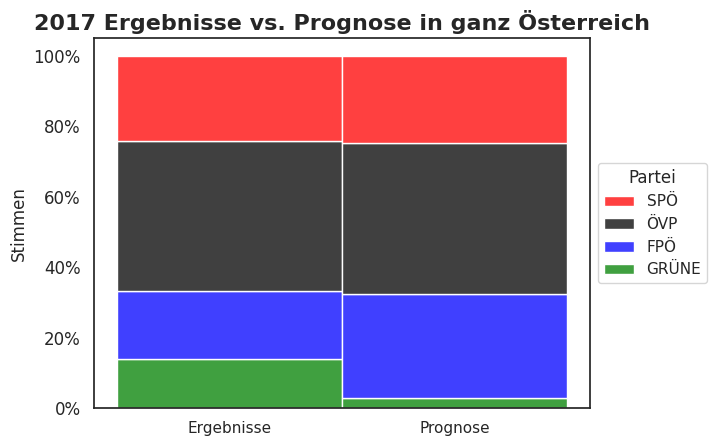

In [163]:
plot_election_results_stacked(nn_vergleich_17_19_ren, "2017 Ergebnisse vs. Prognose in ganz Österreich")

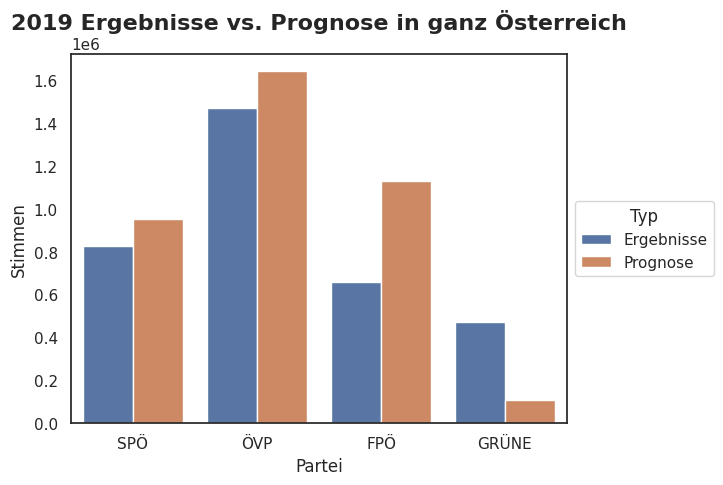

In [164]:
plot_election_results_bar(nn_vergleich_17_19_ren, "2019 Ergebnisse vs. Prognose in ganz Österreich")

Die zwei größten Parteien waren überprognostiziert.

Die Diskrepanz zwischen der Prognose und den Ergebnissen bei den Grünen und der FPÖ betrifft: Zwei signifikante Änderungen sind zwischen 2017 und 2019 passiert, die es erklären könnten:

1. Die Wahlen von 2017 waren vom Standpunkt der Grünen eine Anomalie, denn ihre Wählerschaft wurde durch die Liste Pilz gespalten. 2019 waren die Liste Pilz nicht mehr auf der Palette.
2. Das Ibiza-Video, das einen schlagartigen Einbruch bei der Wählerschaft der FPÖ verursacht hat. Davon hat am meisten die ÖVP profitiert.

#Training eines Neuronalen Netzes für 2019

Die Wahlen von 2017 waren vom Standpunkt der Grünen eine Anomalie, denn ihre Wählerschaft wurde durch die Liste Pilz gespalten. 2019 waren die Liste Pilz nicht mehr auf der Palette.

###Training und Test sets

Aufteilung auf Trainingsset und Testset

In [165]:
X_19_train, X_19_test, y_19_train, y_19_test = train_test_split(X_19, y_19, test_size=0.2, random_state=0)

###Tuning

Die gleiche Suche wird aufgeführt:

In [166]:
tuner_19 = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=10,
    executions_per_trial=3,
    overwrite=True,
    directory="/content/models",
    project_name="Election_2019",
)

In [167]:
tuner_19.search(X_19_train, y_19_train, epochs=10, validation_data=(X_19_test, y_19_test))

Trial 10 Complete [00h 00m 22s]
val_accuracy: 0.9221698045730591

Best val_accuracy So Far: 0.9237421353658041
Total elapsed time: 00h 02m 44s


Die beste Architektur für 2019:

In [168]:
models_19 = tuner_19.get_best_models(num_models=2)
best_model_19 = models_19[0]
best_model_19.build(input_shape=(None, len(input_columns),))
best_model_19.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 416)               9152      
                                                                 
 dense_1 (Dense)             (None, 32)                13344     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 23,684
Trainable params: 23,684
Non-trainable params: 0
_________________________________________________________________


...und sie wird gespeichert:

In [169]:
best_model_19.save('/content/best_model_19.h5')

In [170]:
print(tuner_19.results_summary(1))

Results summary
Results in /content/models/Election_2019
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 00 summary
Hyperparameters:
num_layers: 3
units_0: 416
activation: tanh
dropout: False
lr: 0.0008053532244671809
units_1: 32
units_2: 32
Score: 0.9237421353658041
None


##Prognose von 2019 auf 2019

##Das eben generierte Modell

Das beste Modell für 2019 wird trainiert und mit Gewichtungen versehen.

In [171]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=10)

best_model_19.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
best_model_19.fit(X_19_train, y_19_train, epochs=200, batch_size=64, callbacks=[early_stop])
loss_19, accuracy_19 = best_model_19.evaluate(X_19_test, y_19_test)
print('Test accuracy:', accuracy_19)

Epoch 1/200
27/27 [==============================] - 1s 3ms/step - loss: 0.3462 - accuracy: 0.9250
Epoch 2/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3342 - accuracy: 0.9250
Epoch 3/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3332 - accuracy: 0.9250
Epoch 4/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3322 - accuracy: 0.9250
Epoch 5/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3315 - accuracy: 0.9250
Epoch 6/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3311 - accuracy: 0.9256
Epoch 7/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3308 - accuracy: 0.9256
Epoch 8/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3304 - accuracy: 0.9256
Epoch 9/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3301 - accuracy: 0.9233
Epoch 10/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3299 - accuracy: 0.9233
Epoch 11/

##Laden eines früher gespeicherten Modells

Das allerbeste Modell aus vielen Versuchen:

In [172]:
model_19_url='https://drive.google.com/uc?id=1jcpie_EXi7VqUk1ogXvT484CLT2671JT'
response = requests.get(model_19_url)
open('model_19.h5', 'wb').write(response.content)
model_19 = load_model('model_19.h5')

In [173]:
model_19.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_19.fit(X_19_train, y_19_train, epochs=200, batch_size=64, callbacks=[early_stop])
loss_19, accuracy_19 = model_19.evaluate(X_19_test, y_19_test)
print('Test accuracy:', accuracy_19)

Epoch 1/200
27/27 [==============================] - 1s 2ms/step - loss: 1.7867 - accuracy: 0.5437
Epoch 2/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3548 - accuracy: 0.9227
Epoch 3/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3345 - accuracy: 0.9250
Epoch 4/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3329 - accuracy: 0.9268
Epoch 5/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3323 - accuracy: 0.9274
Epoch 6/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3317 - accuracy: 0.9280
Epoch 7/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3313 - accuracy: 0.9274
Epoch 8/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3310 - accuracy: 0.9303
Epoch 9/200
27/27 [==============================] - 0s 3ms/step - loss: 0.3307 - accuracy: 0.9280
Epoch 10/200
27/27 [==============================] - 0s 2ms/step - loss: 0.3304 - accuracy: 0.9298
Epoch 11/

In [174]:
y_pred_19 = model_19.predict(X_19)

67/67 [==============================] - 0s 1ms/step


diese Variable enthält nun den Prozentsatz der Stimmen auf die ganze Bevölkerung pro Gemeinde. Die Reihenfolge der Parteien und der Gemeinden sind identisch mit der in dem dataframe mit den Wahlergebnissen.

##Visualisierung

Am besten hat das Modell geleistet, das mit den Daten von 2019 trainiert wurde und auf die Daten von 2019 getestet wurde.

Für die Visualisierung werden absolute Stimmen und relative Prozente benötigt, diese werden von den rohen Daten wieder hergestellt.

In [175]:
parteien_pr = ['SPÖ_%_prg', 'ÖVP_%_prg', 'FPÖ_%_prg', 'GRÜNE_%_prg']
prognose_19 = pd.DataFrame(y_pred_19)
prognose_19.columns = parteien_pr
#display(prognose_19)

Verkopplung der Wahlergebnissen mit deren Prognose

In [176]:
nn_vergleich_19 = election_indicators_2019.join(prognose_19)
display(nn_vergleich_19)

GCD  Gültige    SPÖ    ÖVP    FPÖ  GRÜNE   SPÖ (%)   ÖVP (%)  \
0     G10101     7114   1450   2966   1023    944  0.203823  0.416924   
1     G10201     1037    315    355    209     82  0.303761  0.342334   
2     G10301     1110    331    376    149    132  0.298198  0.338739   
3     G10302     1059    242    470    200     67  0.228517  0.443815   
4     G10303     1139    271    487    183    115  0.237928  0.427568   
...      ...      ...    ...    ...    ...    ...       ...       ...   
2113  G91901    25389   5493   8191   2758   4360  0.216354  0.322620   
2114  G92001    22332   8146   4482   3265   3982  0.364768  0.200699   
2115  G92101    55893  17044  14524  11254   6674  0.304940  0.259854   
2116  G92201    68571  20173  17712  12523   9455  0.294191  0.258302   
2117  G92301    40913  11189  11533   6516   5931  0.273483  0.281891   

       FPÖ (%)  GRÜNE (%)                    Gemeindename  Bevölkerung (Abs.)  \
0     0.143801   0.132696                      Eisenstadt               14800   
1     0.201543   0.079074                            Rust                1982   
2     0.134234   0.118919  Breitenbrunn am Neusiedler See                1884   
3     0.188857   0.063267                  Donnerskirchen                1838   
4     0.160667   0.100966                     Großhöflein                2106   
...        ...        ...                             ...                 ...   
2113  0.108630   0.171728                    Wien-Döbling               73860   
2114  0.146203   0.178309                Wien-Brigittenau               86417   
2115  0.201349   0.119407                Wien-Floridsdorf              167380   
2116  0.182628   0.137886                 Wien-Donaustadt              194368   
2117  0.159265   0.144966                    Wien-Liesing              109776   

      Bevölkerung < 15 (%)  Bevölkerung > 65 (%)  \
0                     13.9                  19.5   
1                     12.7                  25.9   
2                     11.8                  27.1   
3                     11.8                  23.9   
4                     14.1                  18.0   
...                    ...                   ...   
2113                  13.9                  21.9   
2114                  14.5                  15.3   
2115                  16.3                  16.9   
2116                  16.7                  15.3   
2117                  16.0                  19.7   

      Ausländische Staatsbürger (%)  Erwerbstätige (%)  Arbeitslose (%)  \
0                              15.5               71.5              5.6   
1                               7.2               77.5              4.2   
2                               5.9               73.2              5.0   
3                               6.7               75.3              3.8   
4                               5.9               79.3              2.5   
...                             ...                ...              ...   
2113                           25.6               65.1              9.2   
2114                           38.5               61.5             15.7   
2115                           24.9               66.2             12.5   
2116                           21.6               69.0              9.5   
2117                           20.8               70.0              9.7   

      Sekundarabschluss (%)  Tertiärabschluss (%)  Auspendler (%)  \
0                      58.5                  21.9            46.8   
1                      63.1                  10.6            63.1   
2                      65.9                  13.1            78.4   
3                      67.2                  11.5            77.9   
4                      63.3                  14.8            84.4   
...                     ...                   ...             ...   
2113                   48.9                  32.9            10.4   
2114                   49.3                  17.7            12.0   
2115        

Berechnung der prognostizierten Stimmen

In [177]:
nn_vergleich_19['SPÖ Prog.'] = nn_vergleich_19['SPÖ_%_prg'] * nn_vergleich_19['Gültige']
nn_vergleich_19['ÖVP Prog.'] = nn_vergleich_19['ÖVP_%_prg'] * nn_vergleich_19['Gültige']
nn_vergleich_19['FPÖ Prog.'] = nn_vergleich_19['FPÖ_%_prg'] * nn_vergleich_19['Gültige']
nn_vergleich_19['GRÜNE Prog.'] = nn_vergleich_19['GRÜNE_%_prg'] * nn_vergleich_19['Gültige']
display(nn_vergleich_19)

GCD  Gültige    SPÖ    ÖVP    FPÖ  GRÜNE   SPÖ (%)   ÖVP (%)  \
0     G10101     7114   1450   2966   1023    944  0.203823  0.416924   
1     G10201     1037    315    355    209     82  0.303761  0.342334   
2     G10301     1110    331    376    149    132  0.298198  0.338739   
3     G10302     1059    242    470    200     67  0.228517  0.443815   
4     G10303     1139    271    487    183    115  0.237928  0.427568   
...      ...      ...    ...    ...    ...    ...       ...       ...   
2113  G91901    25389   5493   8191   2758   4360  0.216354  0.322620   
2114  G92001    22332   8146   4482   3265   3982  0.364768  0.200699   
2115  G92101    55893  17044  14524  11254   6674  0.304940  0.259854   
2116  G92201    68571  20173  17712  12523   9455  0.294191  0.258302   
2117  G92301    40913  11189  11533   6516   5931  0.273483  0.281891   

       FPÖ (%)  GRÜNE (%)                    Gemeindename  Bevölkerung (Abs.)  \
0     0.143801   0.132696                      Eisenstadt               14800   
1     0.201543   0.079074                            Rust                1982   
2     0.134234   0.118919  Breitenbrunn am Neusiedler See                1884   
3     0.188857   0.063267                  Donnerskirchen                1838   
4     0.160667   0.100966                     Großhöflein                2106   
...        ...        ...                             ...                 ...   
2113  0.108630   0.171728                    Wien-Döbling               73860   
2114  0.146203   0.178309                Wien-Brigittenau               86417   
2115  0.201349   0.119407                Wien-Floridsdorf              167380   
2116  0.182628   0.137886                 Wien-Donaustadt              194368   
2117  0.159265   0.144966                    Wien-Liesing              109776   

      Bevölkerung < 15 (%)  Bevölkerung > 65 (%)  \
0                     13.9                  19.5   
1                     12.7                  25.9   
2                     11.8                  27.1   
3                     11.8                  23.9   
4                     14.1                  18.0   
...                    ...                   ...   
2113                  13.9                  21.9   
2114                  14.5                  15.3   
2115                  16.3                  16.9   
2116                  16.7                  15.3   
2117                  16.0                  19.7   

      Ausländische Staatsbürger (%)  Erwerbstätige (%)  Arbeitslose (%)  \
0                              15.5               71.5              5.6   
1                               7.2               77.5              4.2   
2                               5.9               73.2              5.0   
3                               6.7               75.3              3.8   
4                               5.9               79.3              2.5   
...                             ...                ...              ...   
2113                           25.6               65.1              9.2   
2114                           38.5               61.5             15.7   
2115                           24.9               66.2             12.5   
2116                           21.6               69.0              9.5   
2117                           20.8               70.0              9.7   

      Sekundarabschluss (%)  Tertiärabschluss (%)  Auspendler (%)  \
0                      58.5                  21.9            46.8   
1                      63.1                  10.6            63.1   
2                      65.9                  13.1            78.4   
3                      67.2                  11.5            77.9   
4                      63.3                  14.8            84.4   
...                     ...                   ...             ...   
2113                   48.9                  32.9            10.4   
2114                   49.3                  17.7            12.0   
2115        

Die für die Visualisierung benötigten Spalten werden ausgesucht

In [178]:
visual_columns = [
    'GCD', 
    'SPÖ', 'ÖVP', 'FPÖ', 'GRÜNE',
    'SPÖ Prog.', 'ÖVP Prog.', 'FPÖ Prog.', 'GRÜNE Prog.',
    'SPÖ (%)', 'ÖVP (%)', 'FPÖ (%)', 'GRÜNE (%)',
    'SPÖ_%_prg', 'ÖVP_%_prg', 'FPÖ_%_prg', 'GRÜNE_%_prg'
]
visuals_19 = nn_vergleich_19[visual_columns]

Merging mit den Geodaten

In [179]:
visuals_geo_19 = shapes_2019.merge(visuals_19, left_on='ID', right_on='GCD')

###Österreich

In [180]:
nn_vergleich_19_ren = nn_vergleich_19.rename (columns = {
    'SPÖ':'SPÖ Ergb.',
    'ÖVP':'ÖVP Ergb.',
    'FPÖ':'FPÖ Ergb.',
    'GRÜNE':'GRÜNE Ergb.',
})
print(nn_vergleich_19_ren.columns)

Index(['GCD', 'Gültige', 'SPÖ Ergb.', 'ÖVP Ergb.', 'FPÖ Ergb.', 'GRÜNE Ergb.',
       'SPÖ (%)', 'ÖVP (%)', 'FPÖ (%)', 'GRÜNE (%)', 'Gemeindename',
       'Bevölkerung (Abs.)', 'Bevölkerung < 15 (%)', 'Bevölkerung > 65 (%)',
       'Ausländische Staatsbürger (%)', 'Erwerbstätige (%)', 'Arbeitslose (%)',
       'Sekundarabschluss (%)', 'Tertiärabschluss (%)', 'Auspendler (%)',
       'Haushaltsgröße (Abs.)', 'Unternehmen (Abs.)', 'Unternehmen (pro Kopf)',
       'Wahlbeteiligung', 'Bevölkerung_log', 'Unternehmen_log', 'Bsld',
       'SPÖ_%_prg', 'ÖVP_%_prg', 'FPÖ_%_prg', 'GRÜNE_%_prg', 'SPÖ Prog.',
       'ÖVP Prog.', 'FPÖ Prog.', 'GRÜNE Prog.'],
      dtype='object')


####Zusammenzählung

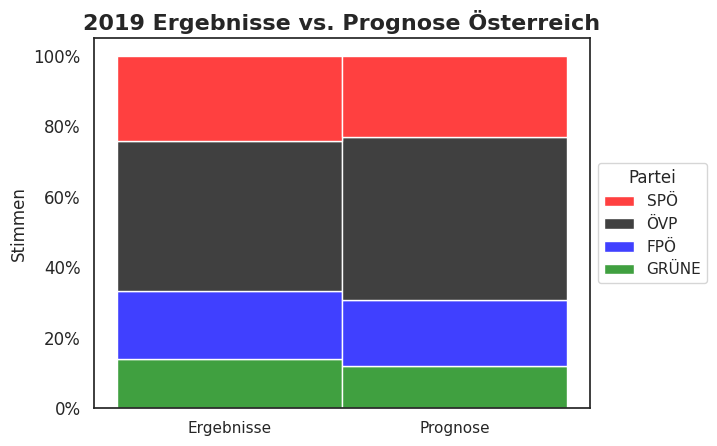

In [181]:
plot_election_results_stacked(nn_vergleich_19_ren, "2019 Ergebnisse vs. Prognose Österreich")

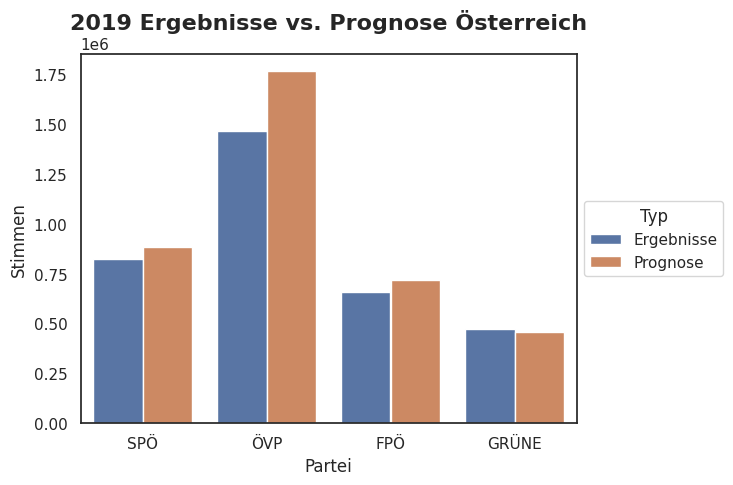

In [182]:
plot_election_results_bar(nn_vergleich_19_ren, "2019 Ergebnisse vs. Prognose Österreich")

Bei der Verteilung lag das Modell fast richtig, nur die ÖVP wurde deutlich (um 16% bei den absoluten Stimmen) überprognostiziert.

####Geographische Darstellung

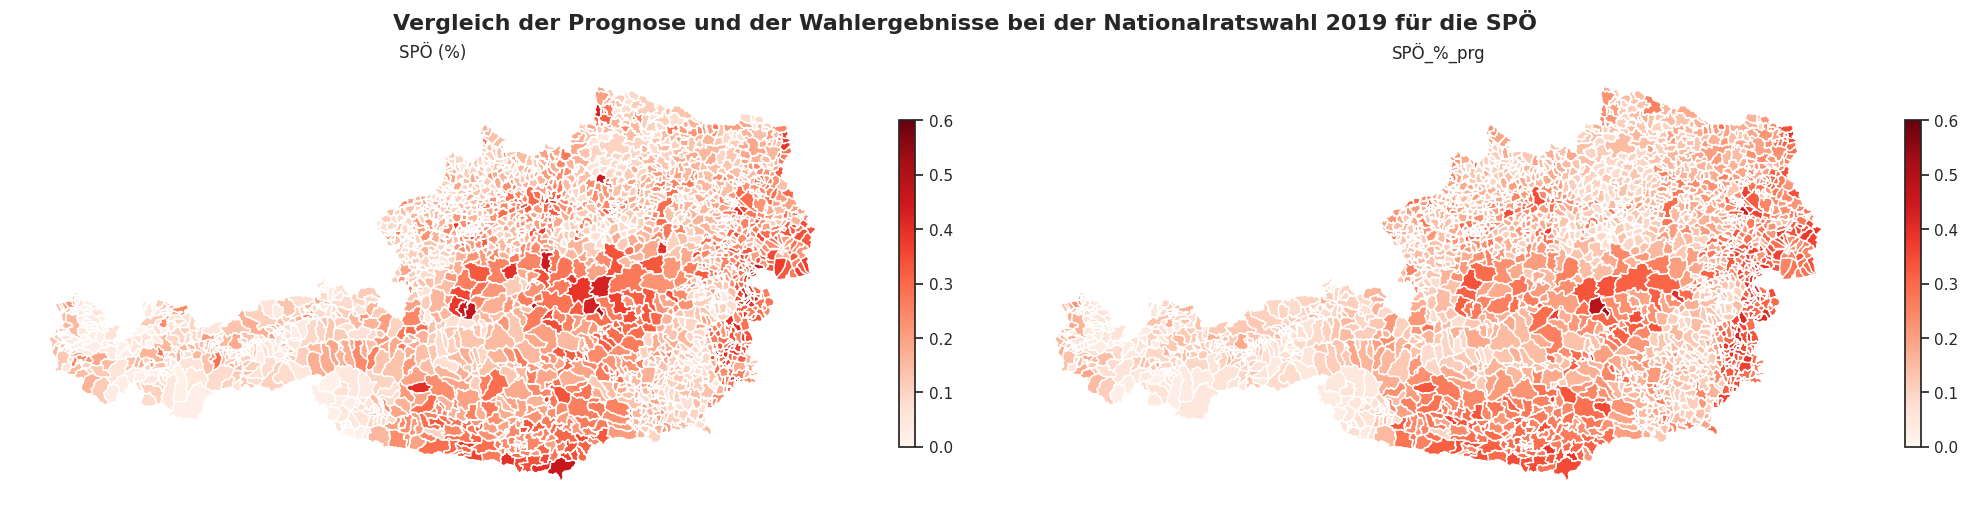

In [195]:
geoplot(visuals_geo_19[['ID', 'geometry', 'SPÖ (%)', 'SPÖ_%_prg']], 1, 2, ['Reds', 'Reds'], 'Vergleich der Prognose und der Wahlergebnisse bei der Nationalratswahl 2019 für die SPÖ', v_min=0, v_max=0.6)

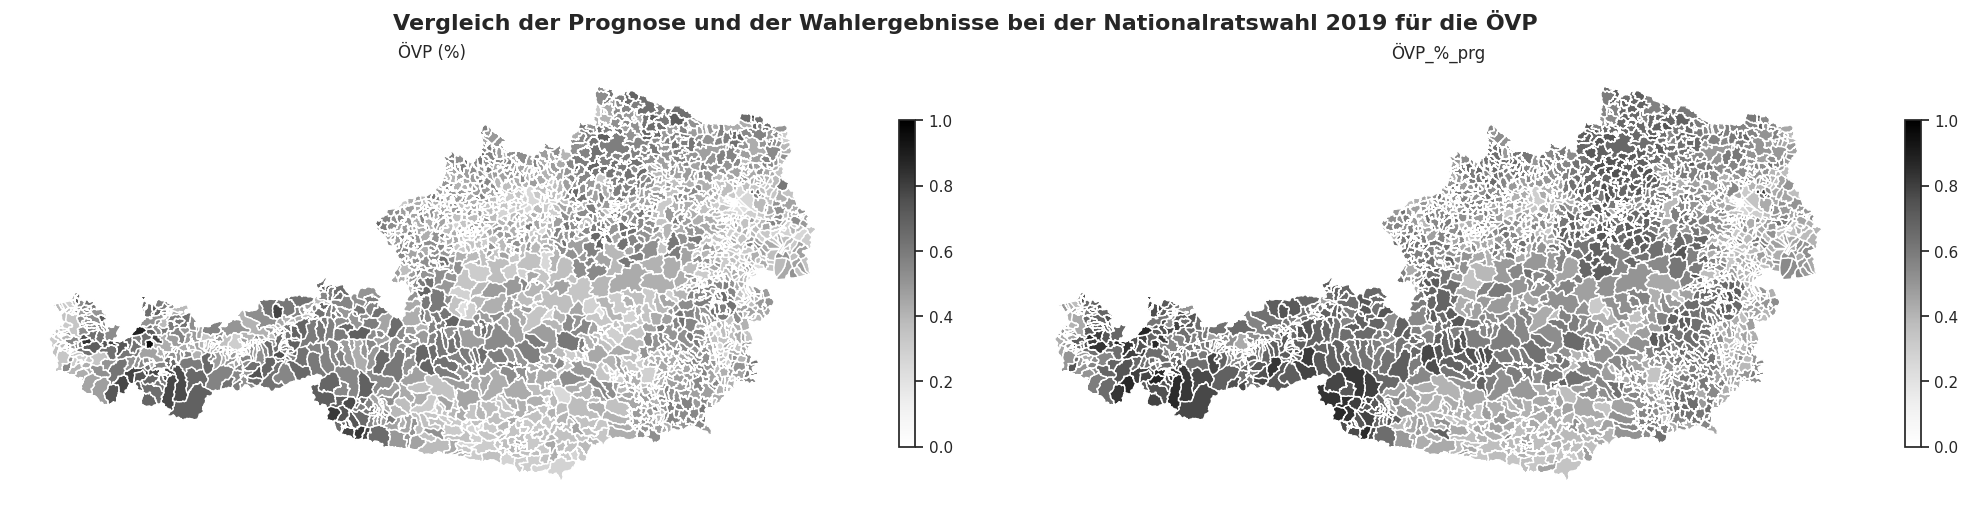

In [196]:
geoplot(visuals_geo_19[['ID', 'geometry', 'ÖVP (%)', 'ÖVP_%_prg']], 1, 2, ['Greys', 'Greys'], 'Vergleich der Prognose und der Wahlergebnisse bei der Nationalratswahl 2019 für die ÖVP', v_min=0, v_max=1)

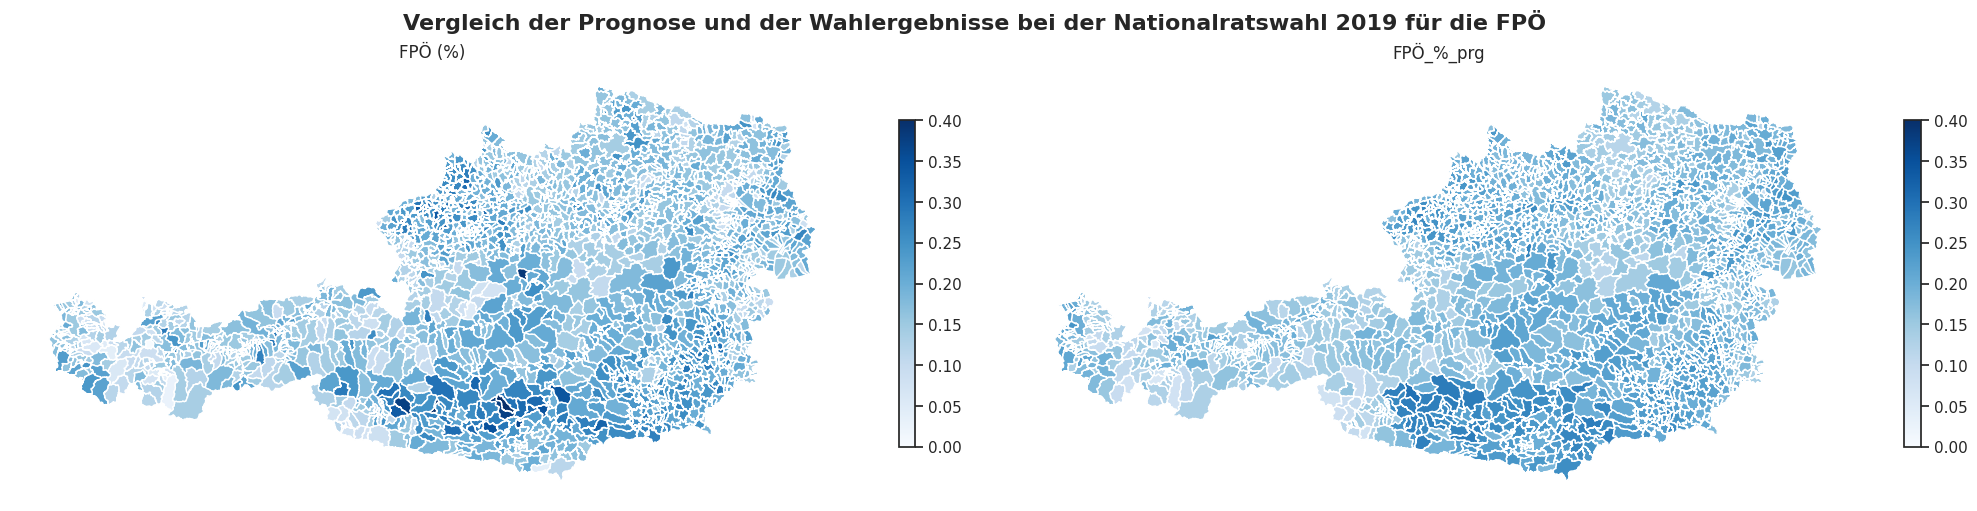

In [197]:
geoplot(visuals_geo_19[['ID', 'geometry', 'FPÖ (%)', 'FPÖ_%_prg']], 1, 2, ['Blues', 'Blues'], 'Vergleich der Prognose und der Wahlergebnisse bei der Nationalratswahl 2019 für die FPÖ', v_min=0, v_max=0.4)

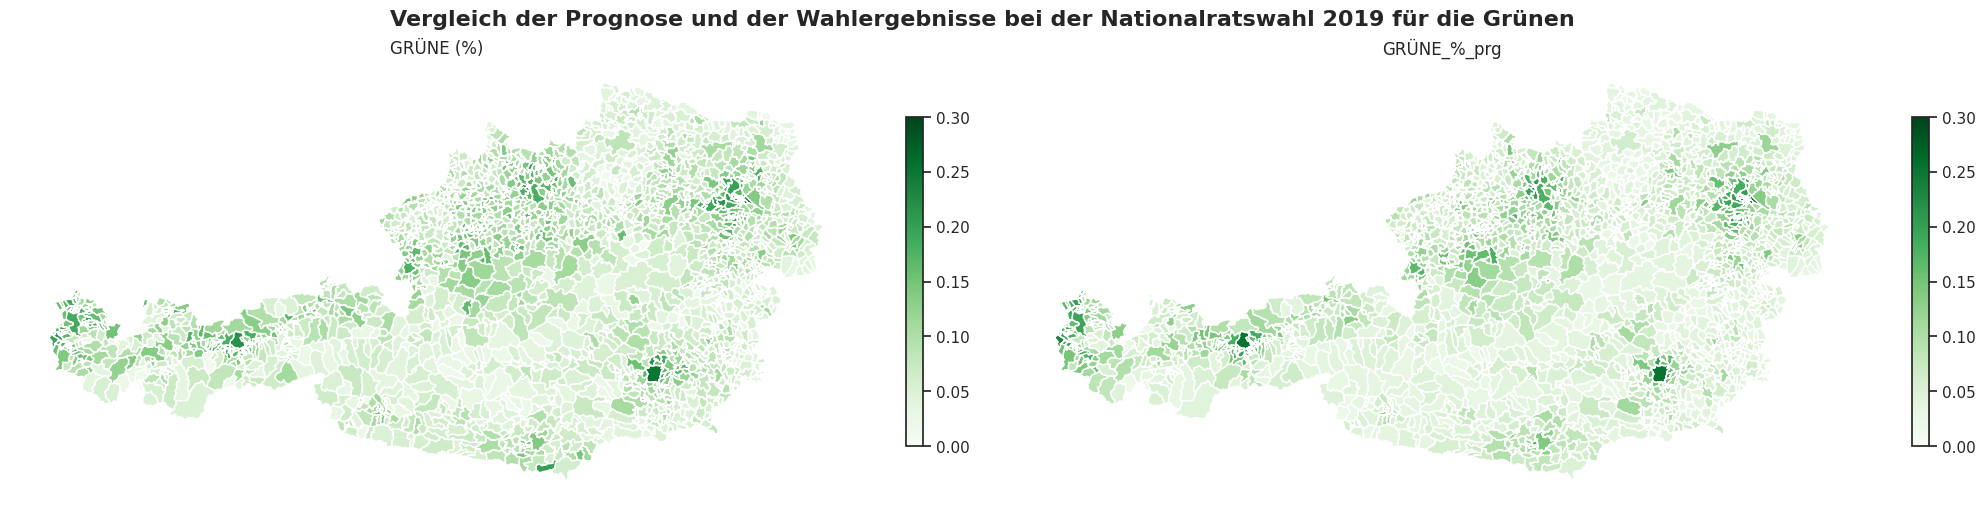

In [203]:
geoplot(visuals_geo_19[['ID', 'geometry', 'GRÜNE (%)', 'GRÜNE_%_prg']], 1, 2, ['Greens', 'Greens'], 'Vergleich der Prognose und der Wahlergebnisse bei der Nationalratswahl 2019 für die Grünen', v_min=0, v_max=0.3)

Überall ist die Ähnlichkeit der zwei Karten sofort zu erkennen. Die Hotspots sind gleich, nur die Werte zeigen ein wenig Unterschied. 

###Wien

####Zusammenzählung

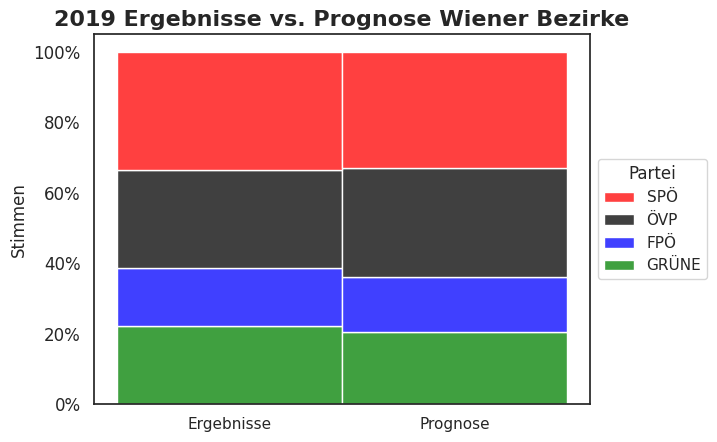

In [187]:
plot_election_results_stacked(nn_vergleich_19_ren.tail(23), "2019 Ergebnisse vs. Prognose Wiener Bezirke")

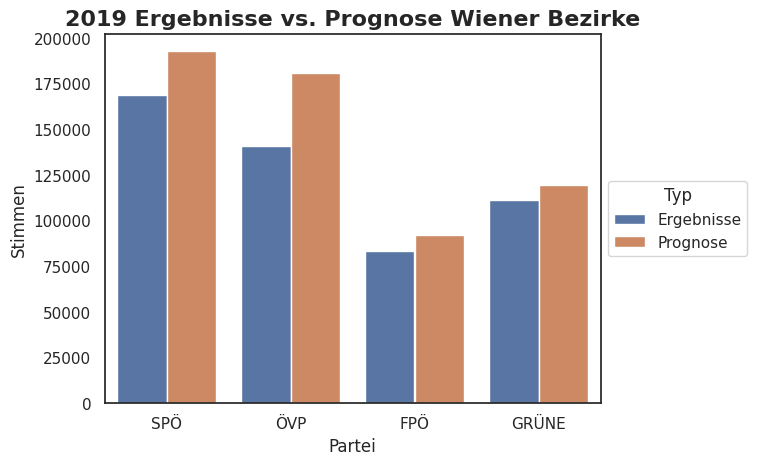

In [188]:
plot_election_results_bar(nn_vergleich_19_ren.tail(23), "2019 Ergebnisse vs. Prognose Wiener Bezirke")

In [189]:
shapes_2019_vienna = shapes_2019[shapes_2019['ID'].str.contains('G9')]
visuals_geo_19_vienna = shapes_2019_vienna.merge(visuals_19, left_on='ID', right_on='GCD')

####Geographische Darstellung

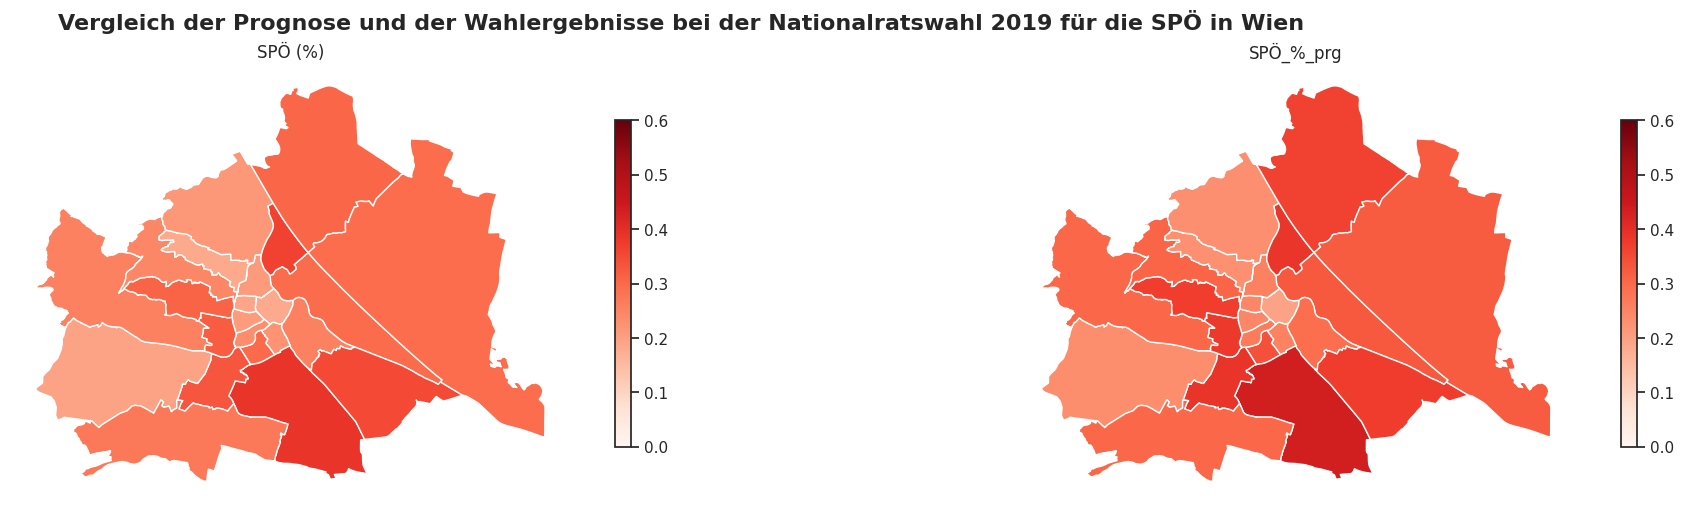

In [204]:
geoplot(visuals_geo_19_vienna[['ID', 'geometry', 'SPÖ (%)', 'SPÖ_%_prg']], 1, 2, ['Reds', 'Reds'], 'Vergleich der Prognose und der Wahlergebnisse bei der Nationalratswahl 2019 für die SPÖ in Wien', v_min=0, v_max=0.6)

In [205]:
geoplot(visuals_geo_19_vienna[['ID', 'geometry', 'ÖVP (%)', 'ÖVP_%_prg']], 1, 2, ['Greys', 'Greys'], 'Vergleich der Prognose und der Wahlergebnisse bei der Nationalratswahl 2019 für die ÖVP in Wien', v_min=0, v_max=0.5)

Hier ist auch sichtbar, dass die ÖVP überprognostiziert wurde.

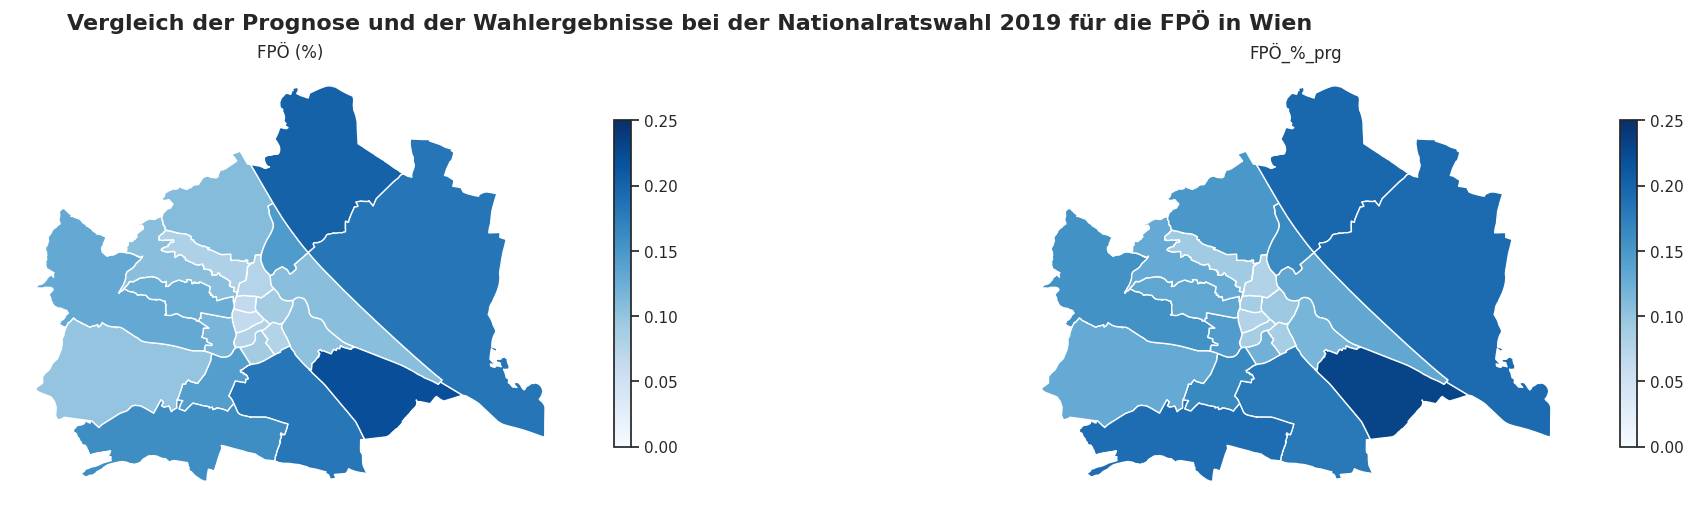

In [206]:
geoplot(visuals_geo_19_vienna[['ID', 'geometry', 'FPÖ (%)', 'FPÖ_%_prg']], 1, 2, ['Blues', 'Blues'], 'Vergleich der Prognose und der Wahlergebnisse bei der Nationalratswahl 2019 für die FPÖ in Wien', v_min=0, v_max=0.25)

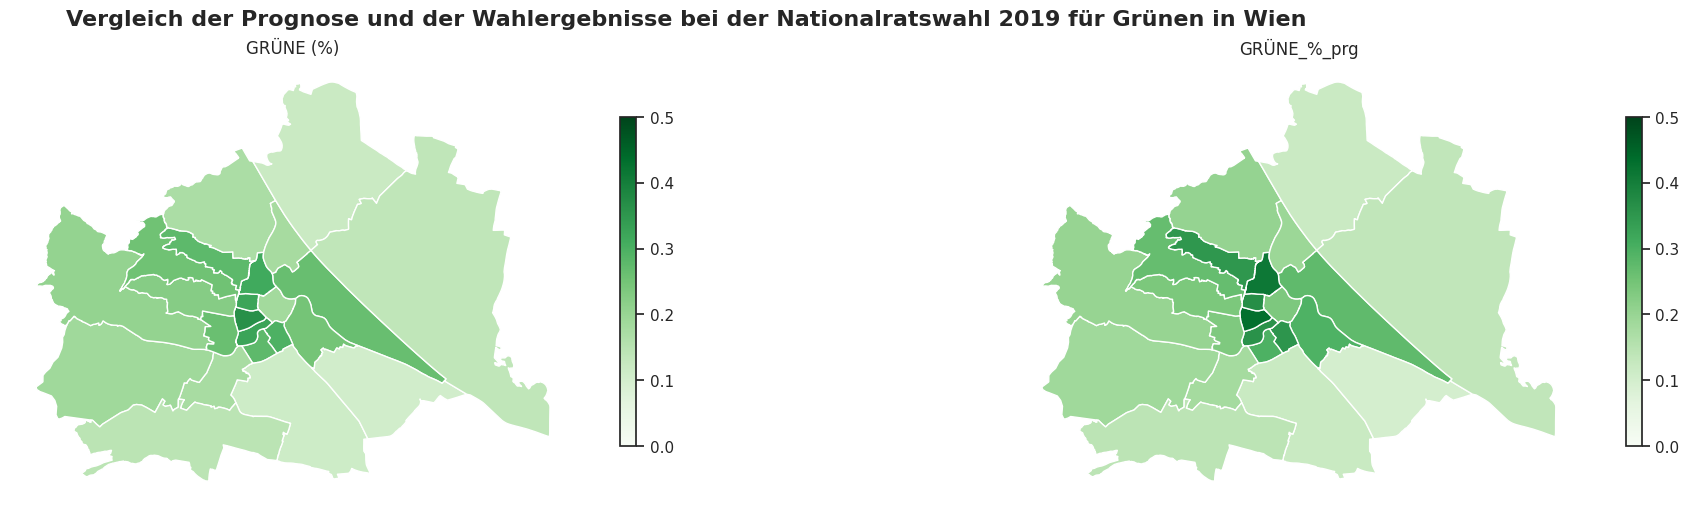

In [207]:
geoplot(visuals_geo_19_vienna[['ID', 'geometry', 'GRÜNE (%)', 'GRÜNE_%_prg']], 1, 2, ['Greens', 'Greens'], 'Vergleich der Prognose und der Wahlergebnisse bei der Nationalratswahl 2019 für Grünen in Wien', v_min=0, v_max=0.5)

Die Grünen waren in Wien ebenso etwas überprognostiziert.

# Prognose von Indikatoren zwischen 2020 und 2024, Wahlergebnissen 2024
Ursprünglich gab es noch die Idee, die Indikatoren in die Zukunft vorherzusagen und darauf basierend dann die Wahlergebnisse 2024 zu prognostizieren, jedoch war dafür nicht mehr genug Zeit vorhanden, da sich die Aufgabe als wesentlich komplexer herausgestellt hat: Es gibt bei den Indikatoren Abhängigkeiten, die nicht analysierbar sind mit den Datensätzen, die wir zur Verfügung haben.